<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/Berlin_Airbnb_Price_Prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
!pip install missingno
!pip install autoviz
!pip install geopy
!pip install scipy
!pandas_profiling
!pip install statsmodels
!pip install pyodbc
!pip install seaborn
!pip install nltk


/bin/bash: line 1: pandas_profiling: command not found


In [102]:
import numpy as np
import os
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns
sns.set()
plt.style.use('ggplot')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk

In [103]:
df = pd.read_pickle('/content/drive/MyDrive/kaggle/berline/ready_for_eda.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Listing ID            23536 non-null  int64         
 1   Overall Rating        18914 non-null  float64       
 2   Accuracy Rating       18888 non-null  float64       
 3   Cleanliness Rating    18892 non-null  float64       
 4   Checkin Rating        18870 non-null  float64       
 5   Communication Rating  18886 non-null  float64       
 6   Location Rating       18871 non-null  float64       
 7   Value Rating          18868 non-null  float64       
 8   Price                 23536 non-null  float64       
 9   Square Feet           425 non-null    float64       
 10  Reviews               23536 non-null  float64       
 11  review_date           19380 non-null  datetime64[ns]
 12  Bedrooms              23516 non-null  float64       
 13  Beds            

In [104]:
df.shape
# df.drop(columns=['Square Feet'], inplace=True)

(23536, 31)

#Data Protocol
###Exporting results to the protocol

In [105]:
# Type of valaues
df.dtypes.to_excel("berline_datatype.xlsx",
             sheet_name='data_type')
# Maximum valaues
df.select_dtypes(include=['float','int','category']).max().to_excel("max_berline.xlsx",
             sheet_name='max')
# Minimum Values
df.select_dtypes(include=['float','int','category']).min().to_excel("min_berline.xlsx",
             sheet_name='min')
# Missing Values
df.isnull().sum(axis=0).to_excel("NA_berline.xlsx",
             sheet_name='NA')
# exporting results to the protocol
df.nunique().to_excel("unique_berline.xlsx",
             sheet_name='unique')

#Transform data

In [106]:
# df['year'] = df['review_date'].dt.year
# df['month'] = df['review_date'].dt.month
# df['day'] = df['review_date'].dt.day
# df.drop(columns=['review_date'], inplace=True)

# #TBD need to drop it in the prep
# df.drop(['Neighborhood Group','Property Type'], axis=1, inplace=True)
# df['Host Since'] = pd.to_datetime(df['Host Since']).dt.year



### move out non relevant data for the

In [107]:
df = df.drop(columns=['Listing ID', 'review_date', 'Host Since'])


In [108]:
#get dummies
df_dummy = df[[col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]]
df_dummy.columns

Index(['Is Superhost', 'Instant Bookable', 'Is Exact Location'], dtype='object')

In [109]:
#get all numeric data
cols = df.columns
df_num = df._get_numeric_data().columns.dropna().unique()
#df_num = df_num.drop("Listing ID")
df_num

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Square Feet', 'Reviews', 'Bedrooms', 'Beds',
       'Bathrooms', 'Host Response Rate', 'Is Superhost', 'Latitude',
       'Longitude', 'Accomodates', 'Guests Included', 'Min Nights',
       'Instant Bookable', 'Is Exact Location'],
      dtype='object')

In [110]:
pd.set_option('display.max_columns', None)
df_num_non_dummy = df[list(set(df_num)-set(df_dummy.columns))]
df_num_non_dummy.columns


Index(['Value Rating', 'Host Response Rate', 'Location Rating',
       'Guests Included', 'Min Nights', 'Latitude', 'Price',
       'Cleanliness Rating', 'Bathrooms', 'Longitude', 'Reviews', 'Beds',
       'Overall Rating', 'Accuracy Rating', 'Square Feet', 'Checkin Rating',
       'Communication Rating', 'Bedrooms', 'Accomodates'],
      dtype='object')

In [111]:
#get categorial data
df_categorial=df[list(set(cols) - set(df_num))]
df_categorial.columns

Index(['Room Type', 'neighbourhood', 'Neighborhood Group', 'Postal Code',
       'Property Type', 'Host Response Time'],
      dtype='object')

In [112]:
df.describe()

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
count    18914.000000     18888.000000        18892.000000    18870.000000   
mean        94.564344         9.679850            9.334904        9.728829   
std          7.599949         0.737798            1.031248        0.695275   
min         20.000000         2.000000            2.000000        2.000000   
25%         92.000000        10.000000            9.000000       10.000000   
50%         97.000000        10.000000           10.000000       10.000000   
75%        100.000000        10.000000           10.000000       10.000000   
max        100.000000        10.000000           10.000000       10.000000   

       Communication Rating  Location Rating  Value Rating         Price  \
count          18886.000000     18871.000000  18868.000000  23536.000000   
mean               9.746479         9.550315      9.417638     69.612424   
std                0.679600         0.748713      0.840456    216.660408   
min                2.000000         2.000000      2.000000      0.000000   
25%               10.000000         9.000000      9.000000     32.000000   
50%               10.000000        10.000000     10.000000     49.000000   
75%               10.000000        10.000000     10.000000     75.000000   
max               10.000000        10.000000     10.000000   9000.000000   

       Square Feet       Reviews      Bedrooms          Beds     Bathrooms  \
count   425.000000  23536.000000  23516.000000  23501.000000  23507.000000   
mean    487.131765     19.238826      1.161720      1.641802      1.095971   
std     517.652098     40.360483      0.660736      1.228642      0.346150   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      1.000000      1.000000      1.000000      1.000000   
50%     420.000000      5.000000      1.000000      1.000000      1.000000   
75%     753.000000     17.000000      1.000000      2.000000      1.000000   
max    4639.000000    545.000000     10.000000     22.000000      8.500000   

       Host Response Rate      Latitude     Longitude   Accomodates  \
count        13046.000000  23536.000000  23536.000000  23536.000000   
mean            91.842174     52.509906     13.406193      2.671737   
std             19.447852      0.031279      0.058574      1.567812   
min              0.000000     52.345800     13.097180      1.000000   
25%             95.000000     52.489177     13.375730      2.000000   
50%            100.000000     52.509210     13.416575      2.000000   
75%            100.000000     52.532670     13.439532      3.000000   
max            100.000000     52.651670     13.757640     16.000000   

       Guests Included    Min Nights  
count     23536.000000  23536.000000  
mean          1.346151      6.897774  
std           0.856297     24.879032  
min           1.000000      1.000000  
25%           1.000000      2.000000  
50%           1.000000      3.000000  
75%           1.000000      4.000000  
max          16.000000   1000.000000

In [113]:
df_dummy.describe()

Is Superhost Instant Bookable Is Exact Location
count         23536            23536             23536
unique            2                2                 2
top           False            False              True
freq          19969            15658             17649

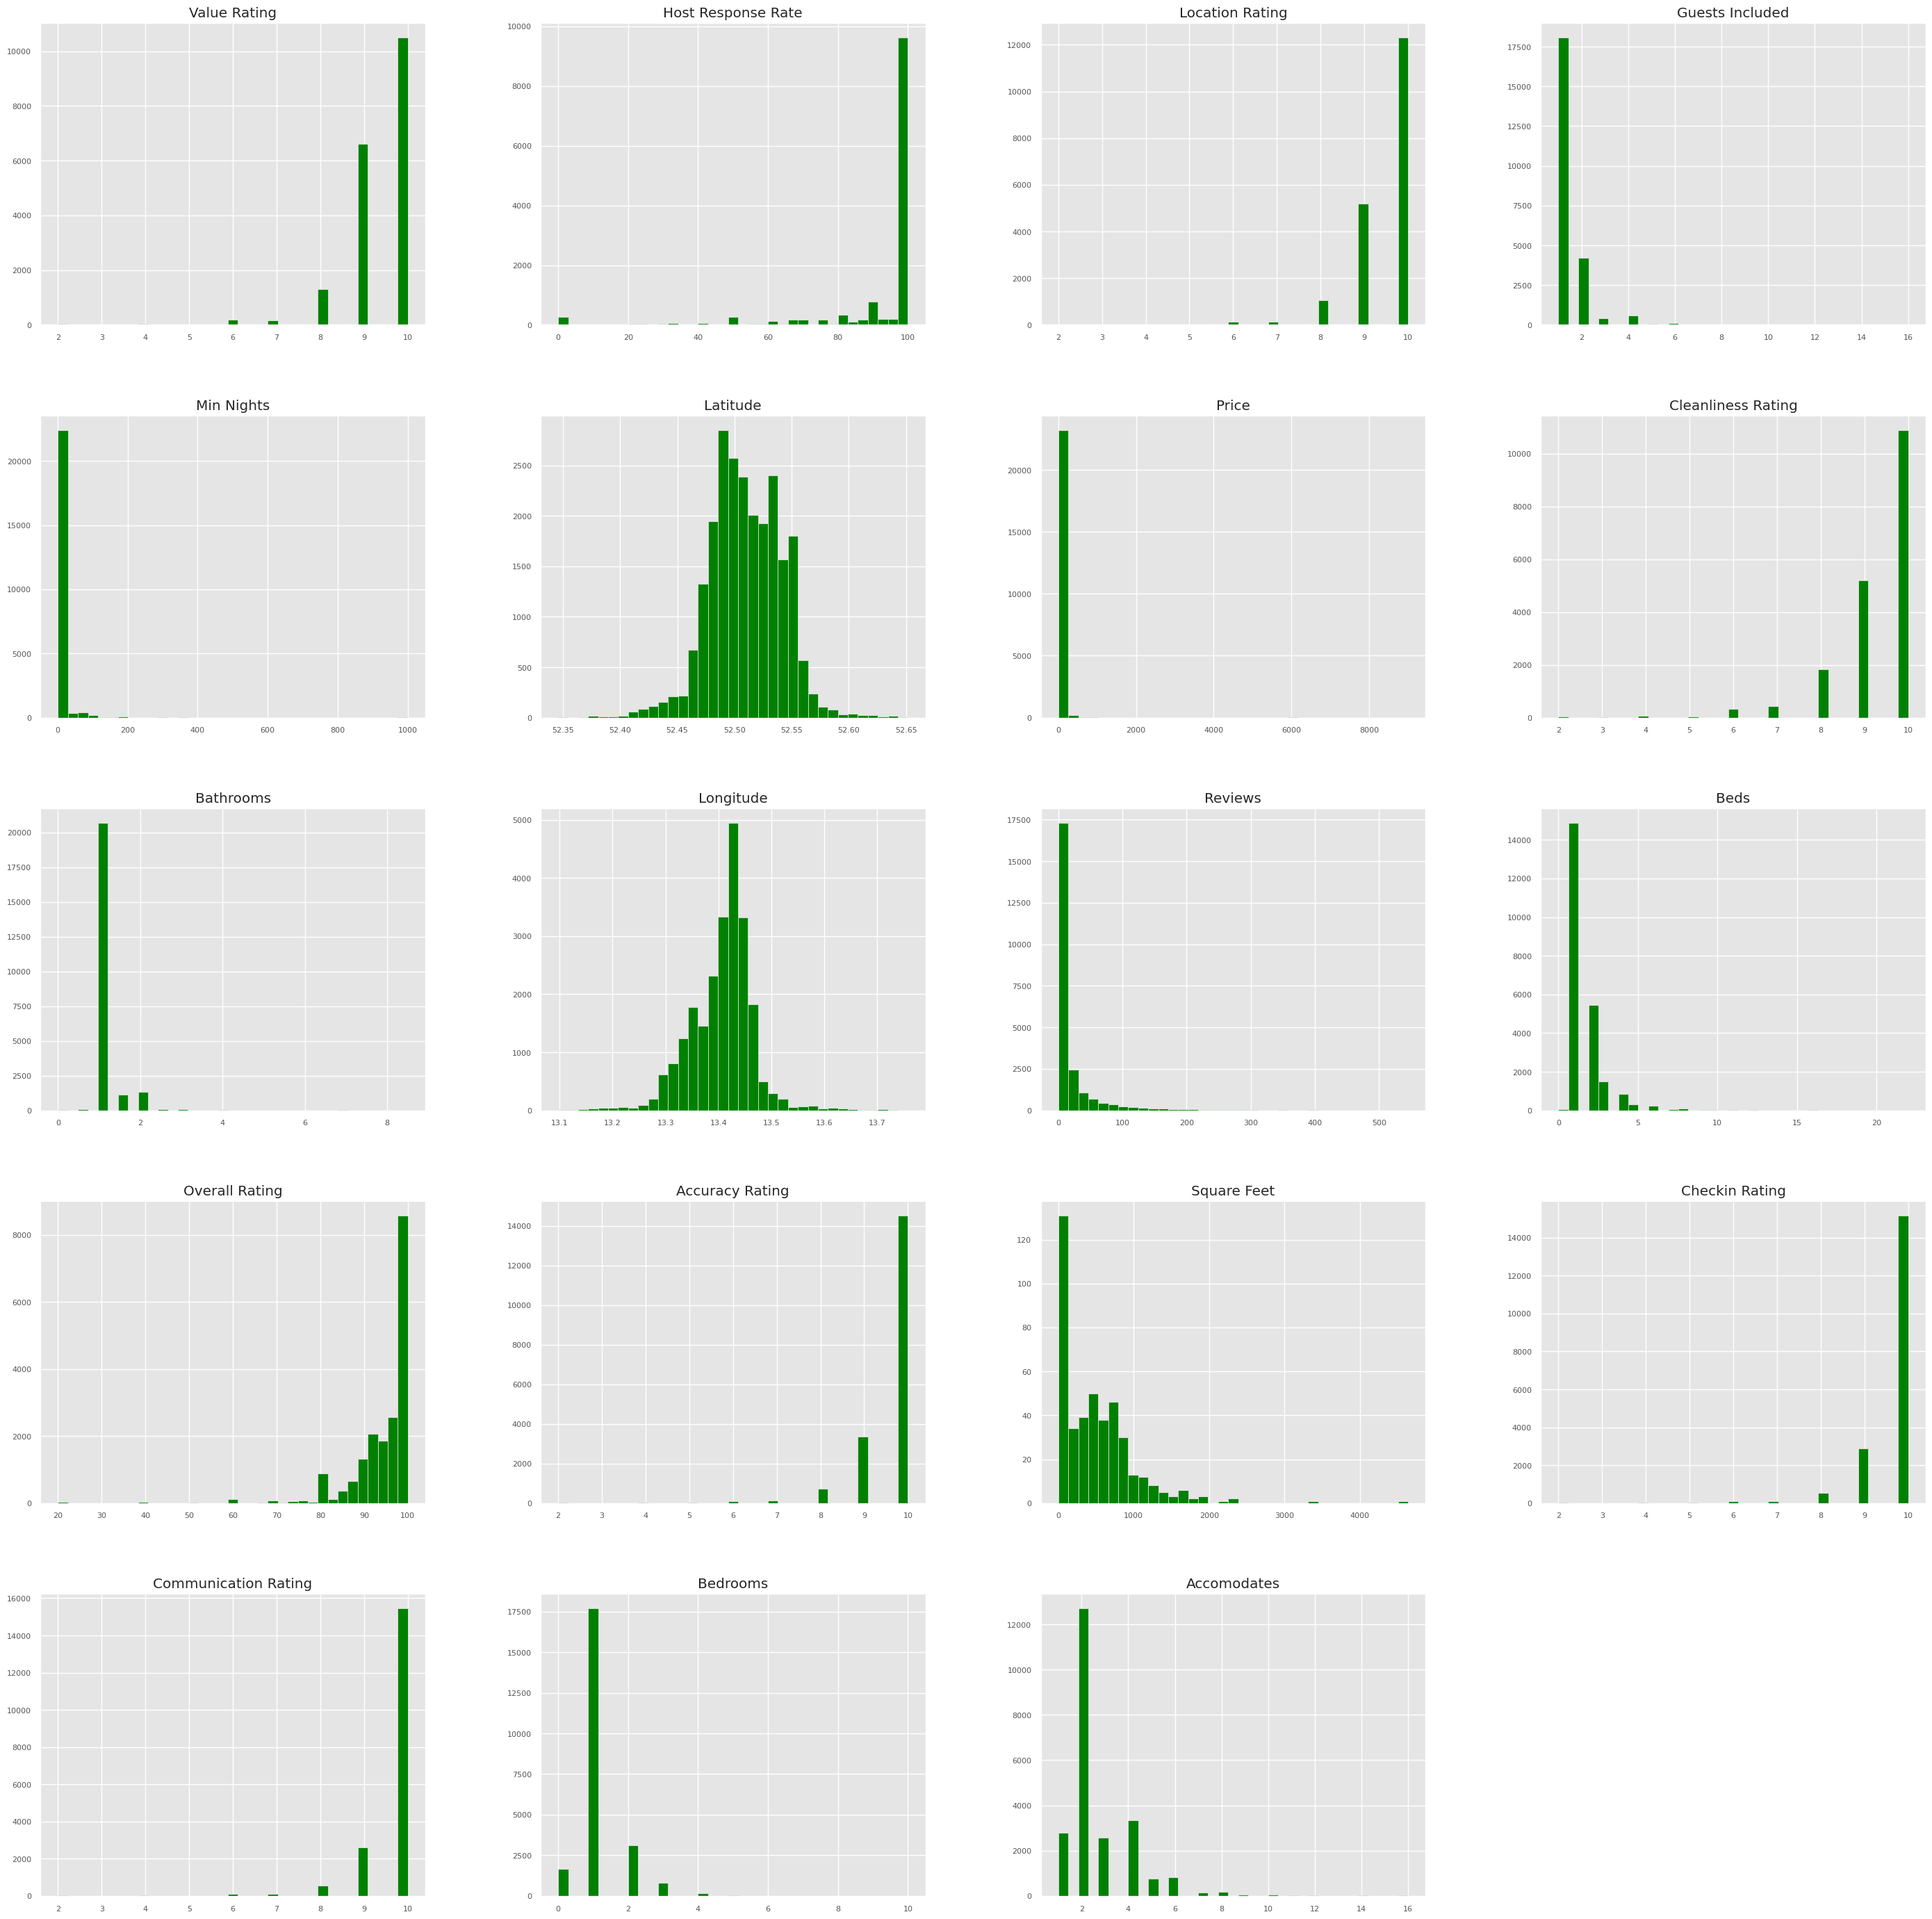

In [114]:
df_num_non_dummy.hist(figsize=(35, 35), bins=35, xlabelsize=8, ylabelsize=8, color = "green");

We can see that data is skewed, let's measure the asymmetry of the distribution:

In [115]:
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    #else
       # return default
pd.DataFrame(df_num_non_dummy.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

we can see in the pink all the columns are positively skewed (skewness > 1), 9 columns.

in the green we can see columns are negativley skewed (skewness < -1), 10 columns.

later we'll see if outliers or missing values can affect the features distribution.

In [116]:
for i in df_dummy.columns:
 print(i)




Is Superhost
Instant Bookable
Is Exact Location


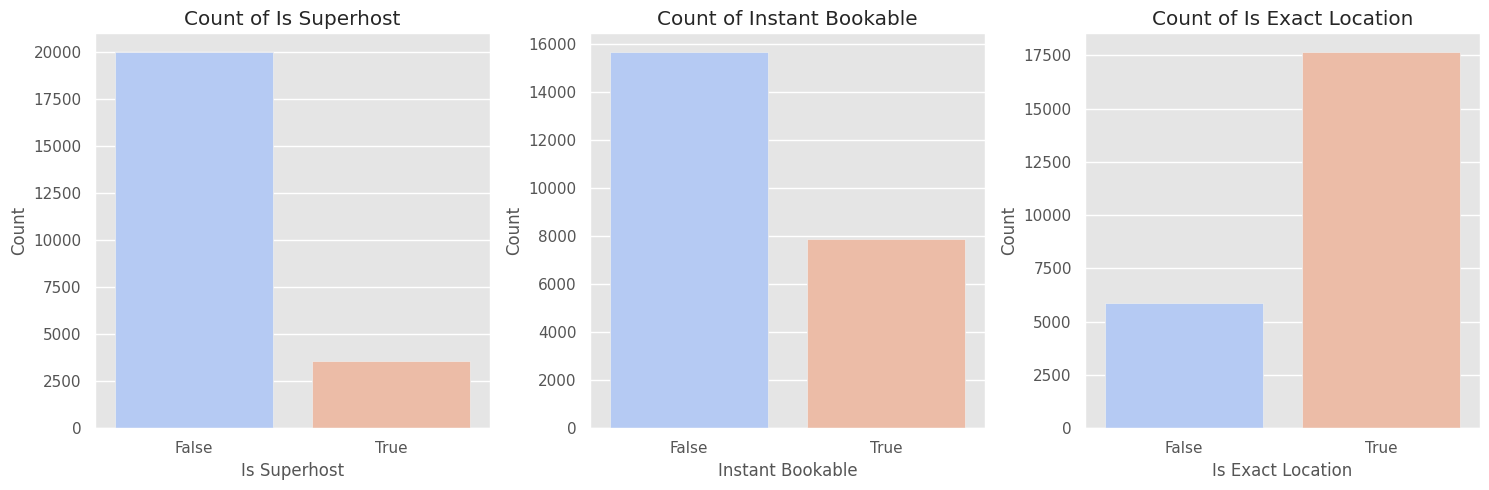

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each column and create a count plot
for i, col in enumerate(df_dummy.columns):
    sns.countplot(x=df_dummy[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [118]:
df_categorial

Room Type    neighbourhood     Neighborhood Group Postal Code  \
0         Private room  Prenzlauer Berg                 Pankow       10437   
1      Entire home/apt  Prenzlauer Berg                 Pankow       10405   
2         Private room  Prenzlauer Berg                 Pankow       10437   
3      Entire home/apt  Prenzlauer Berg                 Pankow       10405   
4      Entire home/apt  Prenzlauer Berg                 Pankow       10437   
...                ...              ...                    ...         ...   
23531  Entire home/apt          Wannsee  Steglitz - Zehlendorf       14109   
23532     Private room            Mitte                 Pankow       13125   
23533     Private room            Britz              NeukÃ¶lln       12347   
23534  Entire home/apt        KÃ¶penick    Treptow - KÃ¶penick       12555   
23535  Entire home/apt       WeiÃensee                 Pankow       13088   

      Property Type  Host Response Time  
0         Apartment        within a day  
1         Apartment        within a day  
2         Apartment      within an hour  
3         Apartment        within a day  
4         Apartment        within a day  
...             ...                 ...  
23531     Apartment  within a few hours  
23532     Apartment                None  
23533     Apartment                None  
23534     Apartment                None  
23535     Apartment                None  

[23536 rows x 6 columns]

In [119]:
df_categorial.shape

(23536, 6)

In [120]:
# a = 8  # number of rows
# b = 1  # number of columns
# c = 1  # plot counter

# fig = plt.figure(figsize=(50,80))
# plt.subplots_adjust(hspace = 0.1)
# sns.set(font_scale = 2.5)
# for i in df_categorial:
# #        plt.subplot(a, b, c)
#         plt.title('{}'.format(i))
#         plt.xlabel(i)
#         sns.countplot(df_categorial[i],palette="coolwarm")
#         c = c + 1

# plt.show()

In [121]:
df['Price'].describe()

count    23536.000000
mean        69.612424
std        216.660408
min          0.000000
25%         32.000000
50%         49.000000
75%         75.000000
max       9000.000000
Name: Price, dtype: float64

we can aee that max price is  9000, but the 75% quantile is 75 ,
so we need to remove the extream values during the outliers phase

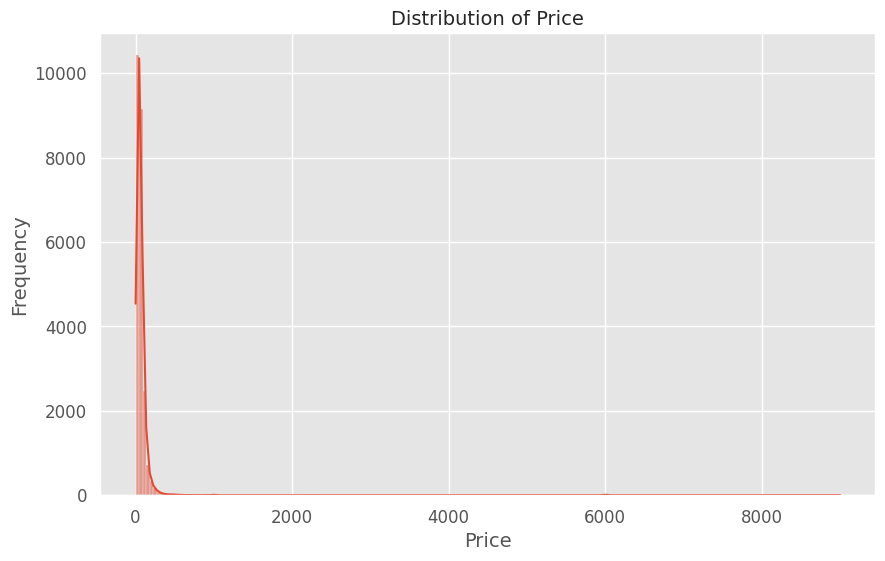

In [122]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=200, kde=True )
plt.title("Distribution of Price",fontsize=14)
plt.xlabel("Price",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.show()

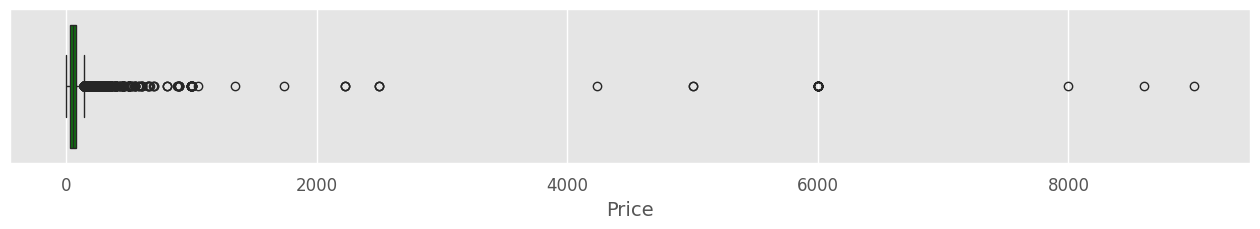

In [123]:
plt.figure(figsize=(16, 2))
sns.boxplot(df['Price'], orient='h',color='green')
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.xlabel("Price",fontsize=14)
plt.show()

In [124]:
df.head()
# corr = df.corr(method = 'spearman')
# corr.style.background_gradient(cmap='coolwarm').set_precision(4)

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0           100.0             10.0                10.0            10.0   
1            92.0              9.0                 9.0             9.0   
2            96.0             10.0                10.0            10.0   
3           100.0             10.0                10.0            10.0   
4            93.0             10.0                10.0             9.0   

   Communication Rating  Location Rating  Value Rating  Price  Square Feet  \
0                  10.0              9.0          10.0   17.0          NaN   
1                   9.0             10.0           9.0   90.0        720.0   
2                  10.0             10.0          10.0   33.0          NaN   
3                  10.0             10.0          10.0  180.0          NaN   
4                  10.0              9.0           9.0   70.0          NaN   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                50.0         False   
1    144.0       1.0   2.0        1.0                50.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        2.5               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2          62   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            7                5           6   
4  52.54785   13.40556            1                1          90   

   Instant Bookable  Is Exact Location Postal Code Property Type  \
0             False               True       10437     Apartment   
1             False               True       10405     Apartment   
2             False               True       10437     Apartment   
3             False              False       10405     Apartment   
4             False               True       10437     Apartment   

  Host Response Time Neighborhood Group    neighbourhood        Room Type  
0       within a day             Pankow  Prenzlauer Berg     Private room  
1       within a day             Pankow  Prenzlauer Berg  Entire home/apt  
2     within an hour             Pankow  Prenzlauer Berg     Private room  
3       within a day             Pankow  Prenzlauer Berg  Entire home/apt  
4       within a day             Pankow  Prenzlauer Berg  Entire home/apt

### Missing values

Dataframe containing missing value counts and their frequency:

In [125]:
df_nulls = df.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Square Feet  \
0                      10.0              9.0          10.0          NaN   
1                       9.0             10.0           9.0        720.0   
2                      10.0             10.0          10.0          NaN   
3                      10.0             10.0          10.0          NaN   
4                      10.0              9.0           9.0          NaN   
...                     ...              ...           ...          ...   
23531                   NaN              NaN           NaN          NaN   
23532                   NaN              NaN           NaN          NaN   
23533                   NaN              NaN           NaN          NaN   
23534                   NaN              NaN           NaN          NaN   
23535                   NaN              NaN           NaN          NaN   

       Bedrooms  Beds  Bathrooms  Host Response Rate  Host Response Time  
0           1.0   1.0        1.0                50.0        within a day  
1           1.0   2.0        1.0                50.0        within a day  
2           1.0   2.0        1.0               100.0      within an hour  
3           4.0   7.0        2.5               100.0        within a day  
4           0.0   1.0        1.0               100.0        within a day  
...         ...   ...        ...                 ...                 ...  
23531       1.0   2.0        1.0                75.0  within a few hours  
23532       2.0   2.0        1.0                 NaN                None  
23533       1.0   1.0        1.5                 NaN                None  
23534       3.0   4.0        1.0                 NaN                None  
23535       2.0   2.0        1.0                 NaN                None  

[23536 rows x 13 columns]

In [126]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Square Feet                    23111               98.2
Host Response Rate             10490               44.6
Host Response Time             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
Beds                              35                0.1
Bathrooms                         29                0.1
Bedrooms                          20                0.1

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [127]:
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
count    23536.000000     23536.000000        23536.000000    23536.000000   
mean         0.196380         0.197485            0.197315        0.198249   
std          0.397268         0.398110            0.397980        0.398690   
min          0.000000         0.000000            0.000000        0.000000   
25%          0.000000         0.000000            0.000000        0.000000   
50%          0.000000         0.000000            0.000000        0.000000   
75%          0.000000         0.000000            0.000000        0.000000   
max          1.000000         1.000000            1.000000        1.000000   

       Communication Rating  Location Rating  Value Rating    Price  \
count          23536.000000     23536.000000  23536.000000  23536.0   
mean               0.197570         0.198207      0.198334      0.0   
std                0.398174         0.398657      0.398754      0.0   
min                0.000000         0.000000      0.000000      0.0   
25%                0.000000         0.000000      0.000000      0.0   
50%                0.000000         0.000000      0.000000      0.0   
75%                0.000000         0.000000      0.000000      0.0   
max                1.000000         1.000000      1.000000      0.0   

        Square Feet  Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.000000  23536.0  23536.000000  23536.000000  23536.000000   
mean       0.981943      0.0      0.000850      0.001487      0.001232   
std        0.133162      0.0      0.029139      0.038535      0.035081   
min        0.000000      0.0      0.000000      0.000000      0.000000   
25%        1.000000      0.0      0.000000      0.000000      0.000000   
50%        1.000000      0.0      0.000000      0.000000      0.000000   
75%        1.000000      0.0      0.000000      0.000000      0.000000   
max        1.000000      0.0      1.000000      1.000000      1.000000   

       Host Response Rate  Is Superhost  Latitude  Longitude  Accomodates  \
count        23536.000000       23536.0   23536.0    23536.0      23536.0   
mean             0.445700           0.0       0.0        0.0          0.0   
std              0.497053           0.0       0.0        0.0          0.0   
min              0.000000           0.0       0.0        0.0          0.0   
25%              0.000000           0.0       0.0        0.0          0.0   
50%              0.000000           0.0       0.0        0.0          0.0   
75%              1.000000           0.0       0.0        0.0          0.0   
max              1.000000           0.0       0.0        0.0          0.0   

       Guests Included  Min Nights  Instant Bookable  Is Exact Location  \
count          23536.0     23536.0           23536.0            23536.0   
mean               0.0         0.0               0.0                0.0   
std                0.0         0.0               0.0                0.0   
min                0.0         0.0               0.0                0.0   
25%                0.0         0.0               0.0                0.0   
50%                0.0         0.0               0.0                0.0   
75%                0.0         0.0               0.0                0.0   
max                0.0         0.0               0.0                0.0   

       Postal Code  Property Type  Host Response Time  Neighborhood Group  \
count      23536.0        23536.0        23536.000000             23536.0   
mean           0.0            0.0            0.445700                 0.0   
std            0.0            0.0            0.497053                 0.0   
min            0.0            0.0            0.000000                 0.0   
25%            0.0            0.0            0.000000                 0.0   
50%            0.0            0.0            0.000000                 0.0   
75%            0.0            0.0            1.000000                 0.0   
max        

### Catigories

In [128]:
df_categorial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Room Type           23536 non-null  object
 1   neighbourhood       23536 non-null  object
 2   Neighborhood Group  23536 non-null  object
 3   Postal Code         23536 non-null  object
 4   Property Type       23536 non-null  object
 5   Host Response Time  13046 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


In [129]:
df_categorial.describe().T

count unique                       top   freq
Room Type           23536      3              Private room  11694
neighbourhood       23536     93                 NeukÃ¶lln   3444
Neighborhood Group  23536     12  Friedrichshain-Kreuzberg   5726
Postal Code         23536    207                     10245    928
Property Type       23536     35                 Apartment  20935
Host Response Time  13046      4            within an hour   6816

In [130]:
# i = 1
# plt.figure(figsize=(40, 40))
# plt.subplots_adjust(hspace = 0.5)
# for col in df_categorial.columns:
#   plt.subplot(5, 2, i)
#   plt.title(f"Distribution of `{col}`", fontsize=12, fontweight="bold")
#   plt.xlabel(col, fontsize=10)
#   plt.xticks(rotation=50, fontsize=14)
#   plt.ylabel("Count")
#   sns.countplot(data=df, x=col, palette="plasma")
#   i = i + 1

# plt.tight_layout()
# plt.show()

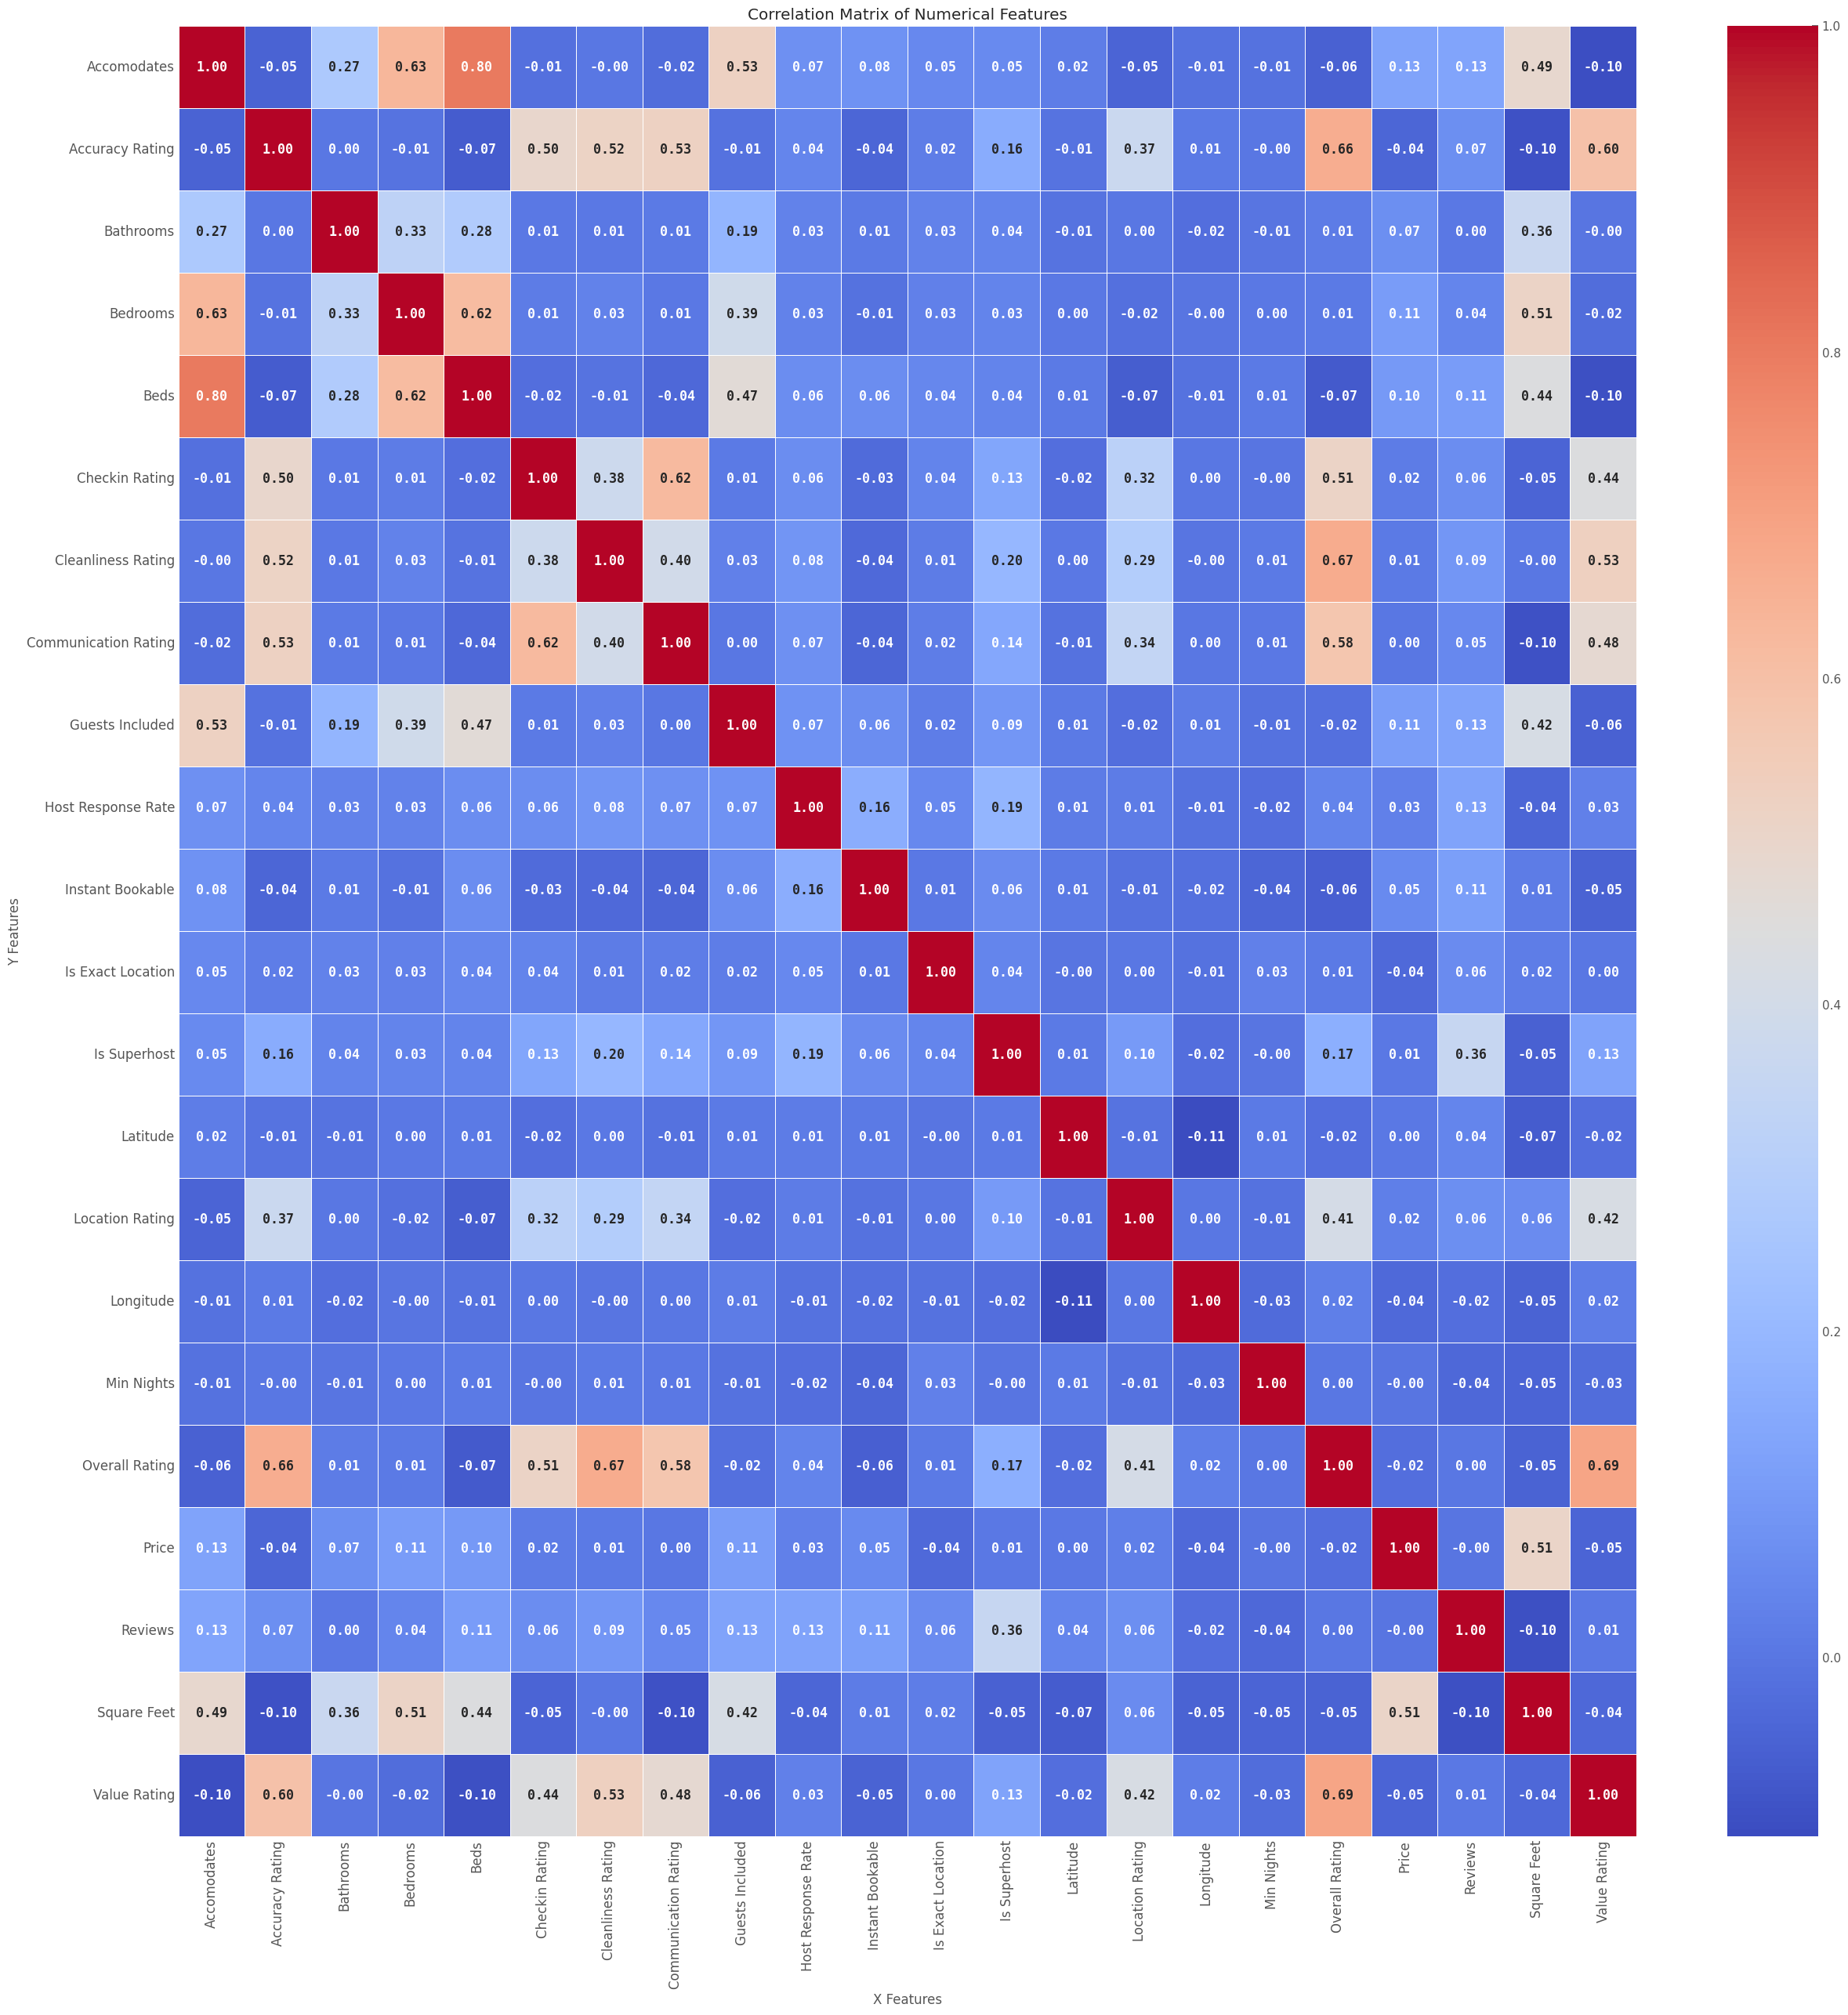

In [131]:
plt.style.use('bmh')
plt.figure(figsize=(30, 30))
correlation_matrix = df[df_num.union(df_dummy.columns)].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5 , annot_kws={"size": 12, "weight": "bold", "family": "monospace"})
plt.xlabel("X Features", fontsize=12)
plt.ylabel("Y Features", fontsize=12)
plt.title("Heatmap Example", fontsize=12)
plt.title("Correlation Matrix of Numerical Features")
plt.tick_params(axis='both', labelsize=12)
plt.show()

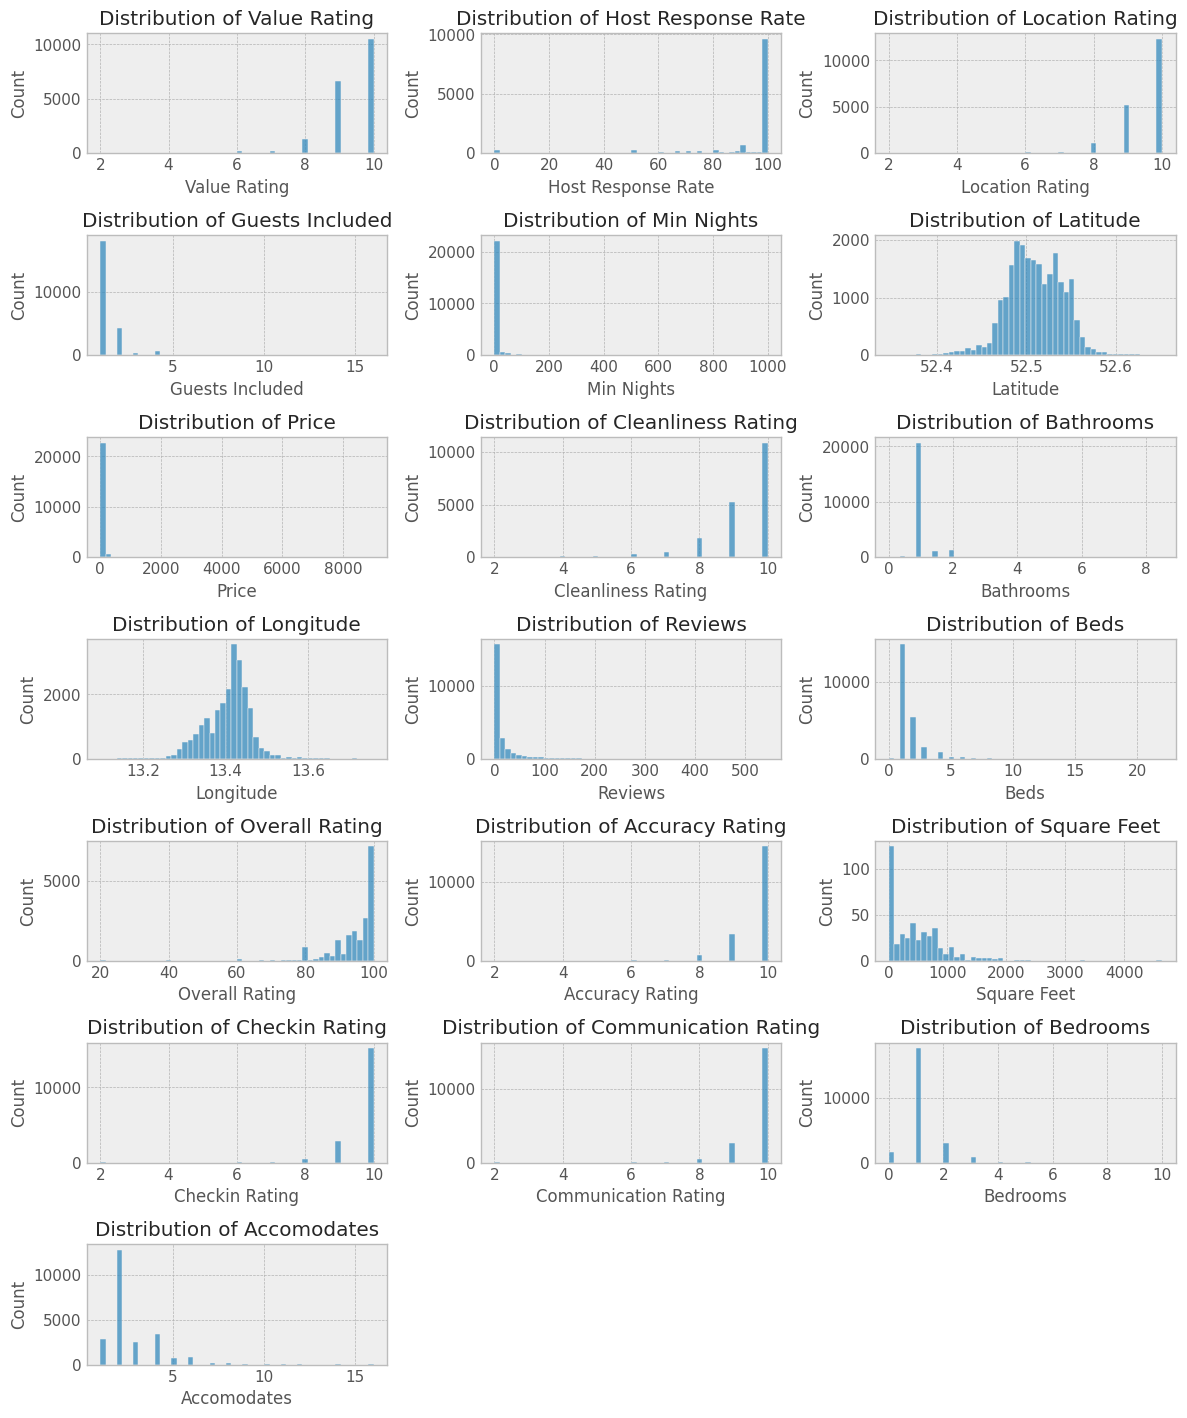

In [132]:
plt.figure(figsize=(12, 30))
plt.subplots_adjust(hspace = 0.5)
for i, col in enumerate(df_num_non_dummy, 1):
  plt.subplot(15, 3, i)
  sns.histplot(df[col].dropna(), bins=50, kde=False)
  plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

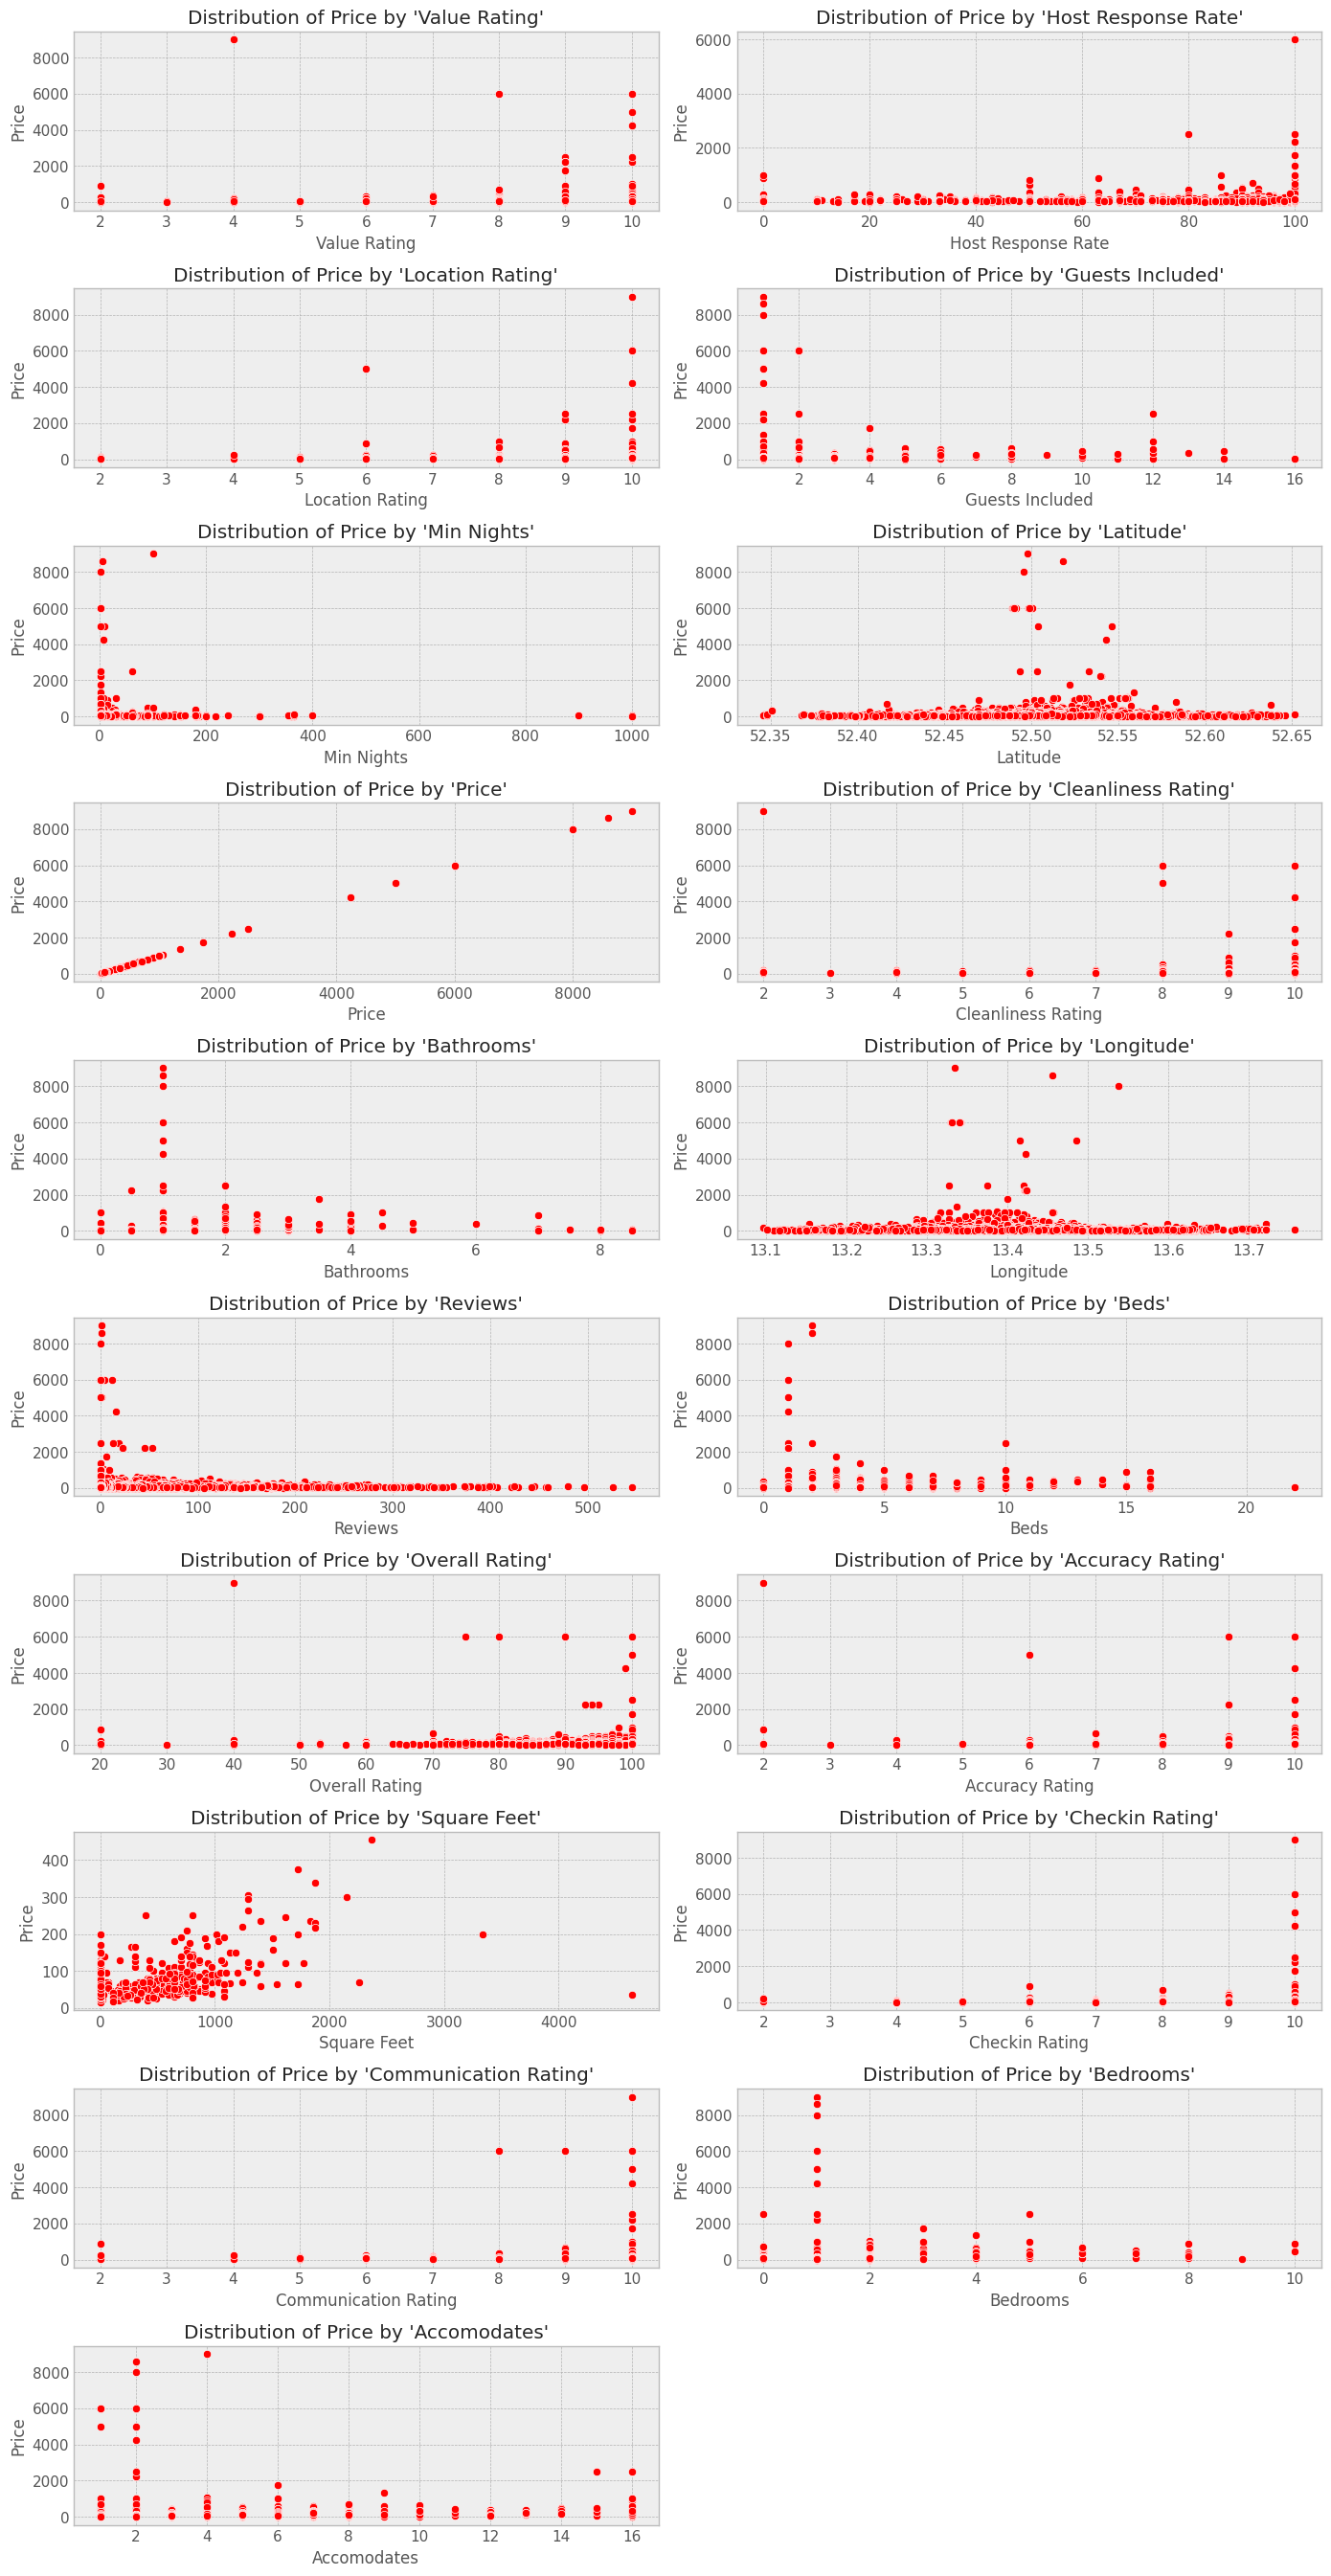

In [133]:
plt.figure(figsize=(14, 40))
plt.subplots_adjust(hspace = 0.5)
i = 1
for col in df_num_non_dummy.columns:
  plt.subplot(15, 2, i)
  sns.scatterplot(x=df[col], y=df['Price'], color='red')
  plt.title(f"Distribution of Price by '{col}'")
  i = i + 1
plt.tight_layout()
plt.show()

In [134]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# for col in df_categorial:
#   df[f"{col} Encoded"] = le.fit_transform(df[col])

# df.drop(columns=df_categorial.columns, inplace=True)
# df.head()


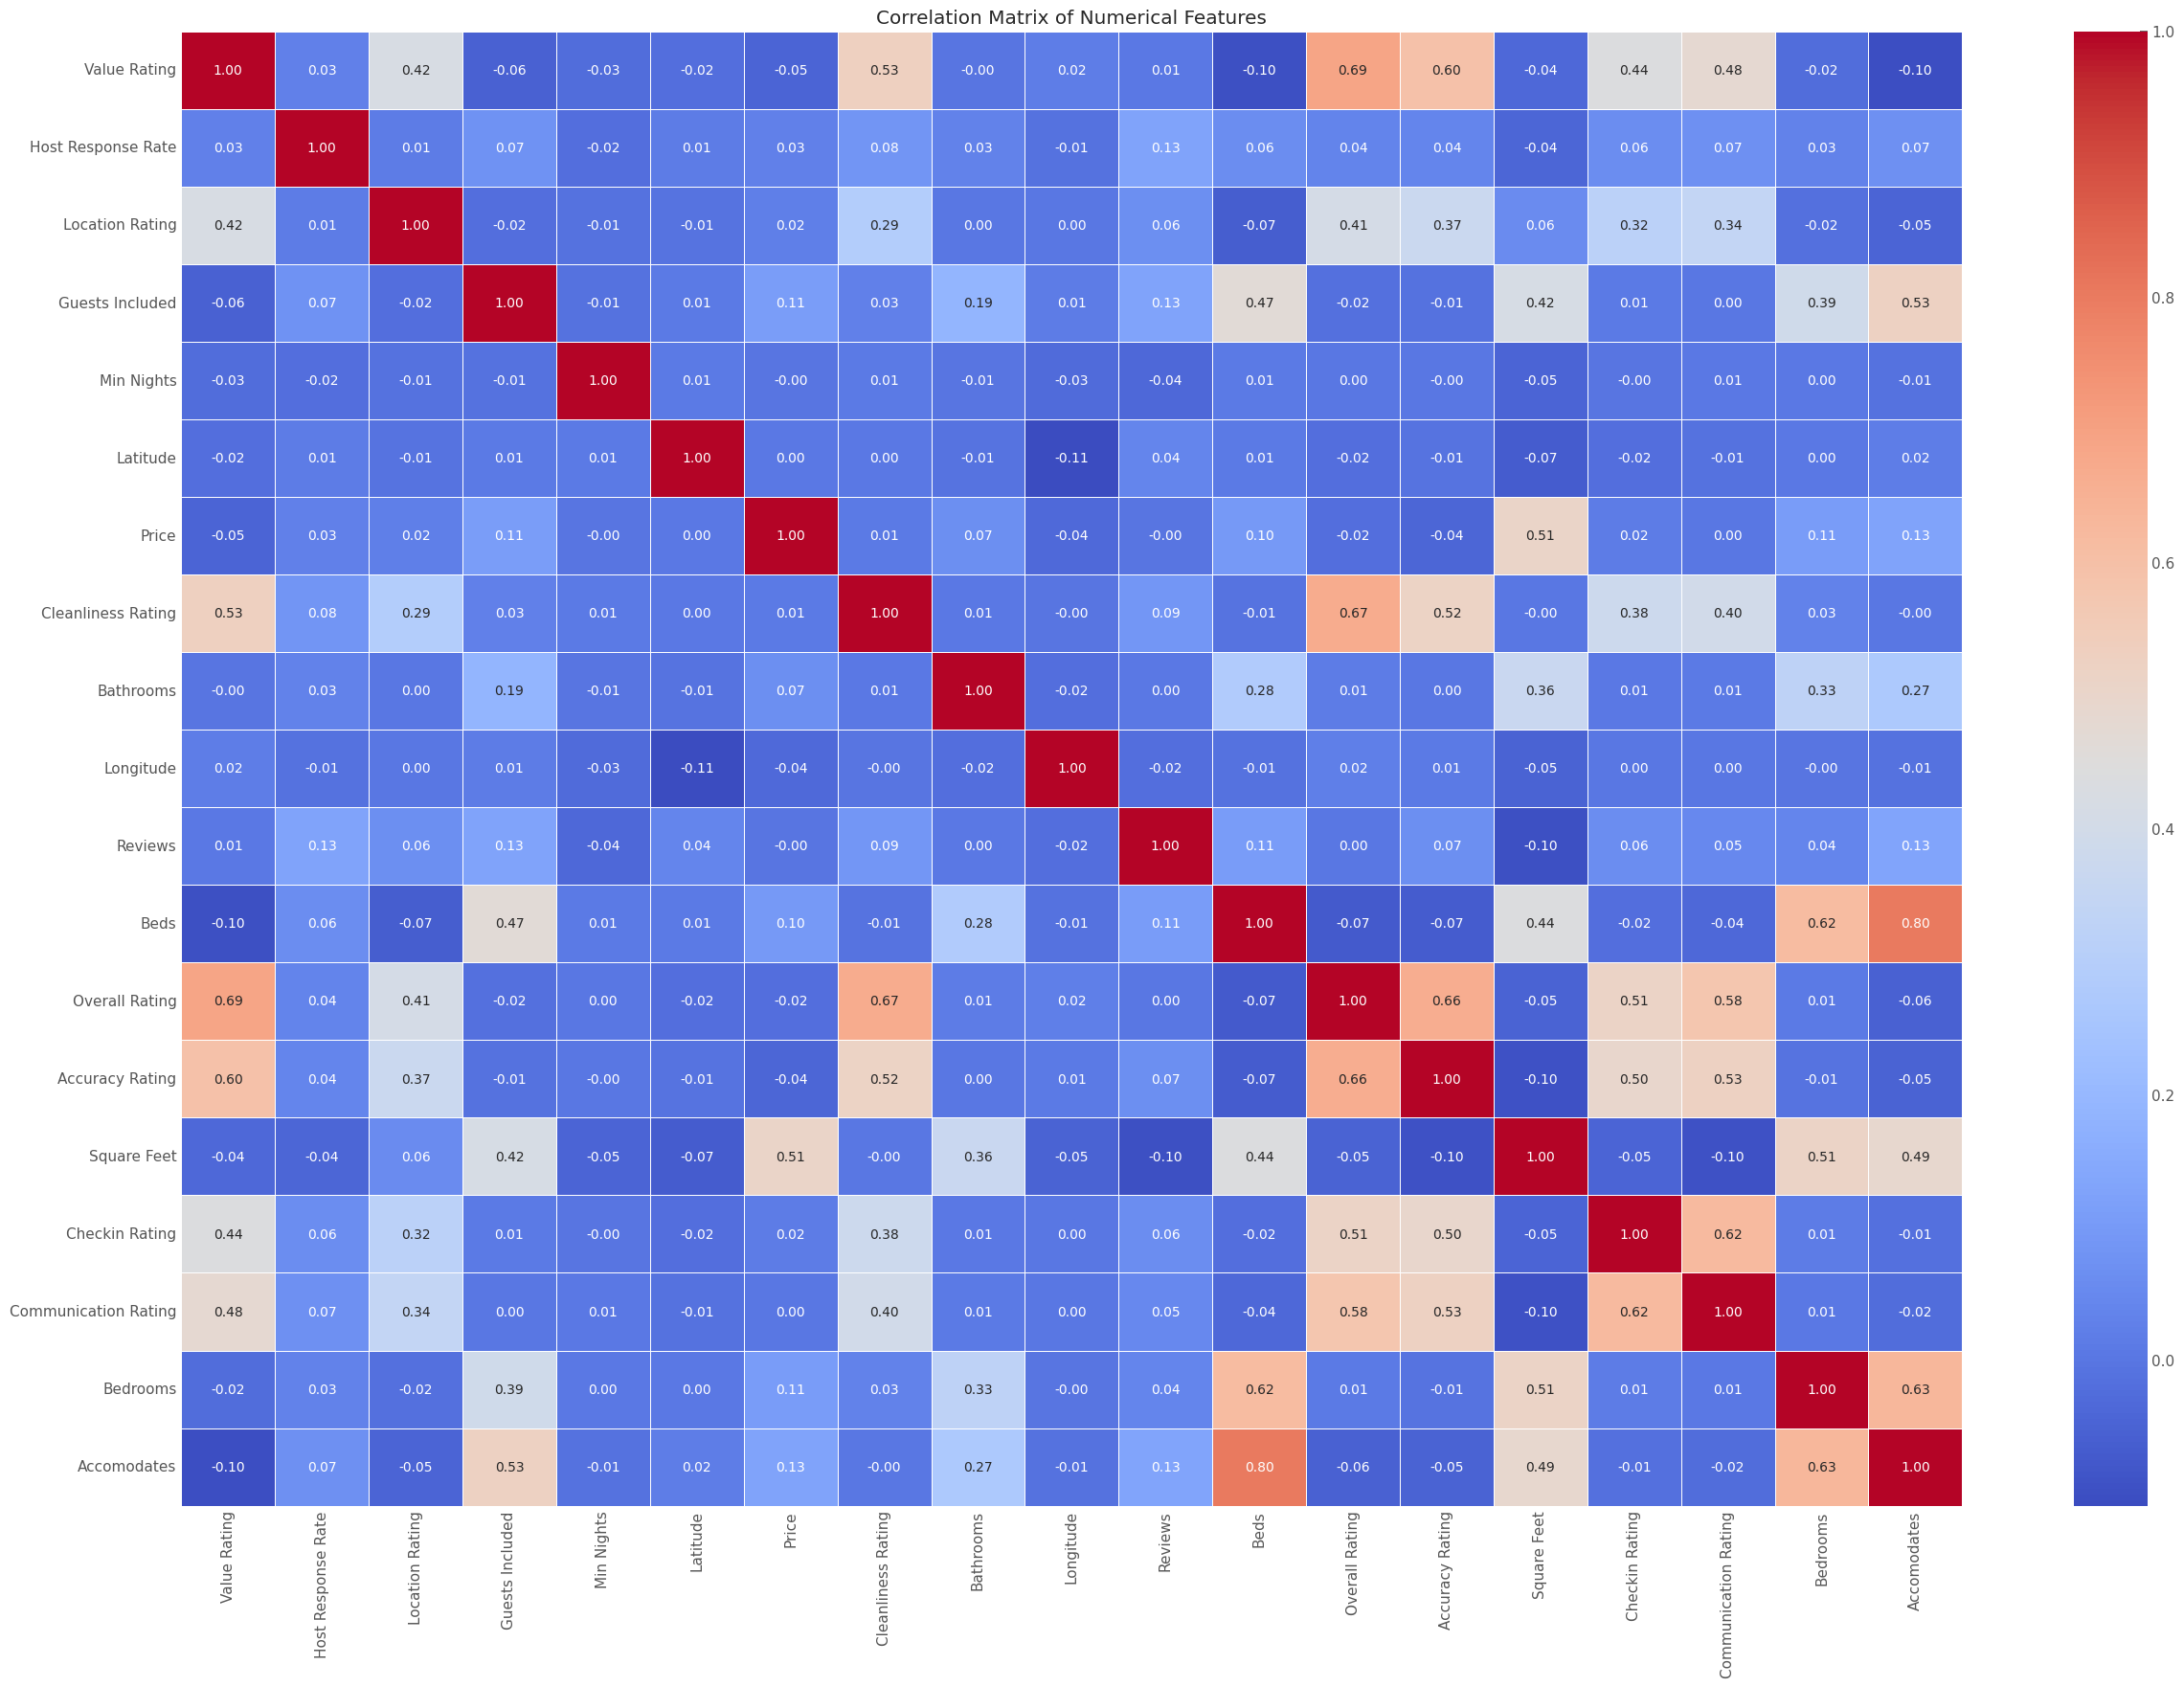

In [135]:
plt.figure(figsize=(30, 20))
correlation_matrix = df_num_non_dummy.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [136]:
corr = df_num_non_dummy.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

In [137]:
from scipy import stats
df_corr= pd.DataFrame(columns=('v1','v2','abscorr','origcorr','pval'))

for i in df_num:
        for j in df_num:
                if i > j:
                        a=stats.spearmanr(df[i], df[j],nan_policy='omit')
                        b="{}/{}".format(i,j)
                        df_corr.loc[b] =[i,j,abs(a[0]),a[0],a[1]]

df_corr_filtered= df_corr.loc[(df_corr['abscorr']>0.7 ) & (df_corr['pval']<0.05)]
df_corr_filtered.sort_values(by=['abscorr'],ascending=False)

v1           v2   abscorr  origcorr  pval
Beds/Accomodates  Beds  Accomodates  0.718802  0.718802   0.0

### Outliers


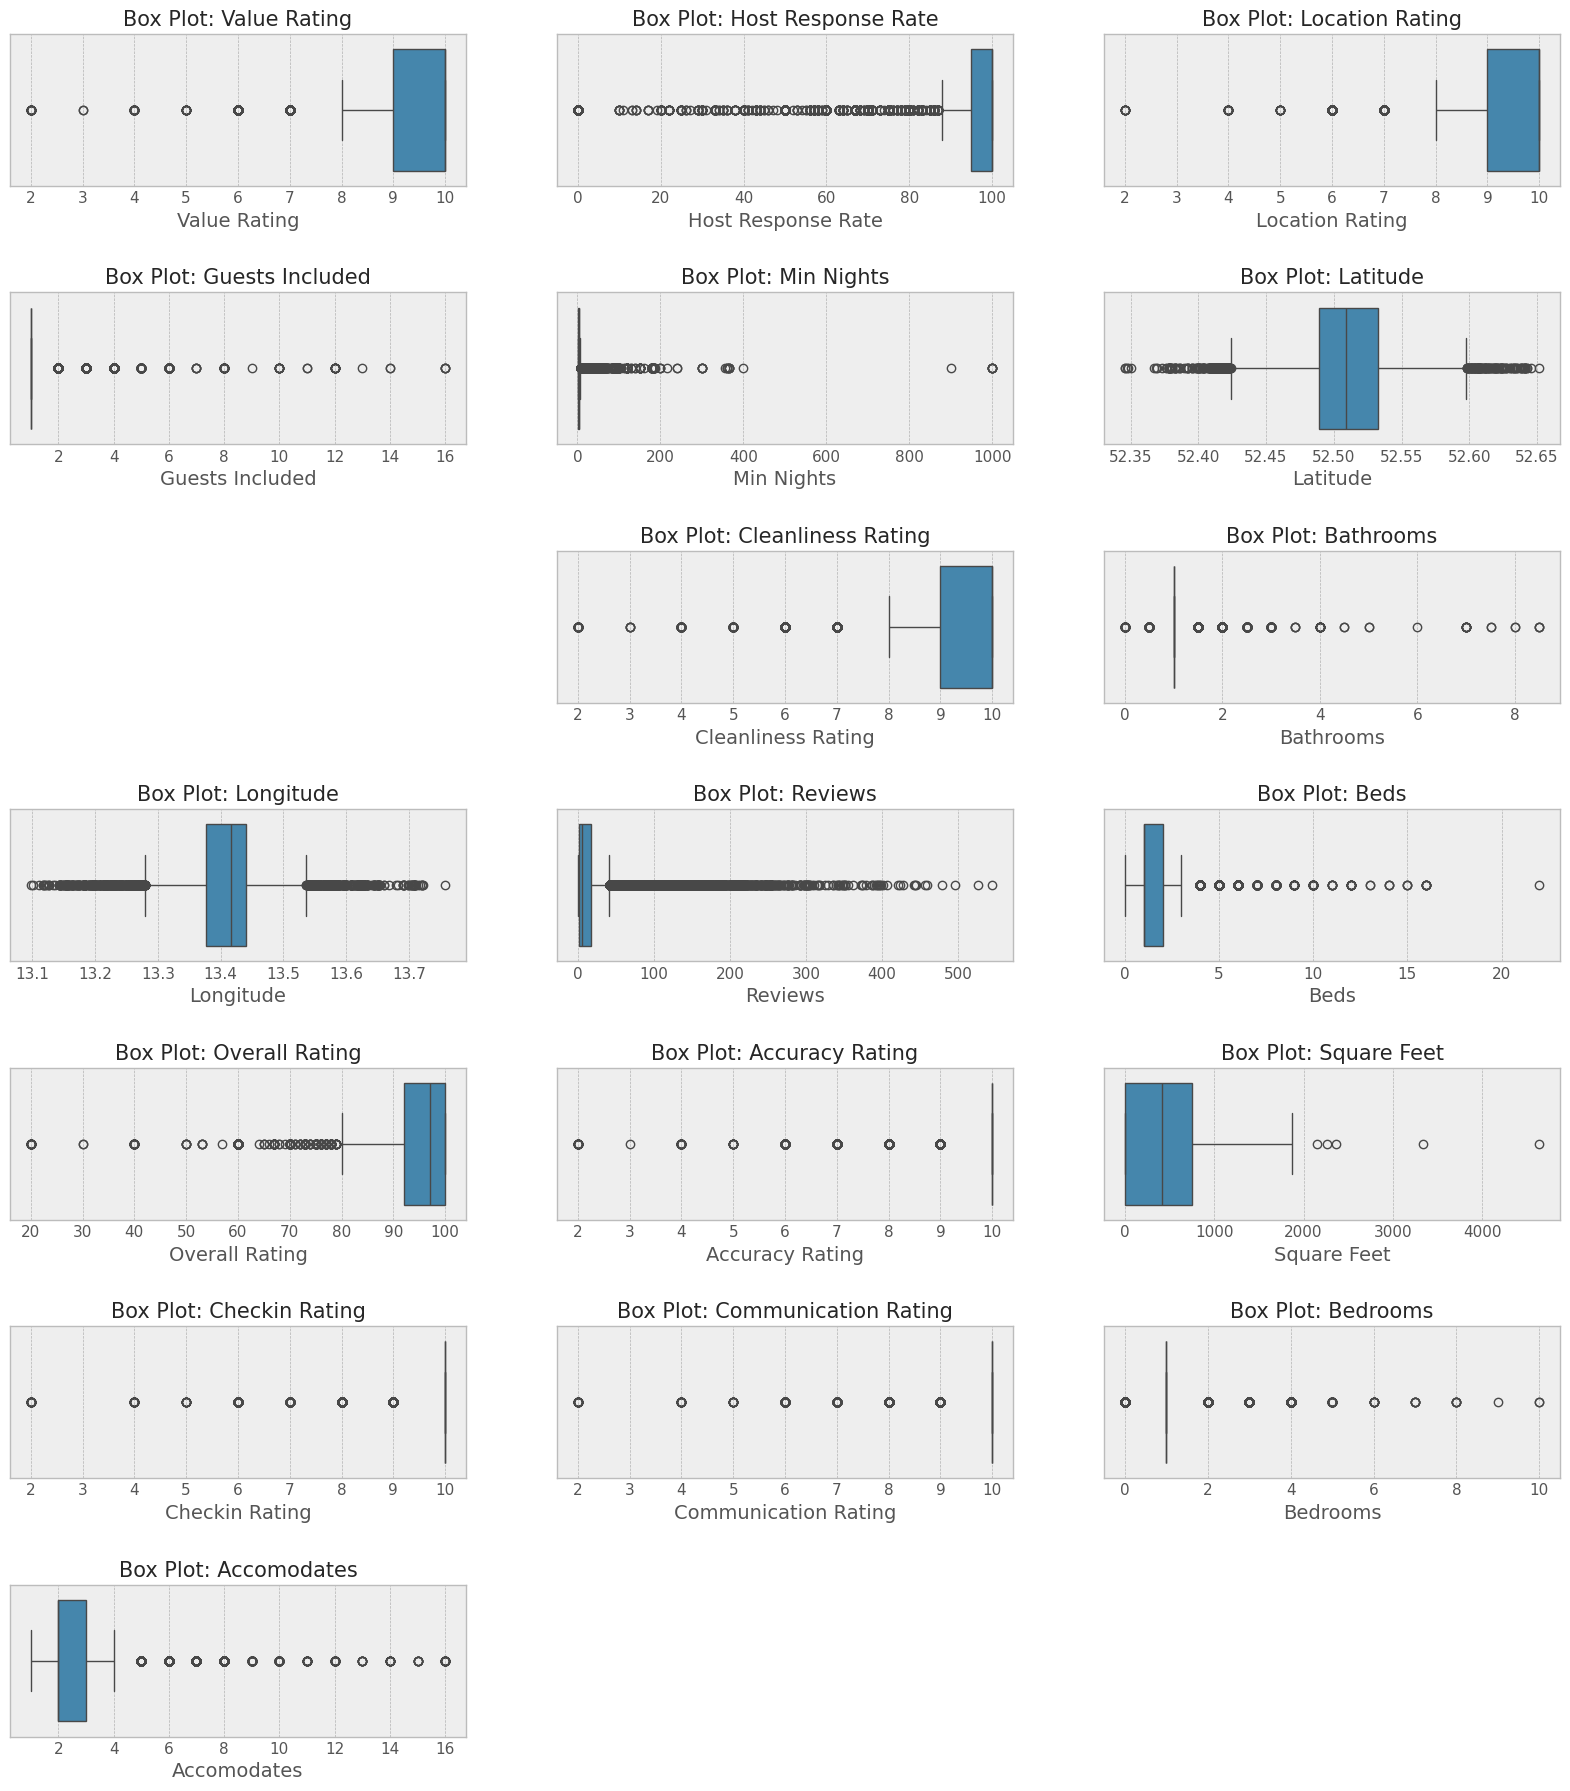

In [138]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'Price':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

from the BoxPlot diagram we can see there are OutLiers that needs to be addressed.

Price: Ignored as it is the target value
Reviews: Some listings have significantly higher review counts than others.
Bedrooms, Bathrooms, Beds, Accommodates: Some properties might have unrealistic values (e.g., too many or too few bedrooms relative to accommodations).

### Missing values

In [139]:
df_nulls = df.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Square Feet  \
0                      10.0              9.0          10.0          NaN   
1                       9.0             10.0           9.0        720.0   
2                      10.0             10.0          10.0          NaN   
3                      10.0             10.0          10.0          NaN   
4                      10.0              9.0           9.0          NaN   
...                     ...              ...           ...          ...   
23531                   NaN              NaN           NaN          NaN   
23532                   NaN              NaN           NaN          NaN   
23533                   NaN              NaN           NaN          NaN   
23534                   NaN              NaN           NaN          NaN   
23535                   NaN              NaN           NaN          NaN   

       Bedrooms  Beds  Bathrooms  Host Response Rate  Host Response Time  
0           1.0   1.0        1.0                50.0        within a day  
1           1.0   2.0        1.0                50.0        within a day  
2           1.0   2.0        1.0               100.0      within an hour  
3           4.0   7.0        2.5               100.0        within a day  
4           0.0   1.0        1.0               100.0        within a day  
...         ...   ...        ...                 ...                 ...  
23531       1.0   2.0        1.0                75.0  within a few hours  
23532       2.0   2.0        1.0                 NaN                None  
23533       1.0   1.0        1.5                 NaN                None  
23534       3.0   4.0        1.0                 NaN                None  
23535       2.0   2.0        1.0                 NaN                None  

[23536 rows x 13 columns]

<Axes: >

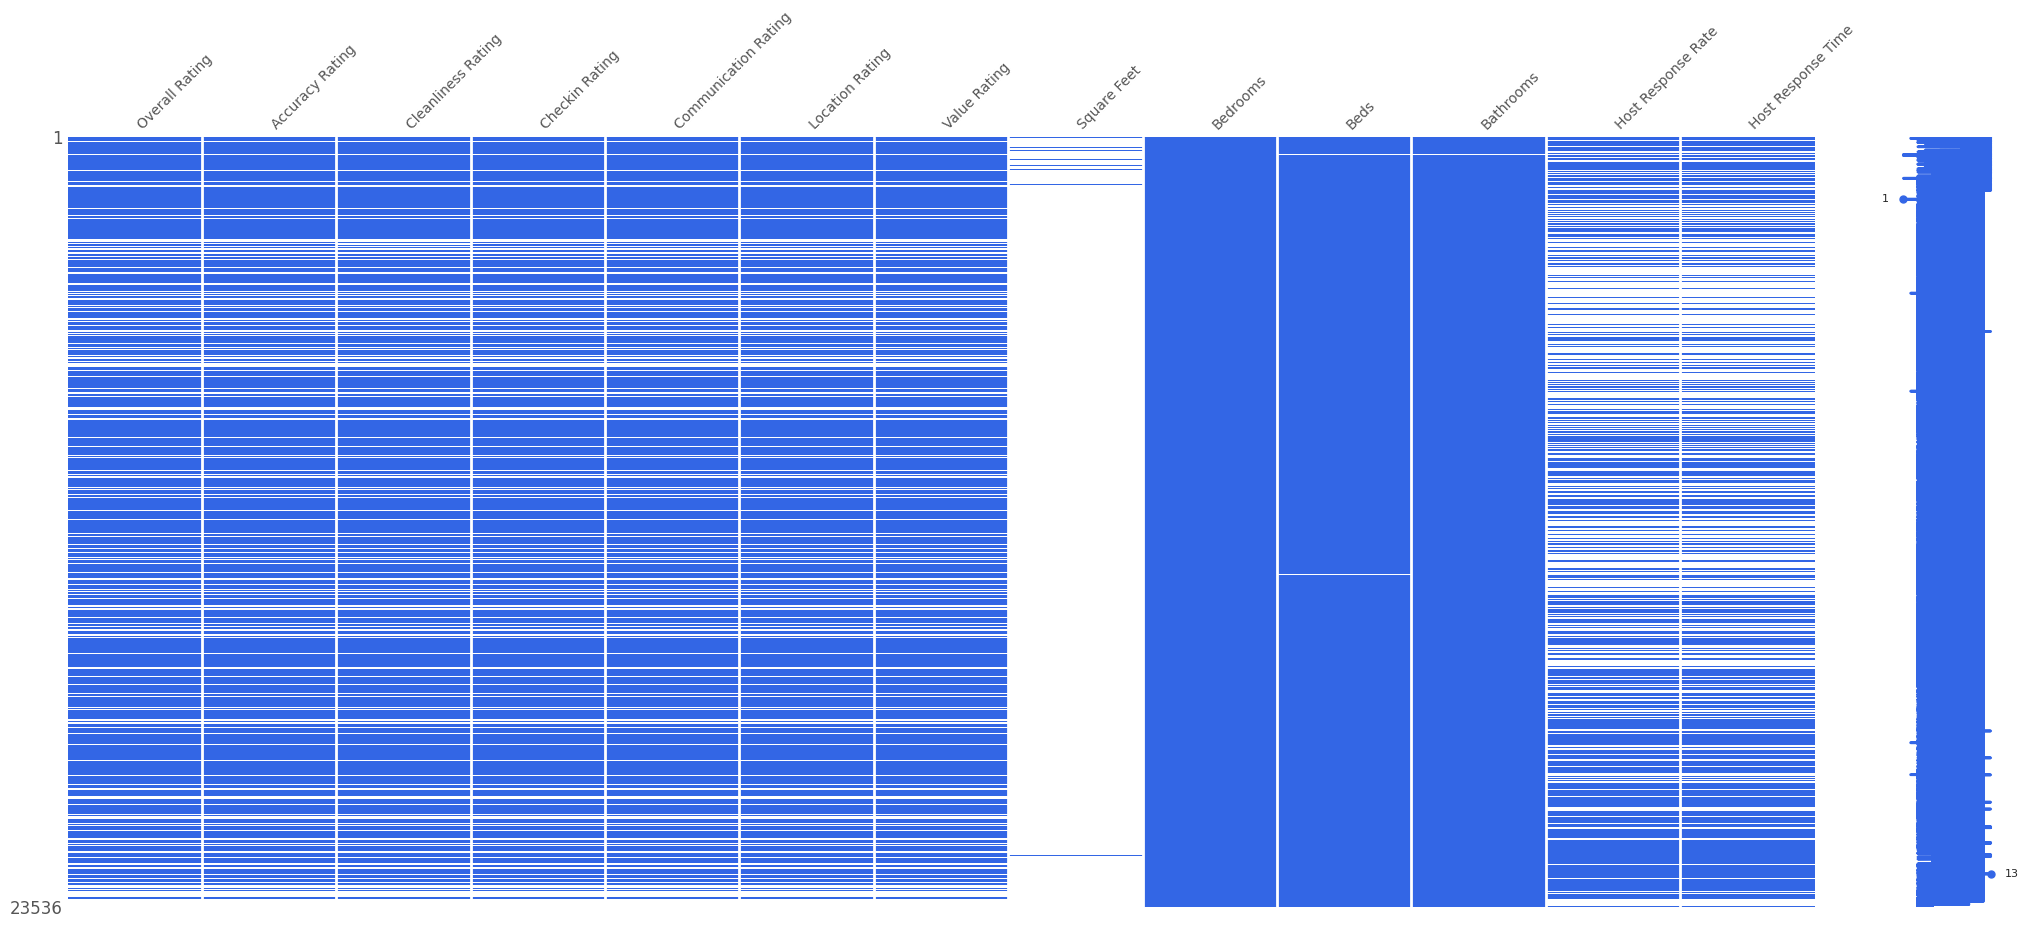

In [140]:
msno.matrix(df_nulls,color=(0.2, 0.4, 0.9),fontsize=10)

Dataframe containing missing value counts and their frequency:

In [141]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_per
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Square Feet                    23111               98.2
Host Response Rate             10490               44.6
Host Response Time             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
Beds                              35                0.1
Bathrooms                         29                0.1
Bedrooms                          20                0.1

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [142]:
pd.set_option('display.max_columns', None)
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
count    23536.000000     23536.000000        23536.000000    23536.000000   
mean         0.196380         0.197485            0.197315        0.198249   
std          0.397268         0.398110            0.397980        0.398690   
min          0.000000         0.000000            0.000000        0.000000   
25%          0.000000         0.000000            0.000000        0.000000   
50%          0.000000         0.000000            0.000000        0.000000   
75%          0.000000         0.000000            0.000000        0.000000   
max          1.000000         1.000000            1.000000        1.000000   

       Communication Rating  Location Rating  Value Rating    Price  \
count          23536.000000     23536.000000  23536.000000  23536.0   
mean               0.197570         0.198207      0.198334      0.0   
std                0.398174         0.398657      0.398754      0.0   
min                0.000000         0.000000      0.000000      0.0   
25%                0.000000         0.000000      0.000000      0.0   
50%                0.000000         0.000000      0.000000      0.0   
75%                0.000000         0.000000      0.000000      0.0   
max                1.000000         1.000000      1.000000      0.0   

        Square Feet  Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.000000  23536.0  23536.000000  23536.000000  23536.000000   
mean       0.981943      0.0      0.000850      0.001487      0.001232   
std        0.133162      0.0      0.029139      0.038535      0.035081   
min        0.000000      0.0      0.000000      0.000000      0.000000   
25%        1.000000      0.0      0.000000      0.000000      0.000000   
50%        1.000000      0.0      0.000000      0.000000      0.000000   
75%        1.000000      0.0      0.000000      0.000000      0.000000   
max        1.000000      0.0      1.000000      1.000000      1.000000   

       Host Response Rate  Is Superhost  Latitude  Longitude  Accomodates  \
count        23536.000000       23536.0   23536.0    23536.0      23536.0   
mean             0.445700           0.0       0.0        0.0          0.0   
std              0.497053           0.0       0.0        0.0          0.0   
min              0.000000           0.0       0.0        0.0          0.0   
25%              0.000000           0.0       0.0        0.0          0.0   
50%              0.000000           0.0       0.0        0.0          0.0   
75%              1.000000           0.0       0.0        0.0          0.0   
max              1.000000           0.0       0.0        0.0          0.0   

       Guests Included  Min Nights  Instant Bookable  Is Exact Location  \
count          23536.0     23536.0           23536.0            23536.0   
mean               0.0         0.0               0.0                0.0   
std                0.0         0.0               0.0                0.0   
min                0.0         0.0               0.0                0.0   
25%                0.0         0.0               0.0                0.0   
50%                0.0         0.0               0.0                0.0   
75%                0.0         0.0               0.0                0.0   
max                0.0         0.0               0.0                0.0   

       Postal Code  Property Type  Host Response Time  Neighborhood Group  \
count      23536.0        23536.0        23536.000000             23536.0   
mean           0.0            0.0            0.445700                 0.0   
std            0.0            0.0            0.497053                 0.0   
min            0.0            0.0            0.000000                 0.0   
25%            0.0            0.0            0.000000                 0.0   
50%            0.0            0.0            0.000000                 0.0   
75%            0.0            0.0            1.000000                 0.0   
max        

### Data Cleansing

<Axes: >

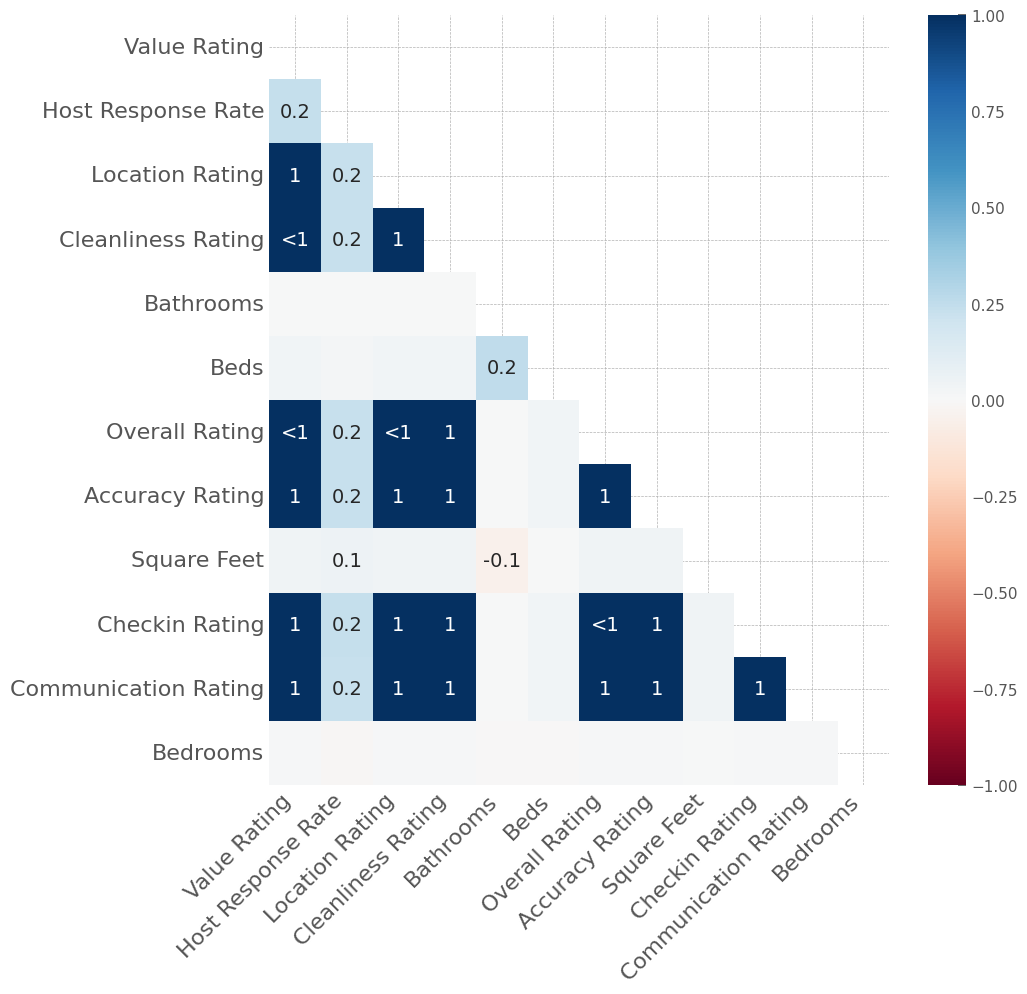

In [143]:
msno.heatmap(df_num_non_dummy,figsize=(10,10))

### outliers_df
The data is skewed and not normaly distributed, we'll use the IQR method to identify outliers to set up a boundary before Q1 and after Q3. Any values that fall outside of this boundary are considered outliers:

In [144]:
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df:  # Ensure processing numeric columns only
      if (col != "Price"):
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]

# Assume con_df is your DataFrame
# Call the function and sort results
outliers_df = outliers_df(df_num_non_dummy).sort_values('Percent', ascending=False)
outliers_df

Outlier count    Percent
Bedrooms                     5810.0  24.685588
Guests Included              5447.0  23.143270
Accuracy Rating              4367.0  18.554555
Checkin Rating               3700.0  15.720598
Communication Rating         3423.0  14.543678
Reviews                      2983.0  12.674201
Bathrooms                    2813.0  11.951903
Min Nights                   2520.0  10.707002
Host Response Rate           2188.0   9.296397
Accomodates                  2116.0   8.990483
Beds                         1611.0   6.844833
Cleanliness Rating            941.0   3.998131
Longitude                     775.0   3.292828
Overall Rating                465.0   1.975697
Value Rating                  427.0   1.814242
Latitude                      331.0   1.406356
Location Rating               303.0   1.287390
Square Feet                     5.0   0.021244

### new_outliers_df
Labeling every outlier with 'Outlier' in order to seperate the outliers from nulls (temporarily, and then to 0/1):

In [145]:
def outliers(df):
    label_out_df = df.copy()
    for col in label_out_df:
      if (col != "Price"):
        if col in outliers_df.index:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            lower_limit = Q1 - 1.5 * (Q3-Q1)
            upper_limit = Q3 + 1.5 * (Q3-Q1)
            label_out_df[col] = np.where(label_out_df[col] > upper_limit,'Outlier',np.where(label_out_df[col] < lower_limit,'Outlier',label_out_df[col]))
    return label_out_df
new_df_outliers = outliers(df)
new_df_outliers.head(10)

Overall Rating Accuracy Rating Cleanliness Rating Checkin Rating  \
0          100.0            10.0               10.0           10.0   
1           92.0         Outlier                9.0        Outlier   
2           96.0            10.0               10.0           10.0   
3          100.0            10.0               10.0           10.0   
4           93.0            10.0               10.0        Outlier   
5            nan             nan                nan            nan   
6           94.0            10.0               10.0           10.0   
7           96.0            10.0               10.0           10.0   
8           88.0         Outlier                9.0        Outlier   
9           95.0         Outlier               10.0           10.0   

  Communication Rating Location Rating Value Rating  Price Square Feet  \
0                 10.0             9.0         10.0   17.0         nan   
1              Outlier            10.0          9.0   90.0       720.0   
2                 10.0            10.0         10.0   33.0         nan   
3                 10.0            10.0         10.0  180.0         nan   
4                 10.0             9.0          9.0   70.0         nan   
5                  nan             nan          nan  120.0         nan   
6                 10.0             9.0          9.0   90.0         0.0   
7                 10.0            10.0          9.0   49.0         nan   
8              Outlier            10.0          9.0  129.0         nan   
9              Outlier             9.0          9.0   70.0         nan   

   Reviews Bedrooms     Beds Bathrooms Host Response Rate  Is Superhost  \
0      7.0      1.0      1.0       1.0            Outlier         False   
1  Outlier      1.0      2.0       1.0            Outlier         False   
2  Outlier      1.0      2.0       1.0              100.0          True   
3      6.0  Outlier  Outlier   Outlier              100.0         False   
4     23.0  Outlier      1.0       1.0              100.0         False   
5      0.0      1.0      2.0       1.0                nan         False   
6  Outlier      1.0      3.0       1.0                nan         False   
7  Outlier      nan      1.0       1.0              100.0         False   
8  Outlier  Outlier      2.0       1.0              100.0         False   
9  Outlier      1.0      2.0       1.0                nan         False   

   Latitude Longitude Accomodates Guests Included Min Nights  \
0  52.54851  13.40455           2               1          2   
1    52.535  13.41758           4         Outlier    Outlier   
2  52.54316  13.41509           2               1          2   
3  52.53303  13.41605     Outlier         Outlier          6   
4  52.54785  13.40556           1               1    Outlier   
5  52.51051  13.45785           2               1    Outlier   
6  52.50479   13.4351     Outlier         Outlier    Outlier   
7  52.49548  13.42182           2               1          5   
8  52.53695  13.40762           4         Outlier          3   
9  52.50273  13.43462           4         Outlier    Outlier   

   Instant Bookable  Is Exact Location Postal Code Property Type  \
0             False               True       10437     Apartment   
1             False               True       10405     Apartment   
2             False               True       10437     Apartment   
3             False              False       10405     Apartment   
4             False               True       10437     Apartment   
5             False               True       10245     Apartment   
6             False               True       10997     Apartment   
7             False              False       12047     Apartment   
8             False               True       10435          Loft   
9             False               True       10997     Apartment   

  Host Response Time        Neighborhood Group    neighbourhood  \
0       within a day                    Pankow  Prenzlauer Berg   
1 

Creating a dataframe with outliers as 1 and non-outliers as 0:

In [146]:
df_outliers = new_df_outliers.isin(['Outlier'])
df_outliers = df_outliers.astype('int')
df_outliers

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0                   0                0                   0               0   
1                   0                1                   0               1   
2                   0                0                   0               0   
3                   0                0                   0               0   
4                   0                0                   0               1   
...               ...              ...                 ...             ...   
23531               0                0                   0               0   
23532               0                0                   0               0   
23533               0                0                   0               0   
23534               0                0                   0               0   
23535               0                0                   0               0   

       Communication Rating  Location Rating  Value Rating  Price  \
0                         0                0             0      0   
1                         1                0             0      0   
2                         0                0             0      0   
3                         0                0             0      0   
4                         0                0             0      0   
...                     ...              ...           ...    ...   
23531                     0                0             0      0   
23532                     0                0             0      0   
23533                     0                0             0      0   
23534                     0                0             0      0   
23535                     0                0             0      0   

       Square Feet  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0                0        0         0     0          0                   1   
1                0        1         0     0          0                   1   
2                0        1         0     0          0                   0   
3                0        0         1     1          1                   0   
4                0        0         1     0          0                   0   
...            ...      ...       ...   ...        ...                 ...   
23531            0        0         0     0          0                   1   
23532            0        0         1     0          0                   0   
23533            0        0         0     0          1                   0   
23534            0        0         1     1          0                   0   
23535            0        0         1     0          0                   0   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0                 0         0          0            0                0   
1                 0         0          0            0                1   
2                 0         0          0            0                0   
3                 0         0          0            1                1   
4                 0         0          0            0                0   
...             ...       ...        ...          ...              ...   
23531             0         1          1            0                0   
23532             0         1          0            0                1   
23533             0         0          0            0                0   
23534             0         0          1            1                0   
23535             0         0          0            0                0   

       Min Nights  Instant Bookable  Is Exact Location  Postal Code  \
0               0                 0                  0            0   
1               1                 0                  0            0   
2               0                 0                  0            0   
3               0                 0                  0            0   
4               1                 0                  0      

Now that we have a dataframe saving all the outliers we'll convert all the outliers to nulls, just so I can see differences in distribution with and without outliers and then decide which of the outliers to remove or not:

In [147]:
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in outliers_df.index and col != "Price":
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            lower_limit = Q1 - 1.5 * (Q3-Q1)
            upper_limit = Q3 + 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df)
temp

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              NaN                 9.0             NaN   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             NaN   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Price  \
0                      10.0              9.0          10.0   17.0   
1                       NaN             10.0           9.0   90.0   
2                      10.0             10.0          10.0   33.0   
3                      10.0             10.0          10.0  180.0   
4                      10.0              9.0           9.0   70.0   
...                     ...              ...           ...    ...   
23531                   NaN              NaN           NaN   48.0   
23532                   NaN              NaN           NaN   30.0   
23533                   NaN              NaN           NaN   17.0   
23534                   NaN              NaN           NaN   52.0   
23535                   NaN              NaN           NaN   65.0   

       Square Feet  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0              NaN      7.0       1.0   1.0        1.0                 NaN   
1            720.0      NaN       1.0   2.0        1.0                 NaN   
2              NaN      NaN       1.0   2.0        1.0               100.0   
3              NaN      6.0       NaN   NaN        NaN               100.0   
4              NaN     23.0       NaN   1.0        1.0               100.0   
...            ...      ...       ...   ...        ...                 ...   
23531          NaN      0.0       1.0   2.0        1.0                 NaN   
23532          NaN      0.0       NaN   2.0        1.0                 NaN   
23533          NaN      0.0       1.0   1.0        NaN                 NaN   
23534          NaN      0.0       NaN   NaN        1.0                 NaN   
23535          NaN      0.0       NaN   2.0        1.0                 NaN   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0             False  52.54851   13.40455          2.0              1.0   
1             False  52.53500   13.41758          4.0              NaN   
2              True  52.54316   13.41509          2.0              1.0   
3             False  52.53303   13.41605          NaN              NaN   
4             False  52.54785   13.40556          1.0              1.0   
...             ...       ...        ...          ...              ...   
23531         False       NaN        NaN          3.0              1.0   
23532         False       NaN   13.49340          2.0              NaN   
23533         False  52.45402   13.43864          1.0              1.0   
23534         False  52.47342        NaN          NaN              1.0   
23535         False  52.54929   13.46067          3.0              1.0   

       Min Nights  Instant Bookable  Is Exact Location Postal Code  \
0             2.0             False               True       10437   
1             NaN             False               True       10405   
2             2.0             False               True       10437   
3             6.0             False              False       10405   
4             NaN             False               True       1043

Value Rating


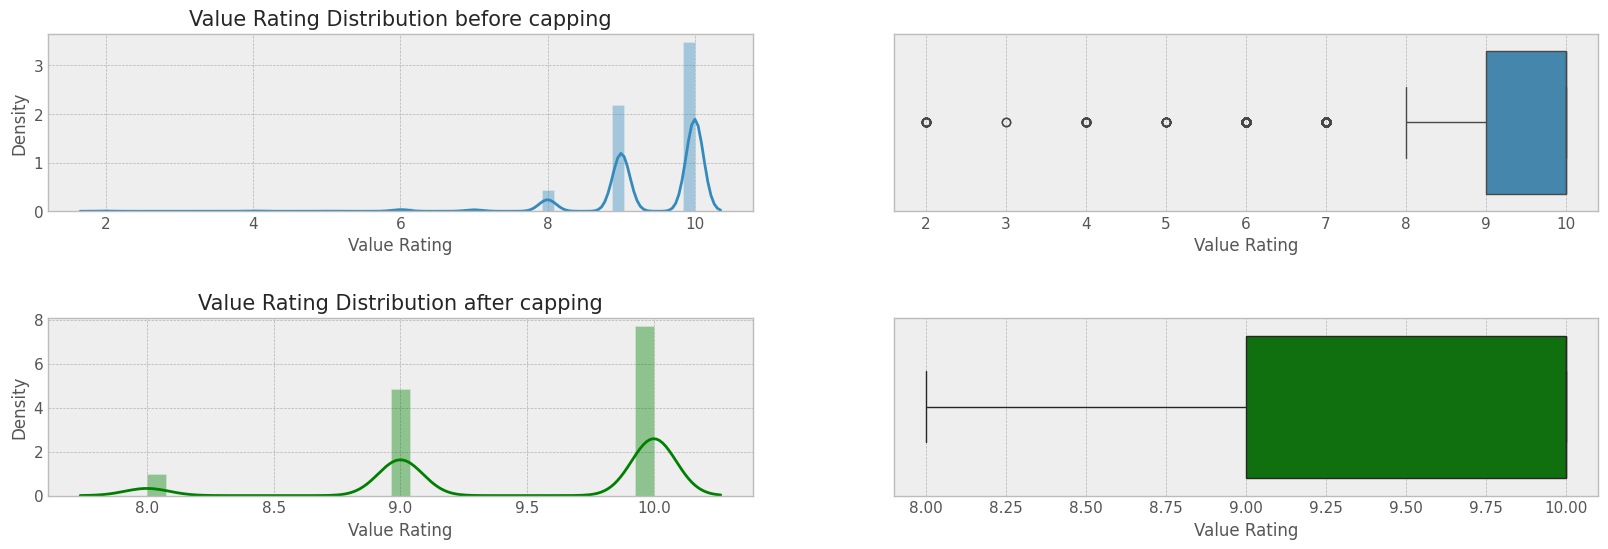

Host Response Rate


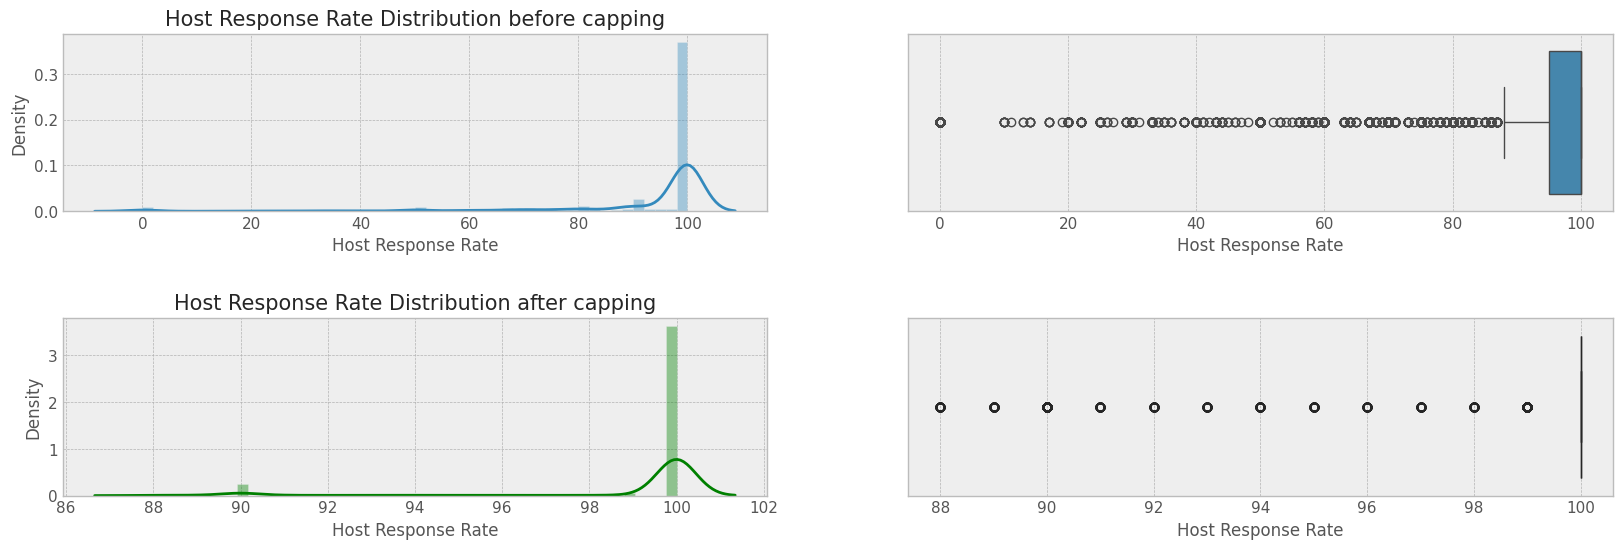

Location Rating


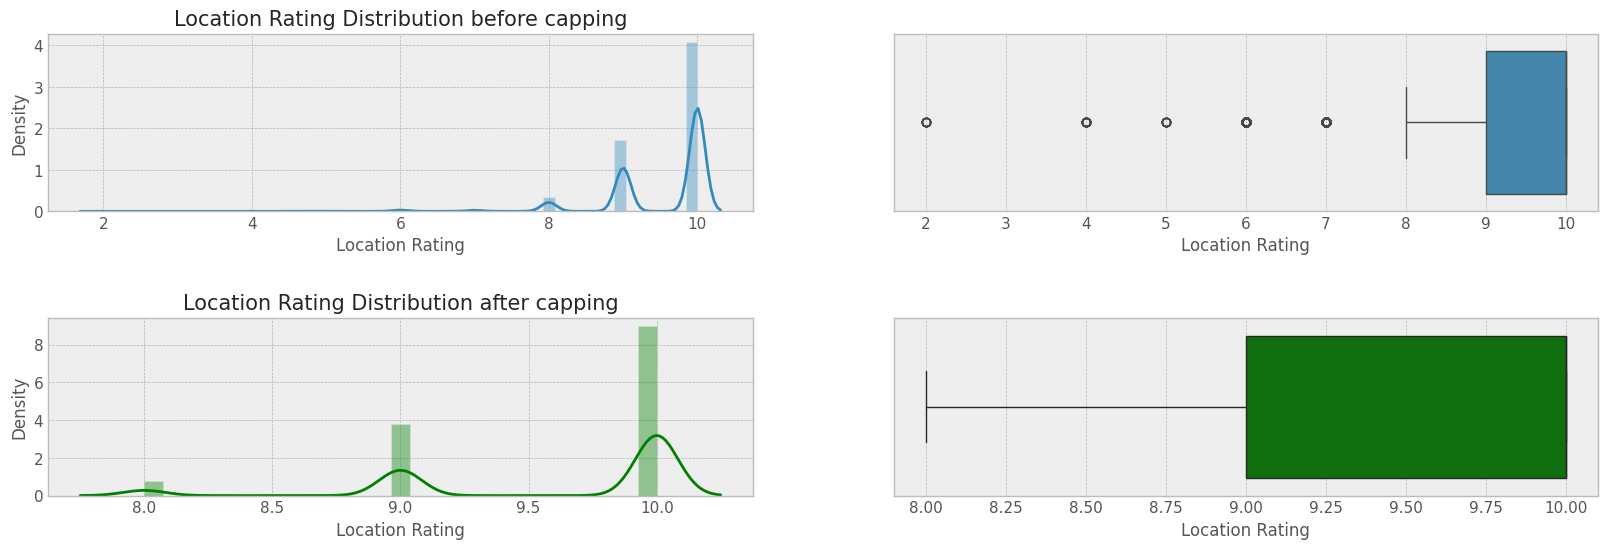

Guests Included


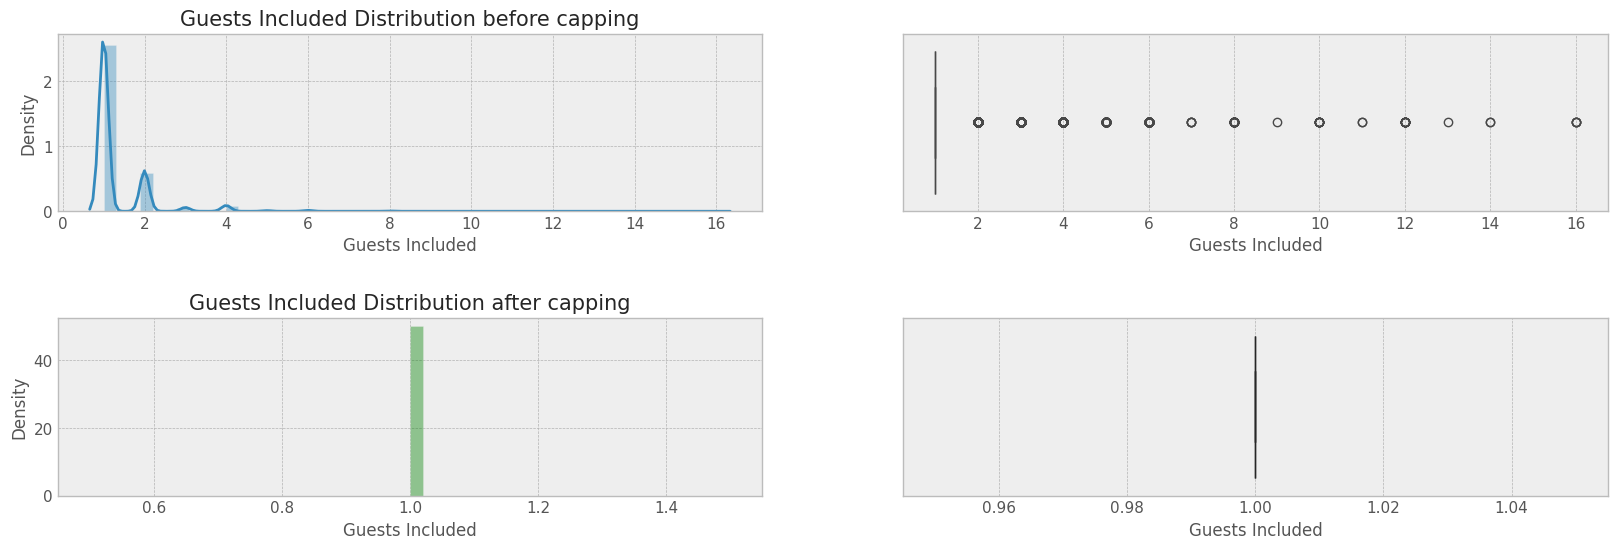

Min Nights


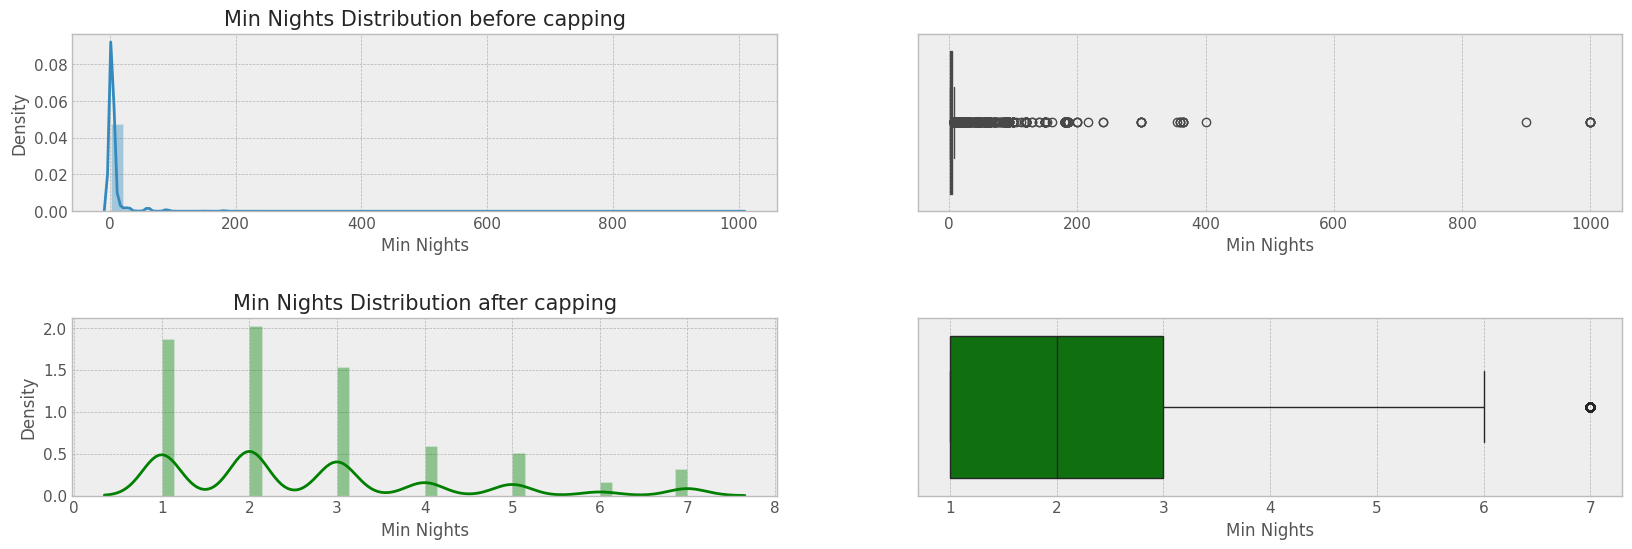

Latitude


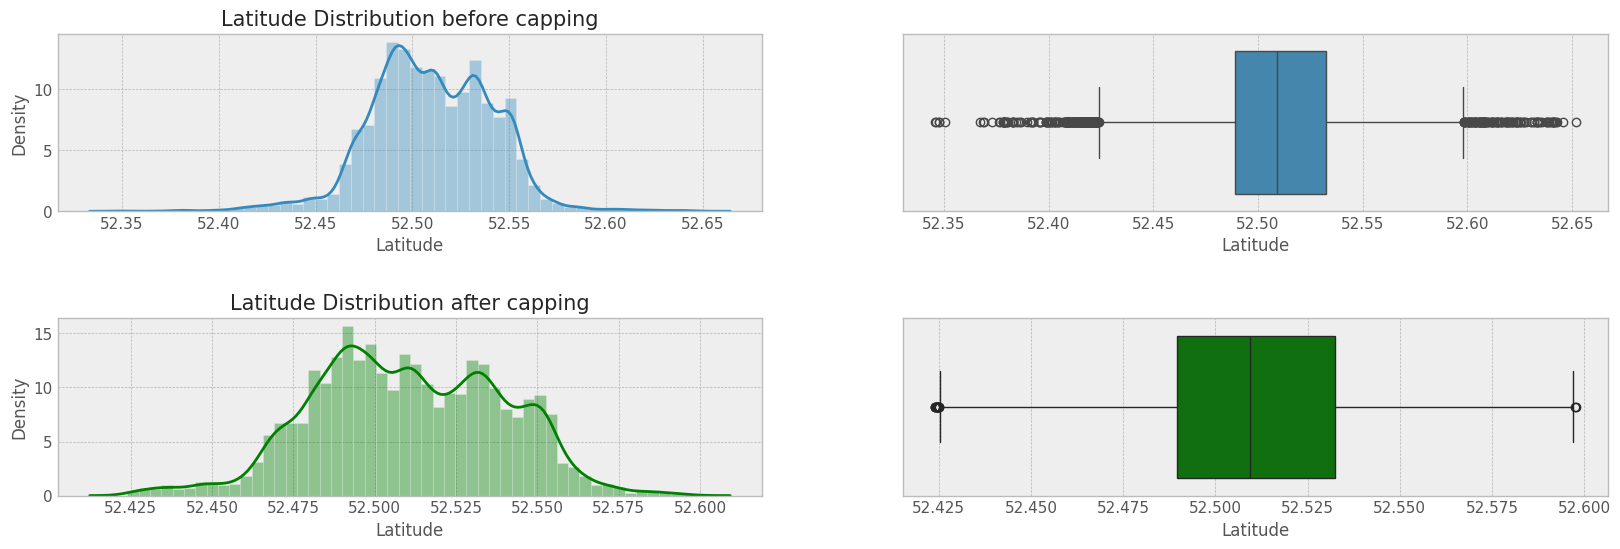

Cleanliness Rating


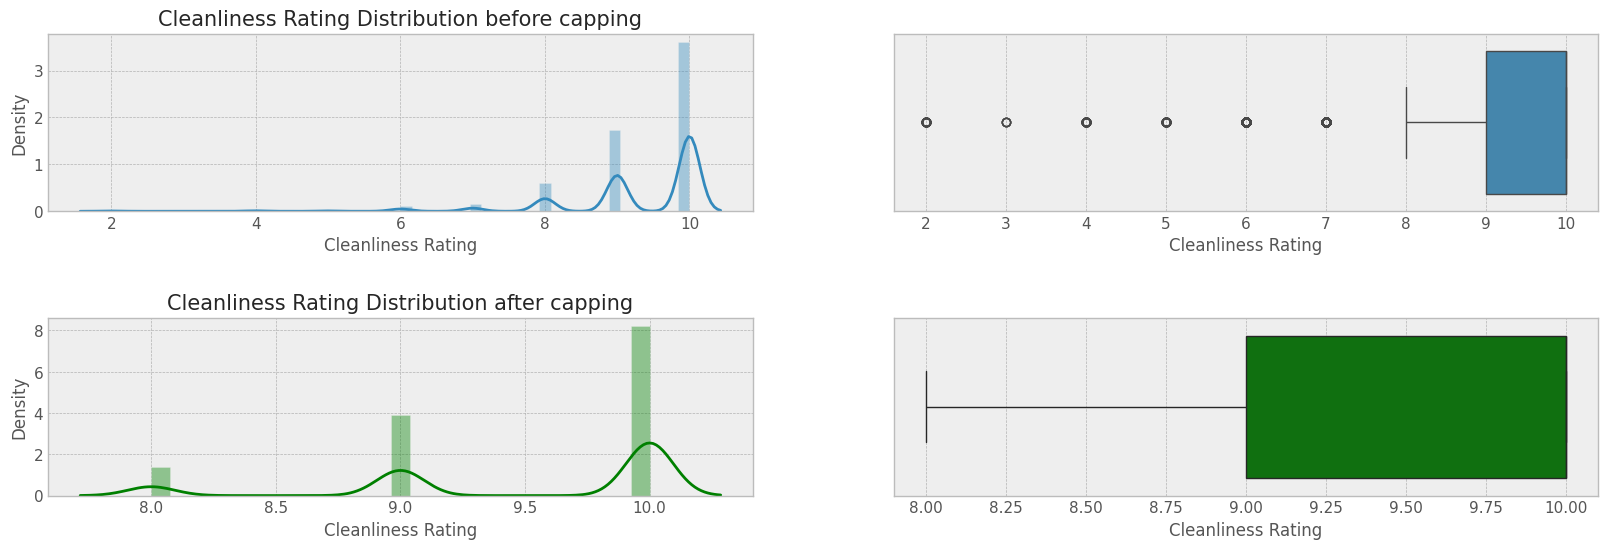

Bathrooms


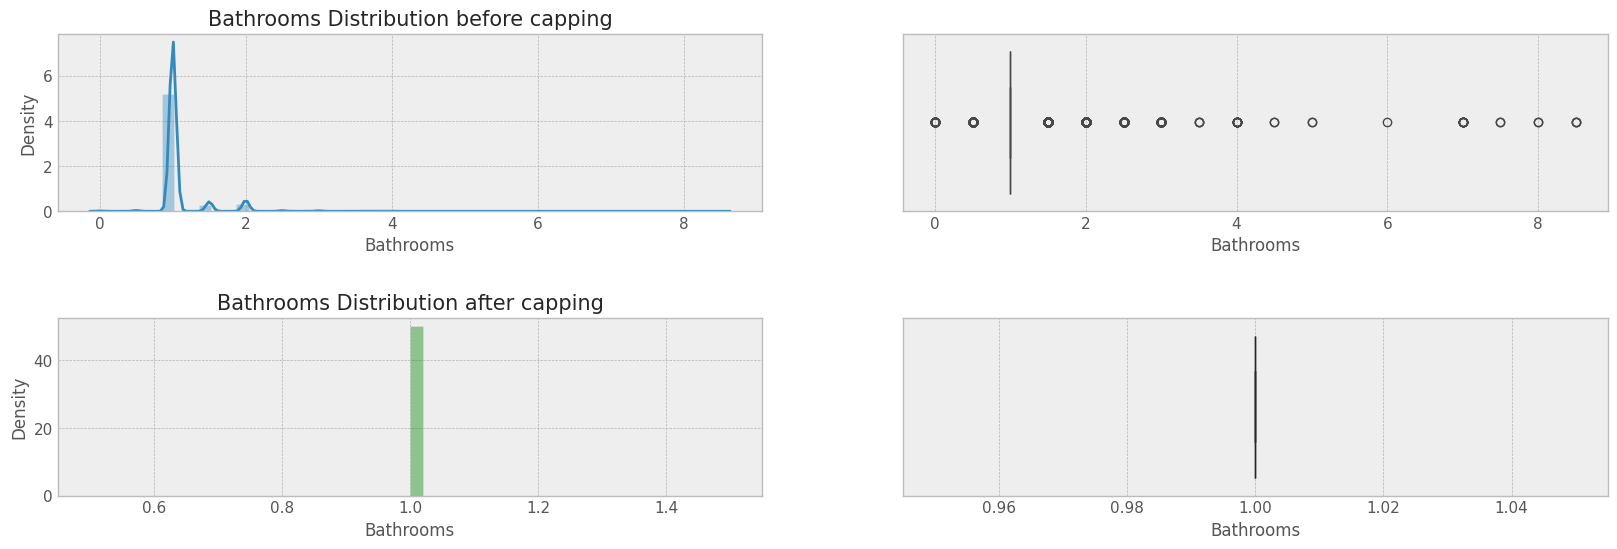

Longitude


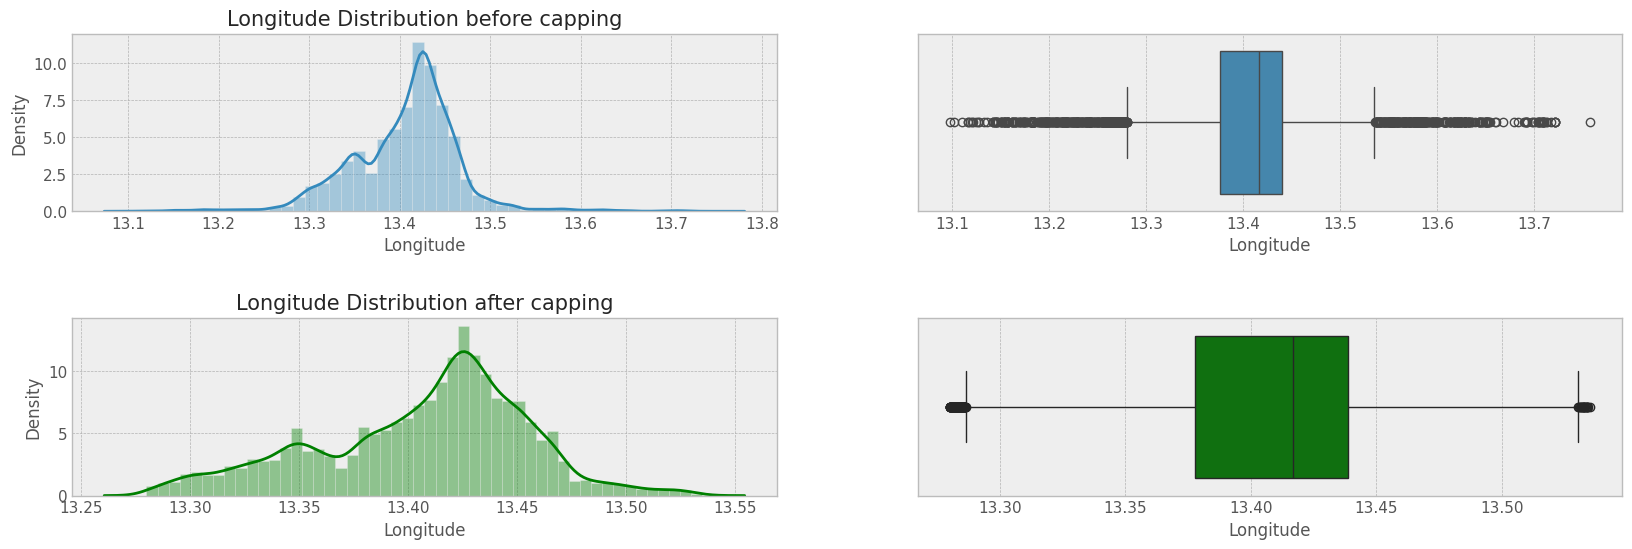

Reviews


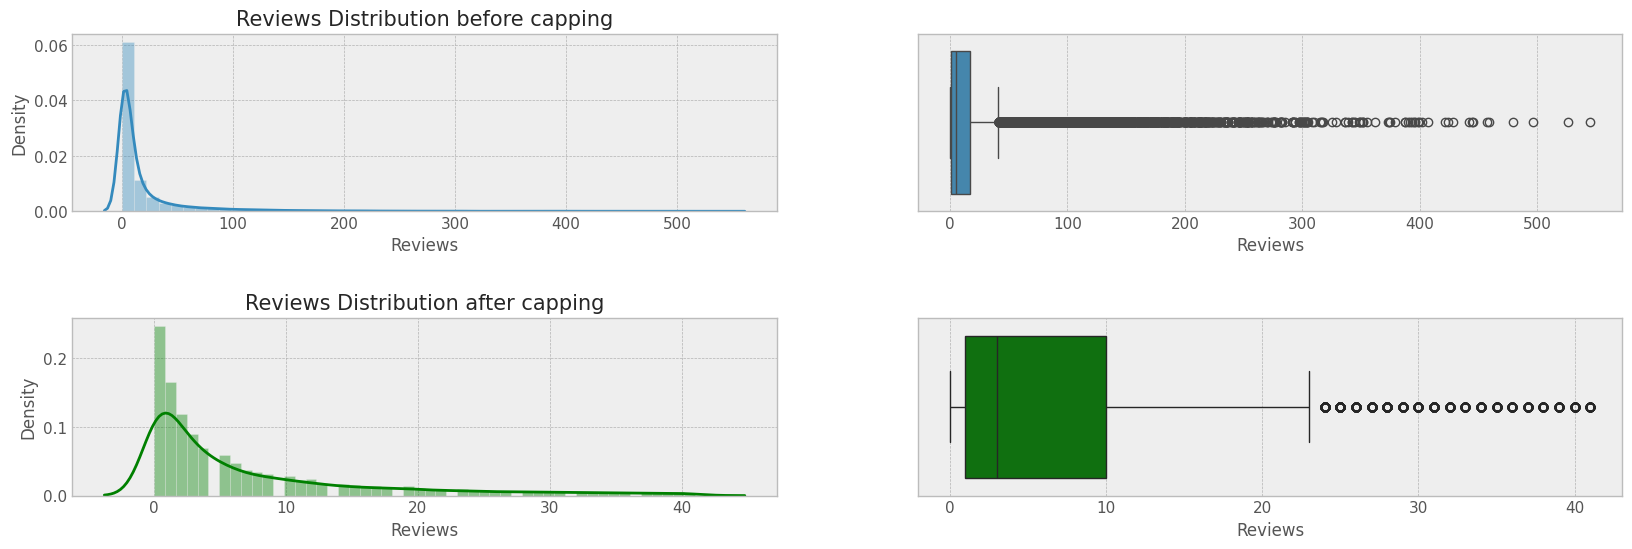

Beds


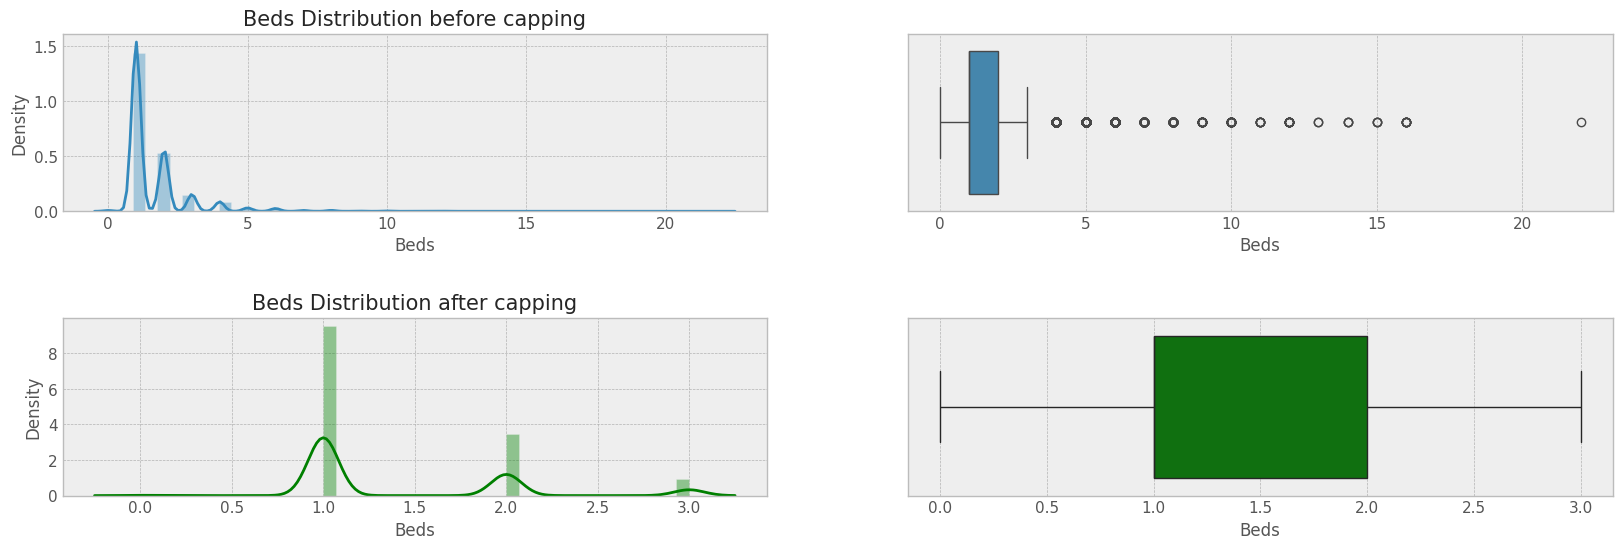

Overall Rating


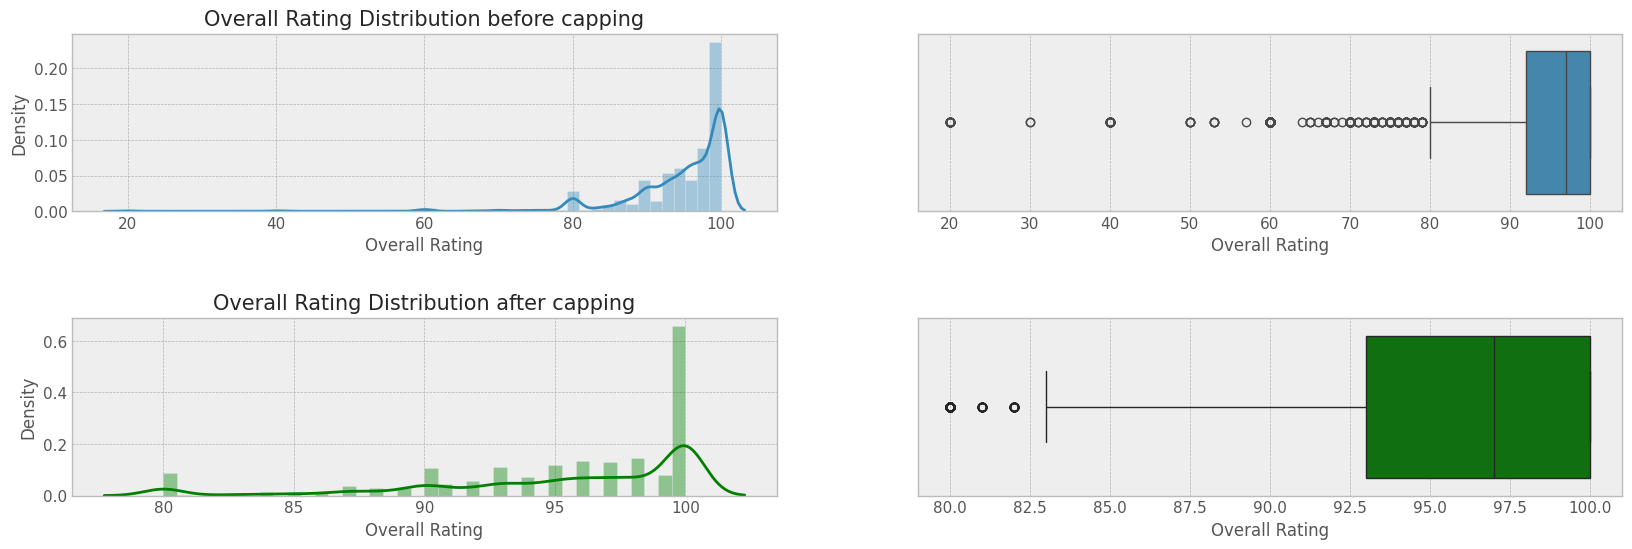

Accuracy Rating


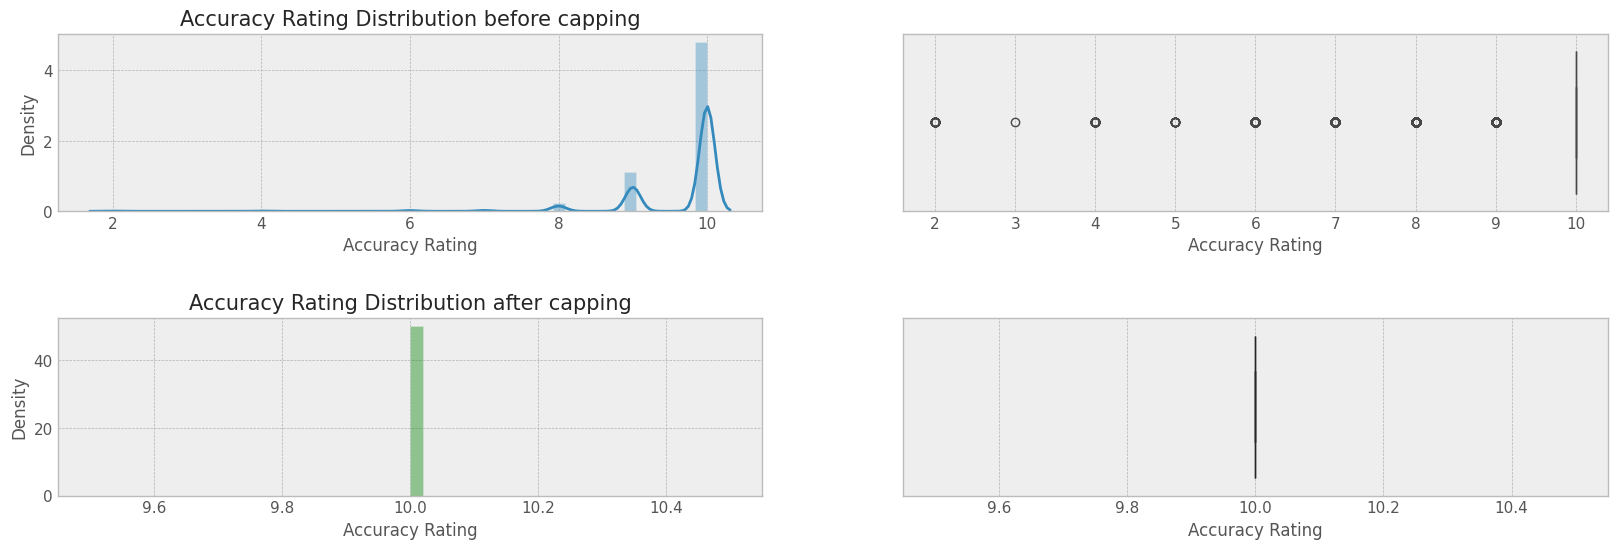

Square Feet


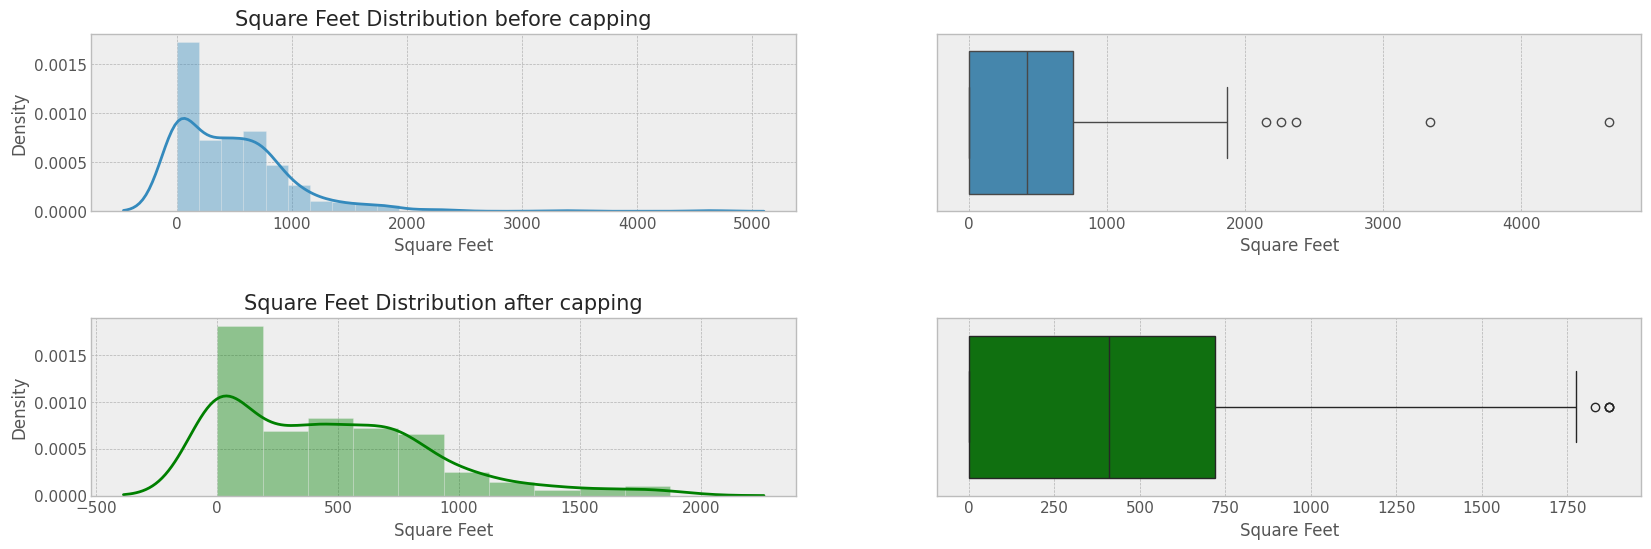

Checkin Rating


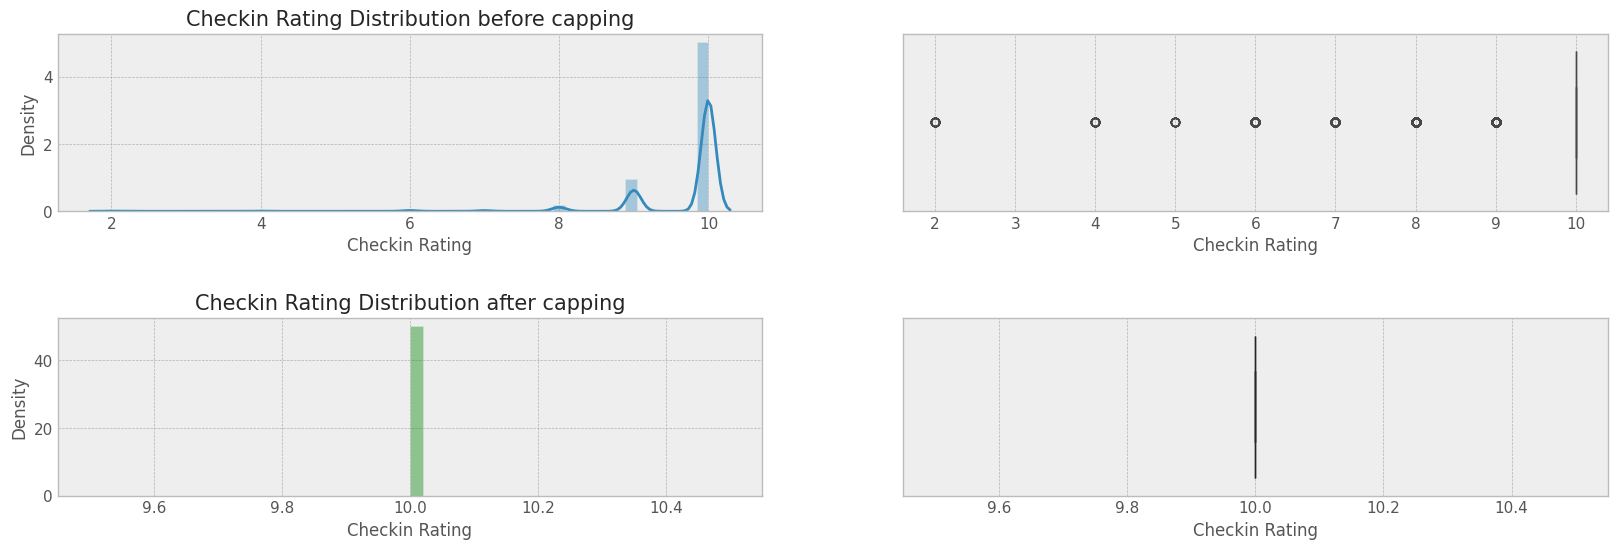

Communication Rating


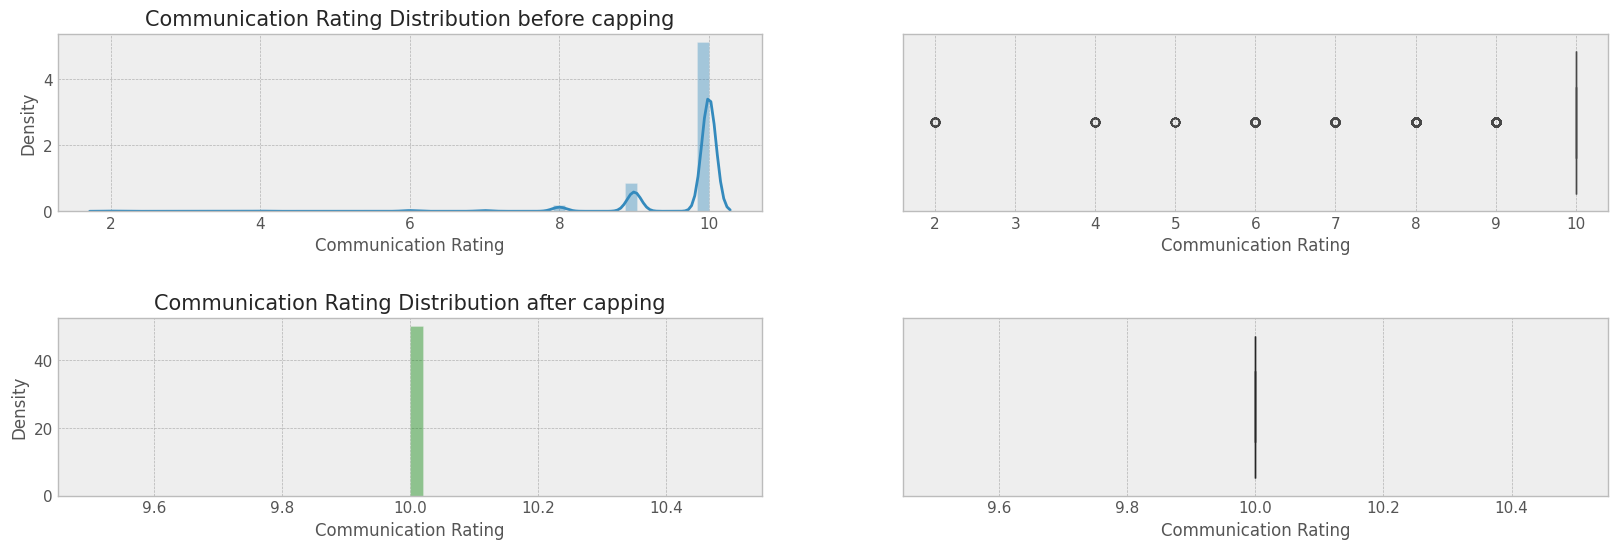

Bedrooms


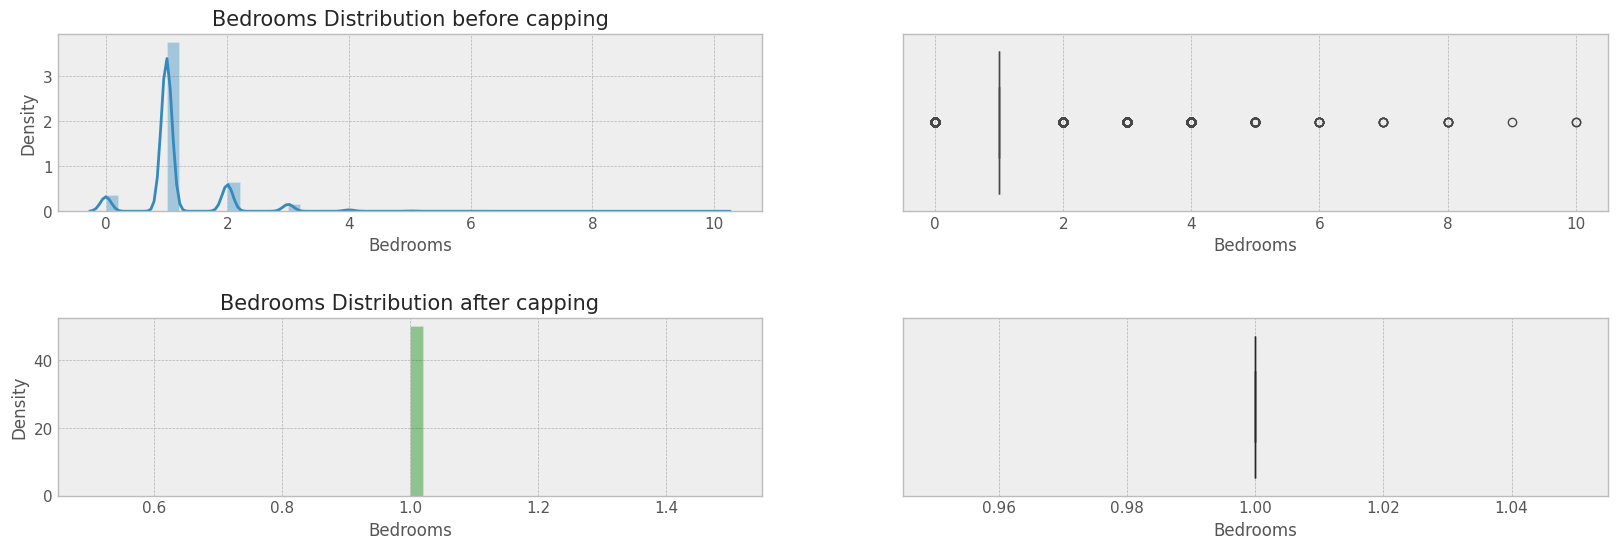

Accomodates


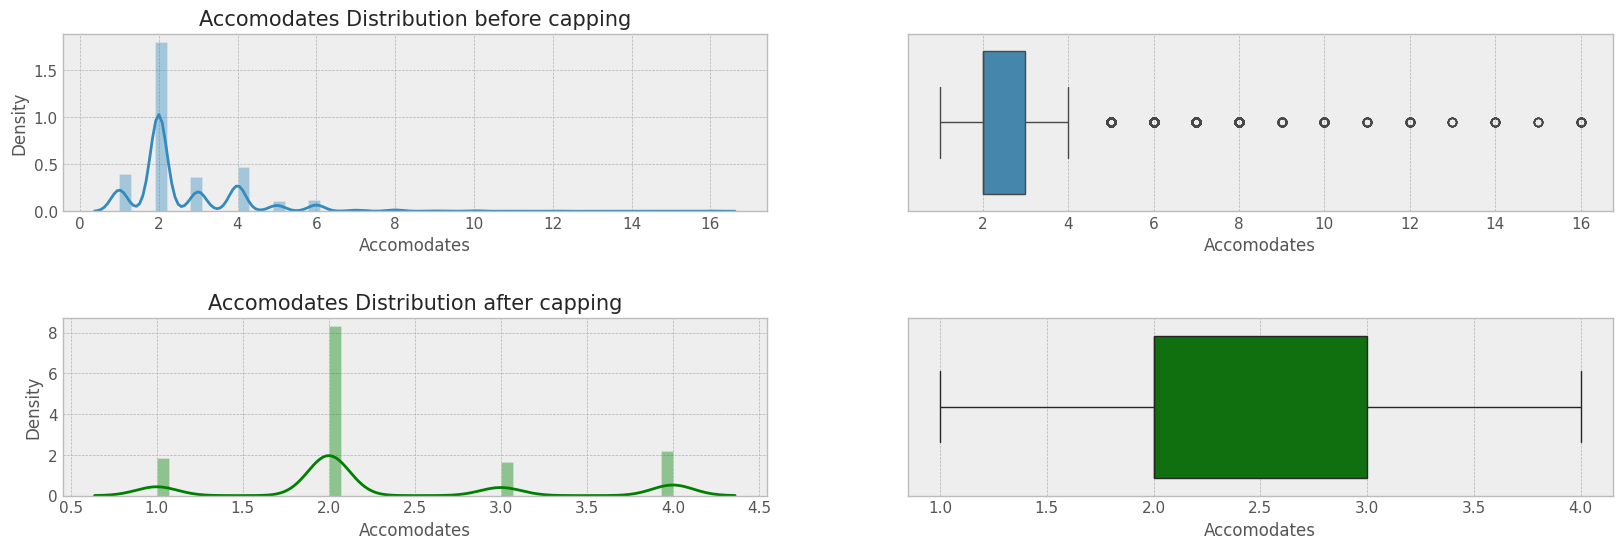

In [148]:
def dist_outliers(original_df, new, cols):
    for col in df_num_non_dummy:
        if col in cols:
          if col != "Price":
            print(col)
            plt.figure(figsize=(20,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(x=original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col],color='green')
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(x=new[col],color='green')
            plt.show()
dist_outliers(df, temp, outliers_df.index)

We clearly need to filter some features that either the feature distribution has changed significantly, or cases where removing outliers results with only one value.

Checking if distribution (Kolmogorov–Smirnov) and/or correlation has changed significantly:

In [149]:
### differences between two correlation in Python: https://github.com/psinger/CorrelationStats
### We will only take from the code the Fisher method for two-tailed test
def cocor(x1,y1, x2,y2):
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')
    n1 = len(x1)
    n2 = len(x2)
    xy_z = 0.5 * np.log((1 + xy1)/(1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2)/(1 - xy2))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [150]:
c=df_num_non_dummy
names=c.columns
#Creating df that reflects the correlation change
out_df= pd.DataFrame(columns=['feature','outliers_cnt','distribution_changed','correlation_changed'])

#A copy of numeric df
no_outliers=df_num_non_dummy.copy()
np.seterr(divide='ignore', invalid='ignore')
# Create a list to store the data for the new DataFrame
rows_list = []

for i in names:
    #     df with outliers
    out=df[i]
    #     df with out outliers
    non=df[i].loc[df_outliers[i]==0]
    #     lable with outliers
    price_out=df['Price']
    #     lable with out outliers
    price_non=df['Price'].loc[df_outliers[i]==0]
    #     cocor pvalue
    p, pvalue = cocor(out,price_out, non,price_non)
    cor_change=np.where(pvalue<0.05,'+','-')
    #     outliers count
    mv=df_outliers.sum()
    #    ks pvalue
    pval=ks_2samp(out, non)[1]
    dist_change=np.where(pval<0.05,'+','-')

    # Instead of using append, add a dictionary to the list
    rows_list.append({'feature': i, 'outliers_cnt': mv, 'distribution_changed': dist_change, 'correlation_changed': cor_change})

# After the loop, create the DataFrame from the list of dictionaries
out_df = pd.DataFrame(rows_list)
out_df.head(10)



feature                                       outliers_cnt  \
0        Value Rating  Overall Rating           465
Accuracy Rating  ...   
1  Host Response Rate  Overall Rating           465
Accuracy Rating  ...   
2     Location Rating  Overall Rating           465
Accuracy Rating  ...   
3     Guests Included  Overall Rating           465
Accuracy Rating  ...   
4          Min Nights  Overall Rating           465
Accuracy Rating  ...   
5            Latitude  Overall Rating           465
Accuracy Rating  ...   
6               Price  Overall Rating           465
Accuracy Rating  ...   
7  Cleanliness Rating  Overall Rating           465
Accuracy Rating  ...   
8           Bathrooms  Overall Rating           465
Accuracy Rating  ...   
9           Longitude  Overall Rating           465
Accuracy Rating  ...   

  distribution_changed correlation_changed  
0                    -                   -  
1                    -                   +  
2                    -                   -  
3                    +                   -  
4                    +                   +  
5                    -                   -  
6                    -                   -  
7                    -                   +  
8                    -                   -  
9                    +                   -

In [151]:
#All 'Yes' Vars in the 'Drop'colums shall be deleted, since the infect correlation and distribution.
#We don't want to delete vars that will change the distribution
out_df['drop']='yes'
out_df.loc[(out_df.distribution_changed=='+')& (out_df.correlation_changed=='+'),'drop'] = 'no'
out_df

feature                                       outliers_cnt  \
0           Value Rating  Overall Rating           465
Accuracy Rating  ...   
1     Host Response Rate  Overall Rating           465
Accuracy Rating  ...   
2        Location Rating  Overall Rating           465
Accuracy Rating  ...   
3        Guests Included  Overall Rating           465
Accuracy Rating  ...   
4             Min Nights  Overall Rating           465
Accuracy Rating  ...   
5               Latitude  Overall Rating           465
Accuracy Rating  ...   
6                  Price  Overall Rating           465
Accuracy Rating  ...   
7     Cleanliness Rating  Overall Rating           465
Accuracy Rating  ...   
8              Bathrooms  Overall Rating           465
Accuracy Rating  ...   
9              Longitude  Overall Rating           465
Accuracy Rating  ...   
10               Reviews  Overall Rating           465
Accuracy Rating  ...   
11                  Beds  Overall Rating           465
Accuracy Rating  ...   
12        Overall Rating  Overall Rating           465
Accuracy Rating  ...   
13       Accuracy Rating  Overall Rating           465
Accuracy Rating  ...   
14           Square Feet  Overall Rating           465
Accuracy Rating  ...   
15        Checkin Rating  Overall Rating           465
Accuracy Rating  ...   
16  Communication Rating  Overall Rating           465
Accuracy Rating  ...   
17              Bedrooms  Overall Rating           465
Accuracy Rating  ...   
18           Accomodates  Overall Rating           465
Accuracy Rating  ...   

   distribution_changed correlation_changed drop  
0                     -                   -  yes  
1                     -                   +  yes  
2                     -                   -  yes  
3                     +                   -  yes  
4                     +                   +   no  
5                     -                   -  yes  
6                     -                   -  yes  
7                     -                   +  yes  
8                     -                   -  yes  
9                     +                   -  yes  
10                    +                   +   no  
11                    -                   +  yes  
12                    -                   -  yes  
13                    -                   -  yes  
14                    -                   -  yes  
15                    -                   -  yes  
16                    -                   -  yes  
17                    -                   -  yes  
18                    +                   +   no

In [152]:
out_df.groupby('drop').size()

drop
no      3
yes    16
dtype: int64

There are 20 features in total where removal of the outliers does not affect neither correlation nor distribution.

In [153]:
relevant_columns_features=out_df.loc[out_df['drop']=='yes']['feature']
relevant_columns_features

0             Value Rating
1       Host Response Rate
2          Location Rating
3          Guests Included
5                 Latitude
6                    Price
7       Cleanliness Rating
8                Bathrooms
9                Longitude
11                    Beds
12          Overall Rating
13         Accuracy Rating
14             Square Feet
15          Checkin Rating
16    Communication Rating
17                Bedrooms
Name: feature, dtype: object

Let's see the distribution with and without outliers for does specific 18 features:

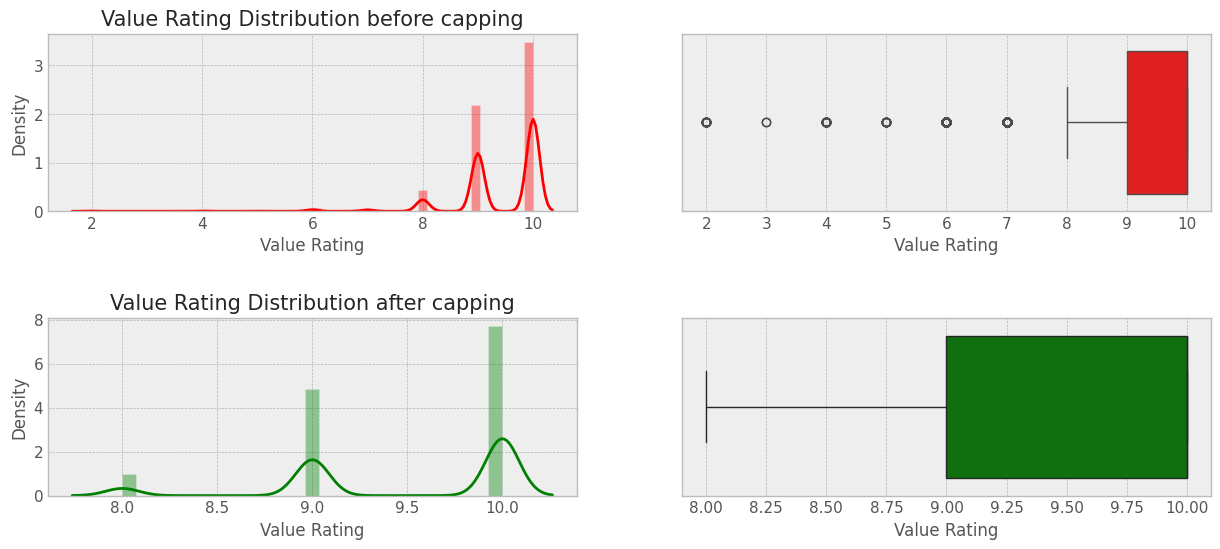

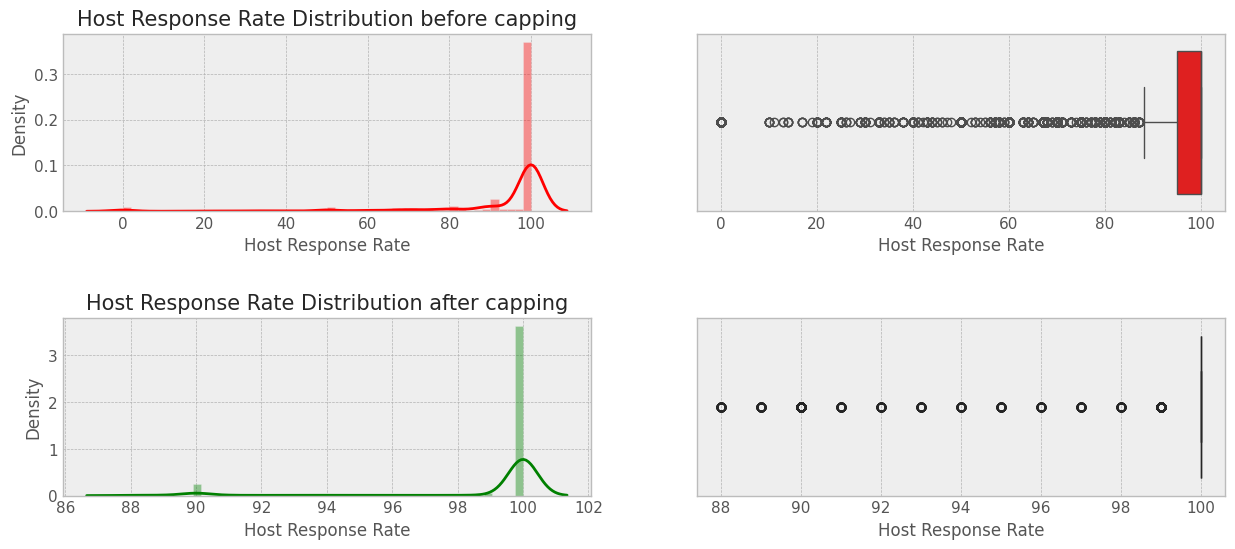

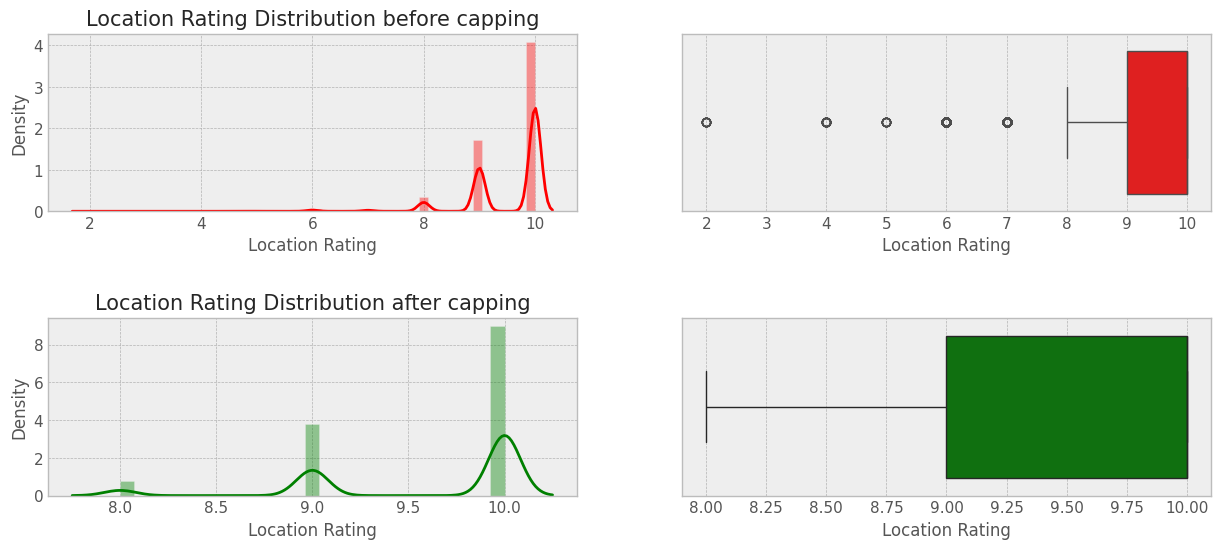

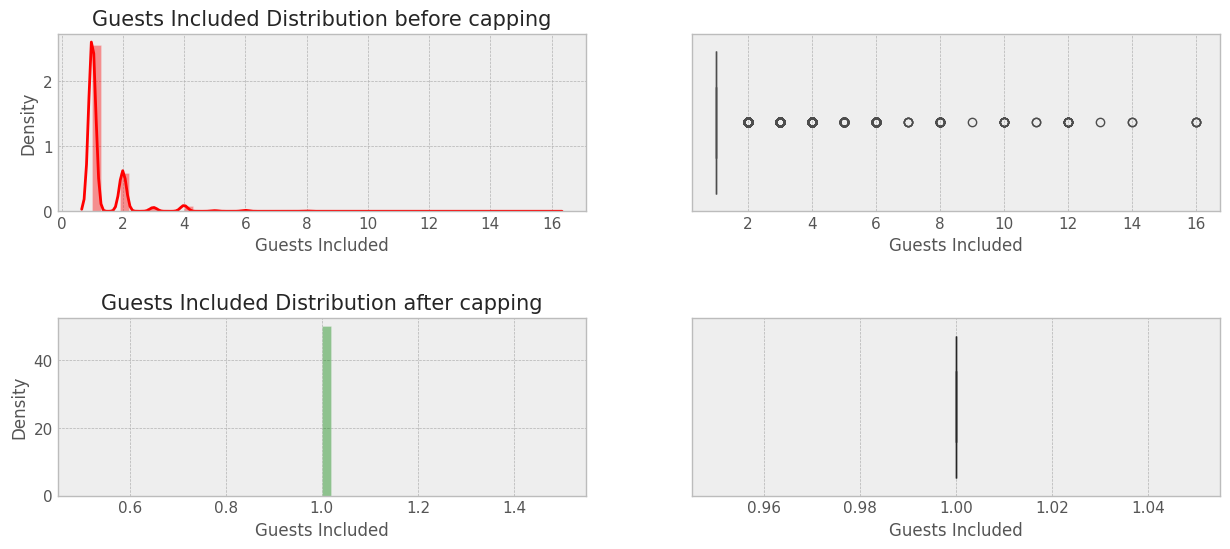

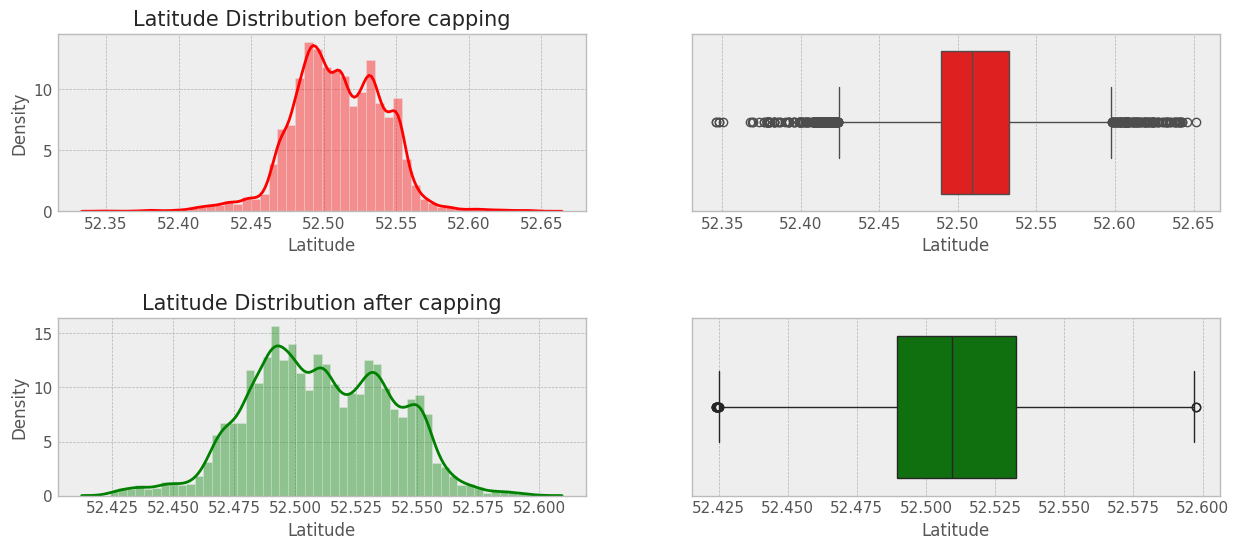

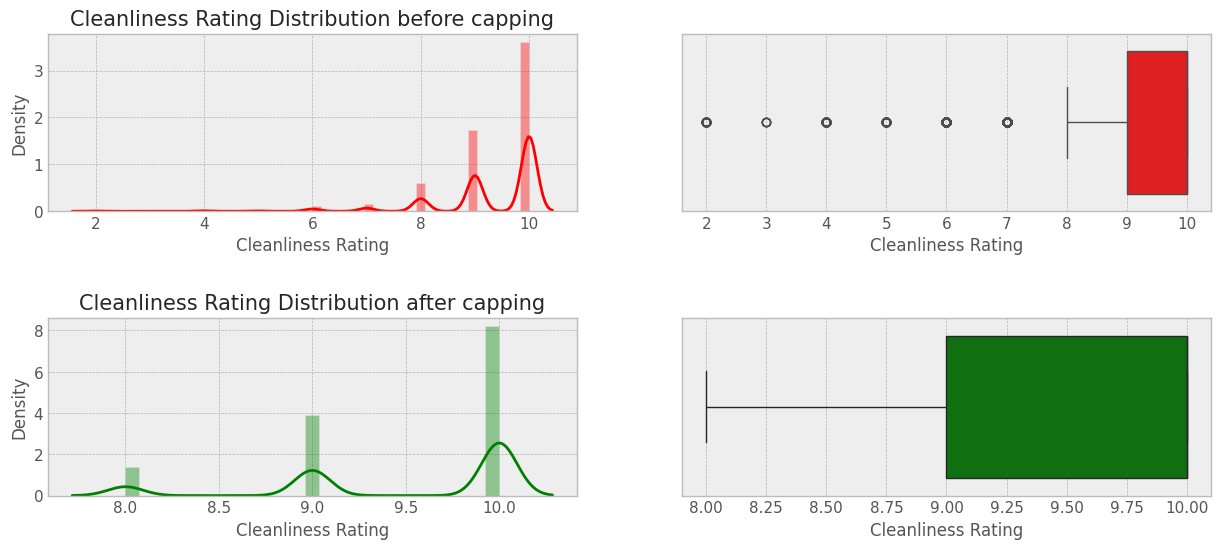

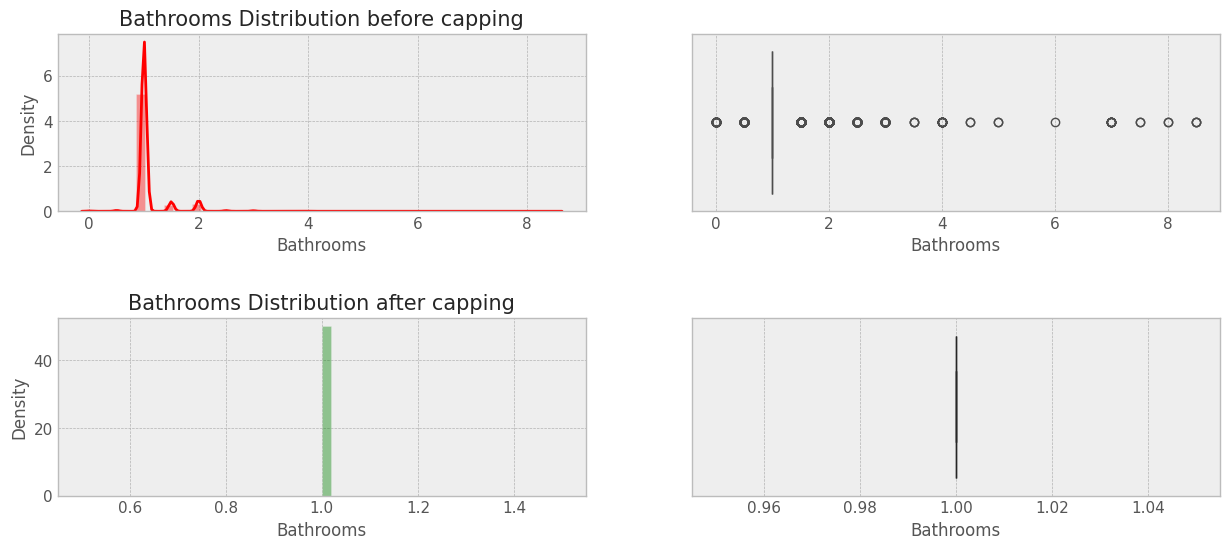

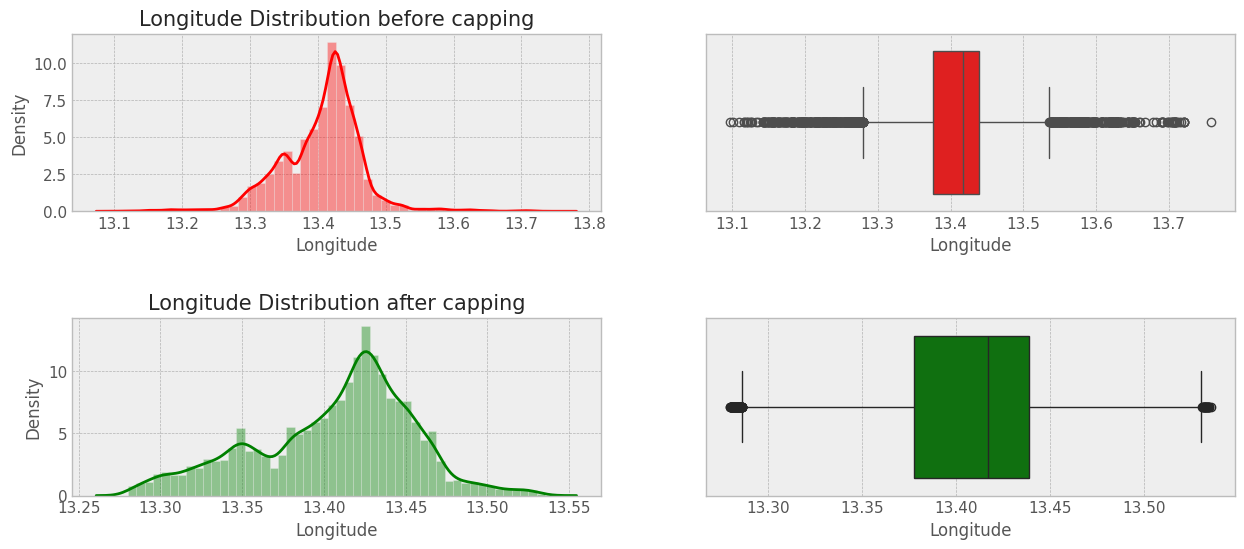

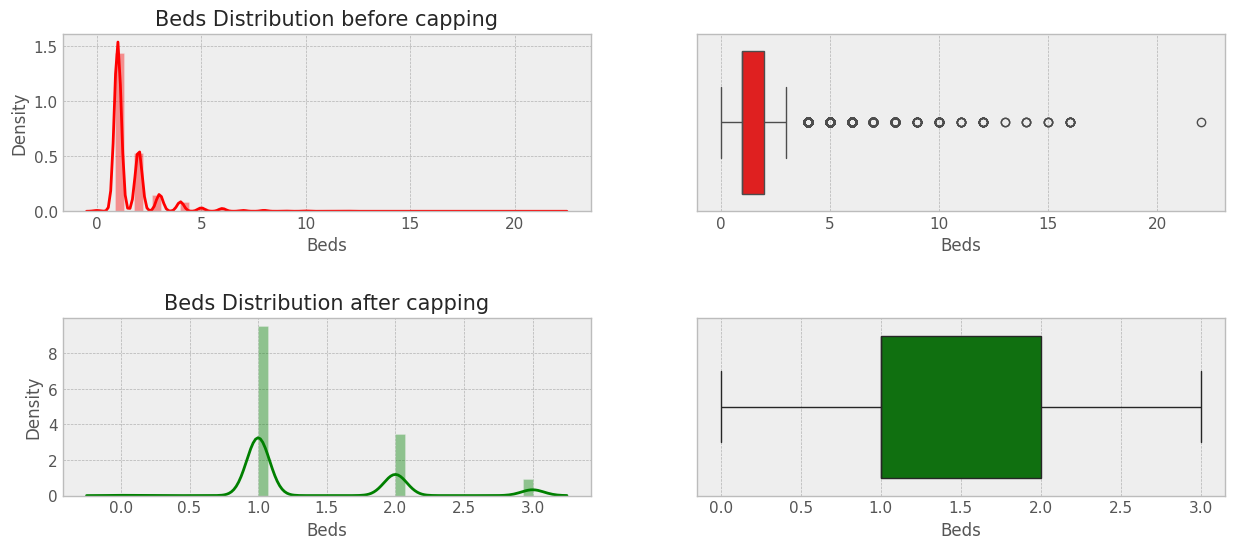

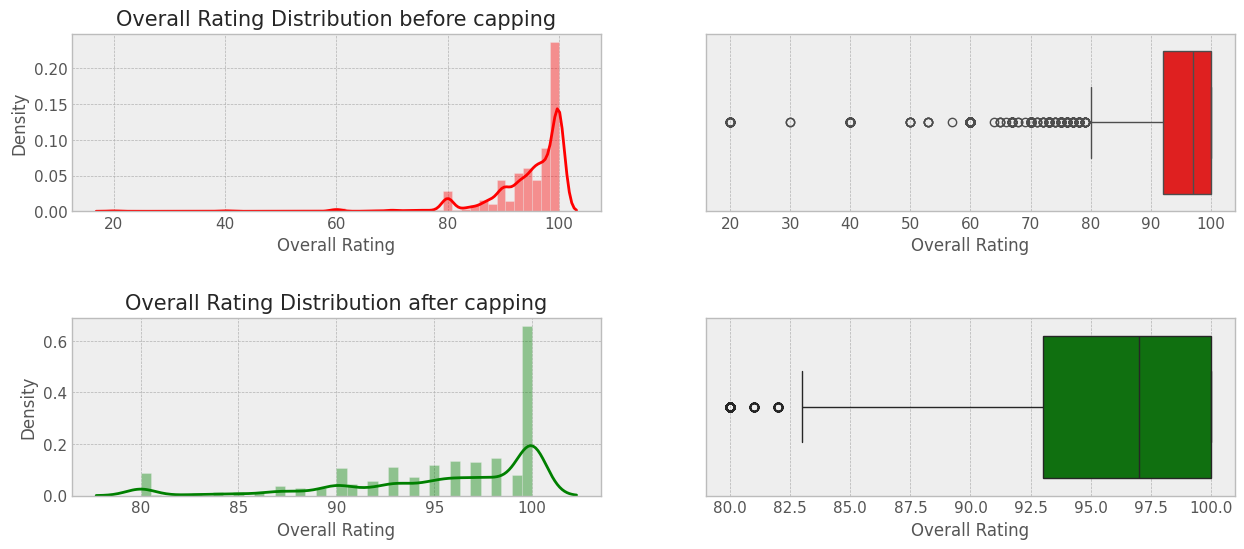

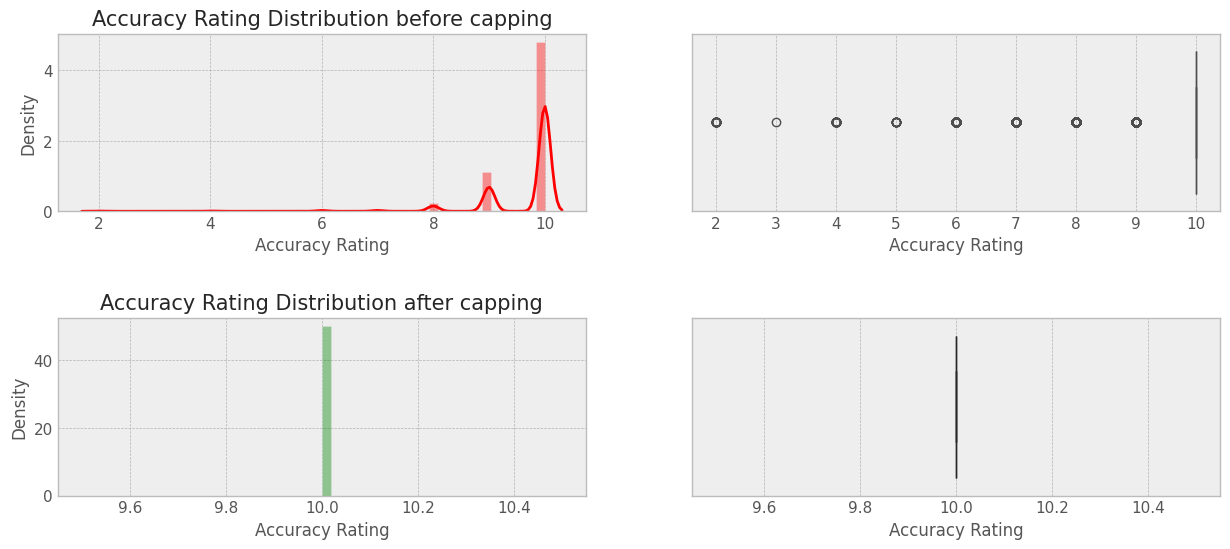

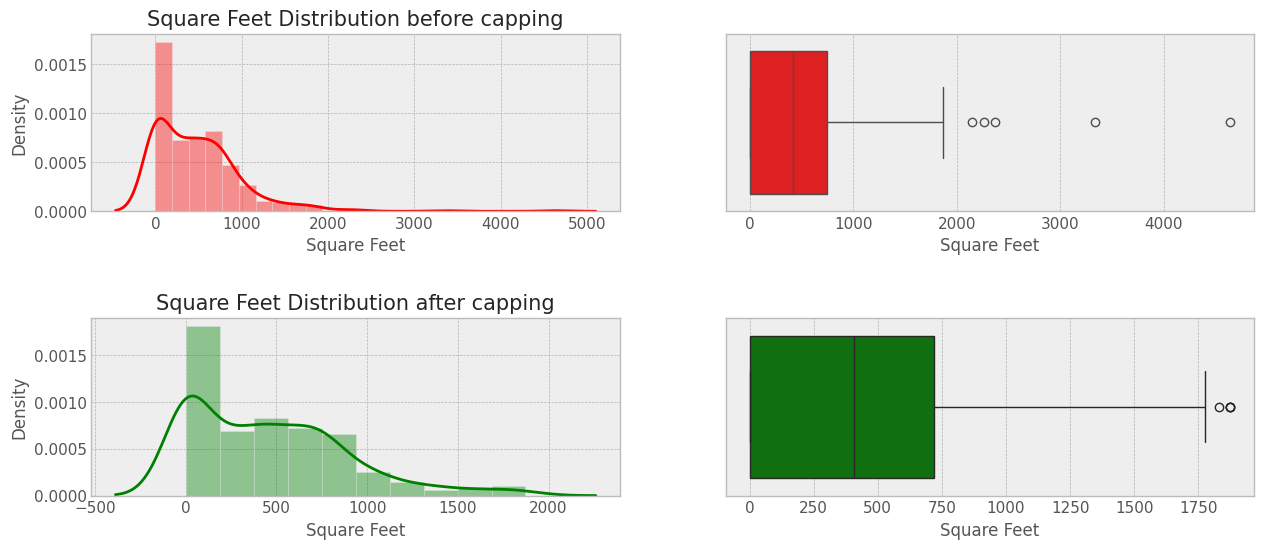

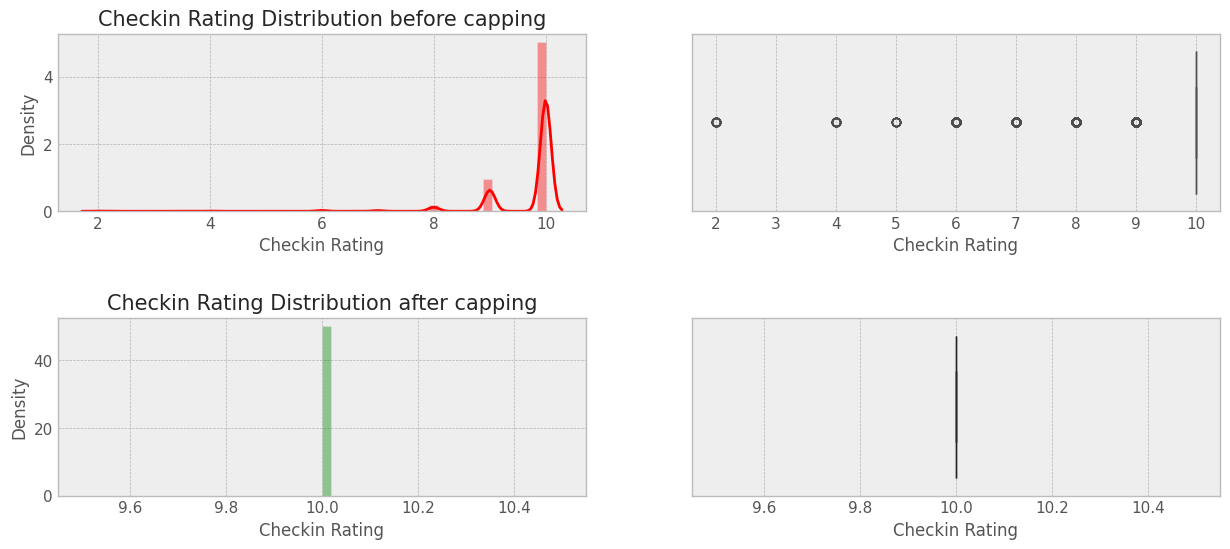

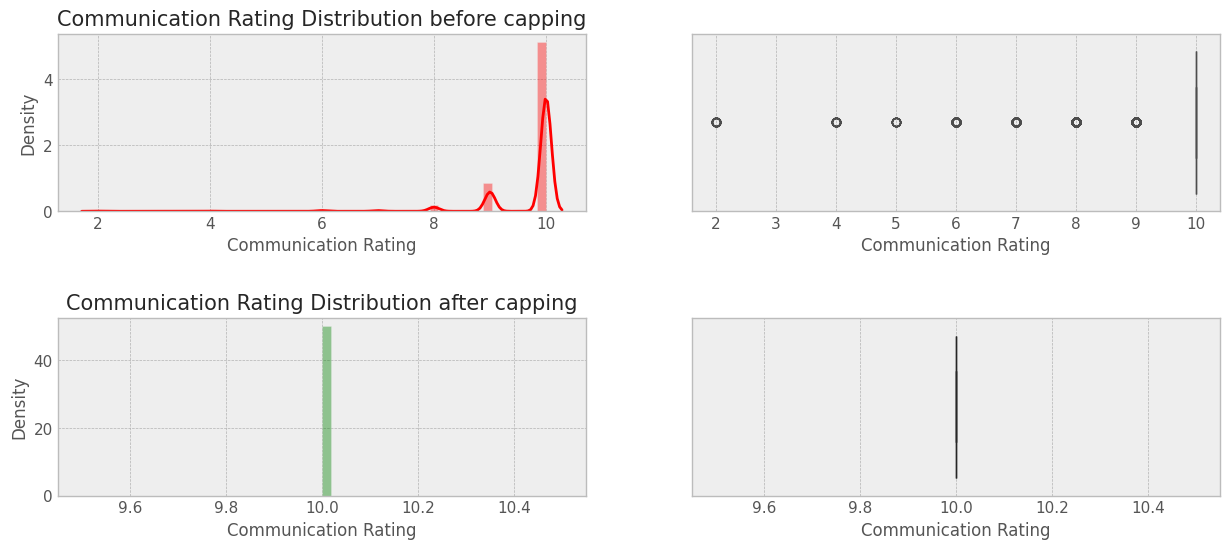

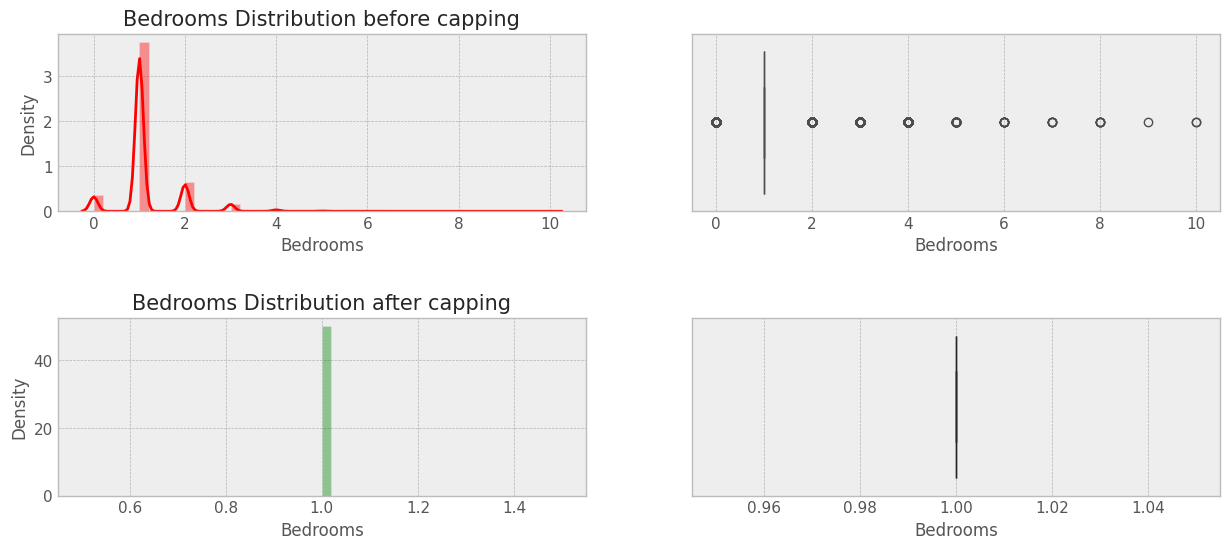

In [154]:
def dist_compare_after_capping(original_df, new, cols):
    for col in relevant_columns_features:
        if col in cols:
            plt.figure(figsize=(15,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col],color='red')
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(x=original_df[col],color='red')
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col],color='green')
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(x=new[col],color='green')
            plt.show()
dist_compare_after_capping(df, temp, outliers_df.index)

In [155]:
remove_outliers=['Bathrooms', 'Accomodates', 'Min Nights', 'Host Response Rate']
remove_outliers

['Bathrooms', 'Accomodates', 'Min Nights', 'Host Response Rate']

Removing outleirs that don't change correlation

In [156]:
df_outliers

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0                   0                0                   0               0   
1                   0                1                   0               1   
2                   0                0                   0               0   
3                   0                0                   0               0   
4                   0                0                   0               1   
...               ...              ...                 ...             ...   
23531               0                0                   0               0   
23532               0                0                   0               0   
23533               0                0                   0               0   
23534               0                0                   0               0   
23535               0                0                   0               0   

       Communication Rating  Location Rating  Value Rating  Price  \
0                         0                0             0      0   
1                         1                0             0      0   
2                         0                0             0      0   
3                         0                0             0      0   
4                         0                0             0      0   
...                     ...              ...           ...    ...   
23531                     0                0             0      0   
23532                     0                0             0      0   
23533                     0                0             0      0   
23534                     0                0             0      0   
23535                     0                0             0      0   

       Square Feet  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0                0        0         0     0          0                   1   
1                0        1         0     0          0                   1   
2                0        1         0     0          0                   0   
3                0        0         1     1          1                   0   
4                0        0         1     0          0                   0   
...            ...      ...       ...   ...        ...                 ...   
23531            0        0         0     0          0                   1   
23532            0        0         1     0          0                   0   
23533            0        0         0     0          1                   0   
23534            0        0         1     1          0                   0   
23535            0        0         1     0          0                   0   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0                 0         0          0            0                0   
1                 0         0          0            0                1   
2                 0         0          0            0                0   
3                 0         0          0            1                1   
4                 0         0          0            0                0   
...             ...       ...        ...          ...              ...   
23531             0         1          1            0                0   
23532             0         1          0            0                1   
23533             0         0          0            0                0   
23534             0         0          1            1                0   
23535             0         0          0            0                0   

       Min Nights  Instant Bookable  Is Exact Location  Postal Code  \
0               0                 0                  0            0   
1               1                 0                  0            0   
2               0                 0                  0            0   
3               0                 0                  0            0   
4               1                 0                  0      

In [157]:
#relevant_columns=out_df.loc[out_df['drop']=='yes']['feature']
manipulated_data= df.copy()
for j in range(len(df)):
    for col in remove_outliers:
        if df_outliers.loc[j,col] == 1:
            manipulated_data.loc[j,col] = 0

###**Missing Values**

In [158]:
manipulated_data.head()

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0           100.0             10.0                10.0            10.0   
1            92.0              9.0                 9.0             9.0   
2            96.0             10.0                10.0            10.0   
3           100.0             10.0                10.0            10.0   
4            93.0             10.0                10.0             9.0   

   Communication Rating  Location Rating  Value Rating  Price  Square Feet  \
0                  10.0              9.0          10.0   17.0          NaN   
1                   9.0             10.0           9.0   90.0        720.0   
2                  10.0             10.0          10.0   33.0          NaN   
3                  10.0             10.0          10.0  180.0          NaN   
4                  10.0              9.0           9.0   70.0          NaN   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                 0.0         False   
1    144.0       1.0   2.0        1.0                 0.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        0.0               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2           0   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            0                5           6   
4  52.54785   13.40556            1                1           0   

   Instant Bookable  Is Exact Location Postal Code Property Type  \
0             False               True       10437     Apartment   
1             False               True       10405     Apartment   
2             False               True       10437     Apartment   
3             False              False       10405     Apartment   
4             False               True       10437     Apartment   

  Host Response Time Neighborhood Group    neighbourhood        Room Type  
0       within a day             Pankow  Prenzlauer Berg     Private room  
1       within a day             Pankow  Prenzlauer Berg  Entire home/apt  
2     within an hour             Pankow  Prenzlauer Berg     Private room  
3       within a day             Pankow  Prenzlauer Berg  Entire home/apt  
4       within a day             Pankow  Prenzlauer Berg  Entire home/apt

In [159]:
#Getting a new/updated missing dataset from 'manipulated data' - this time we will call it df_nulls
df_nulls = manipulated_data.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls


Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Square Feet  \
0                      10.0              9.0          10.0          NaN   
1                       9.0             10.0           9.0        720.0   
2                      10.0             10.0          10.0          NaN   
3                      10.0             10.0          10.0          NaN   
4                      10.0              9.0           9.0          NaN   
...                     ...              ...           ...          ...   
23531                   NaN              NaN           NaN          NaN   
23532                   NaN              NaN           NaN          NaN   
23533                   NaN              NaN           NaN          NaN   
23534                   NaN              NaN           NaN          NaN   
23535                   NaN              NaN           NaN          NaN   

       Bedrooms  Beds  Bathrooms  Host Response Rate  Host Response Time  
0           1.0   1.0        1.0                 0.0        within a day  
1           1.0   2.0        1.0                 0.0        within a day  
2           1.0   2.0        1.0               100.0      within an hour  
3           4.0   7.0        0.0               100.0        within a day  
4           0.0   1.0        1.0               100.0        within a day  
...         ...   ...        ...                 ...                 ...  
23531       1.0   2.0        1.0                 0.0  within a few hours  
23532       2.0   2.0        1.0                 NaN                None  
23533       1.0   1.0        0.0                 NaN                None  
23534       3.0   4.0        1.0                 NaN                None  
23535       2.0   2.0        1.0                 NaN                None  

[23536 rows x 13 columns]

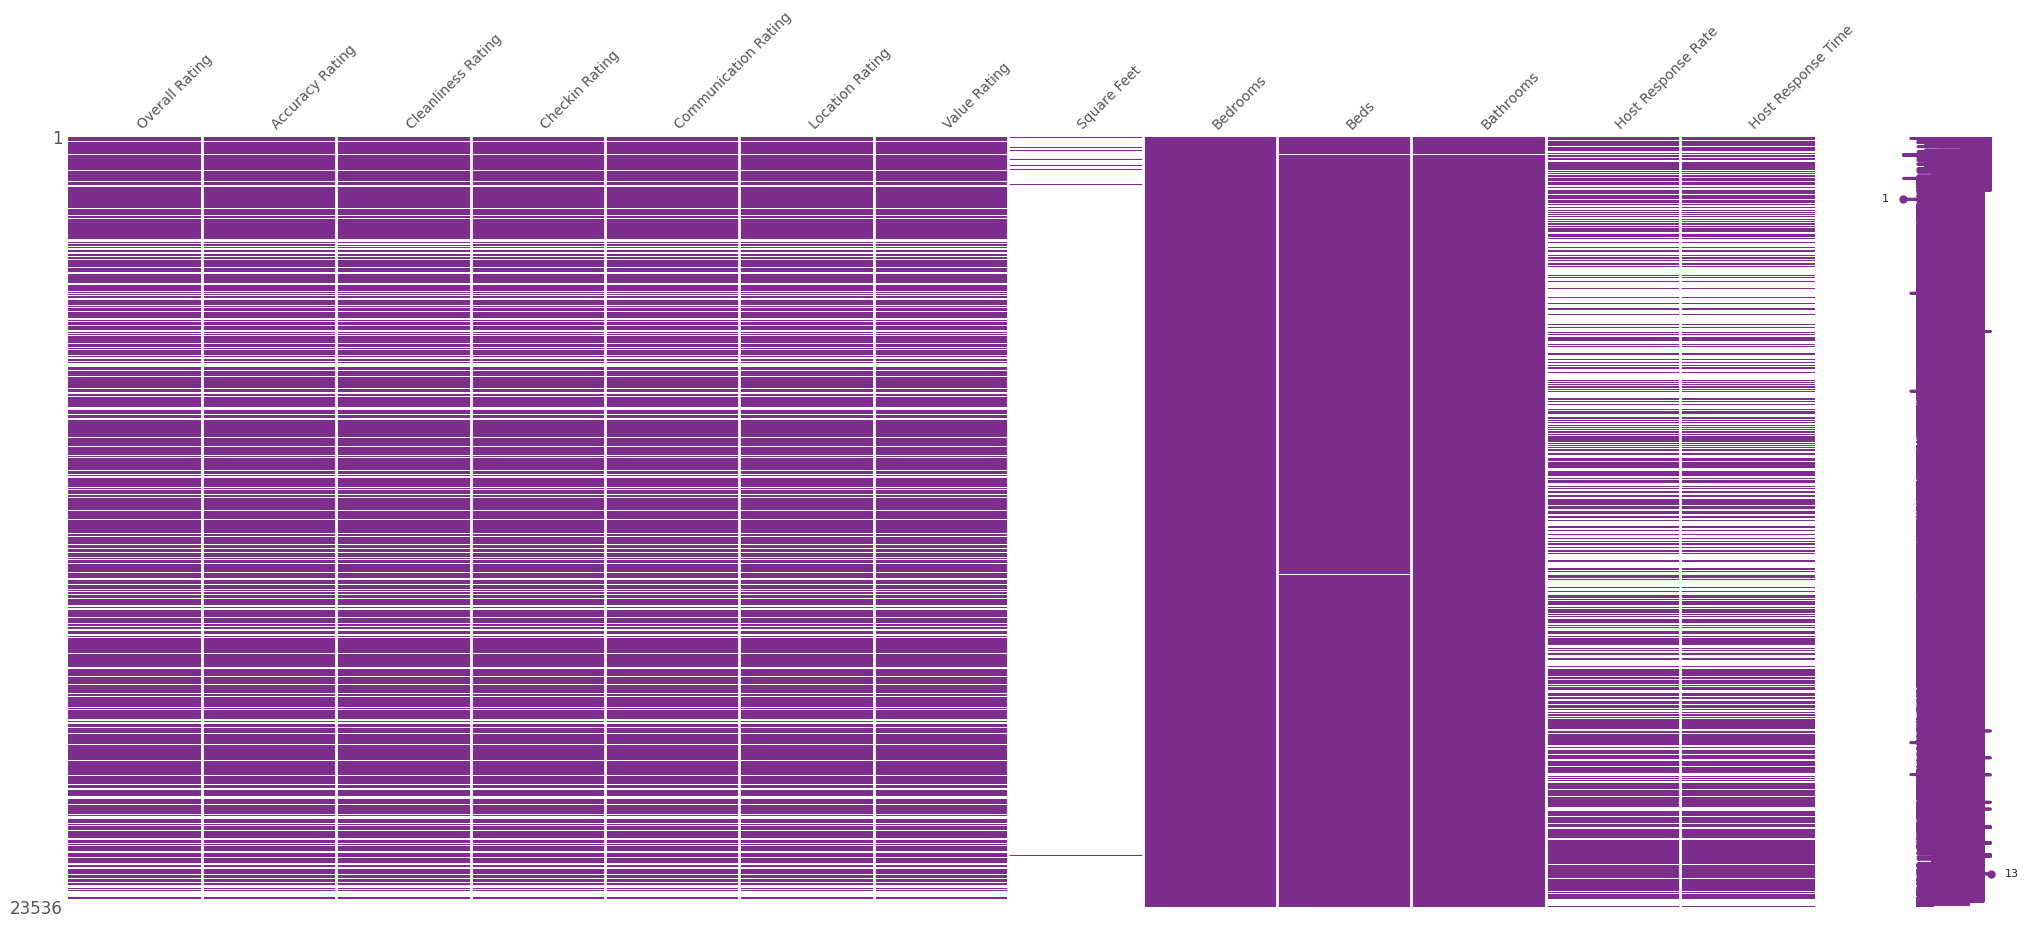

In [160]:
msno.matrix(df_nulls,color=(0.4940,0.1840,0.5560),fontsize=10);

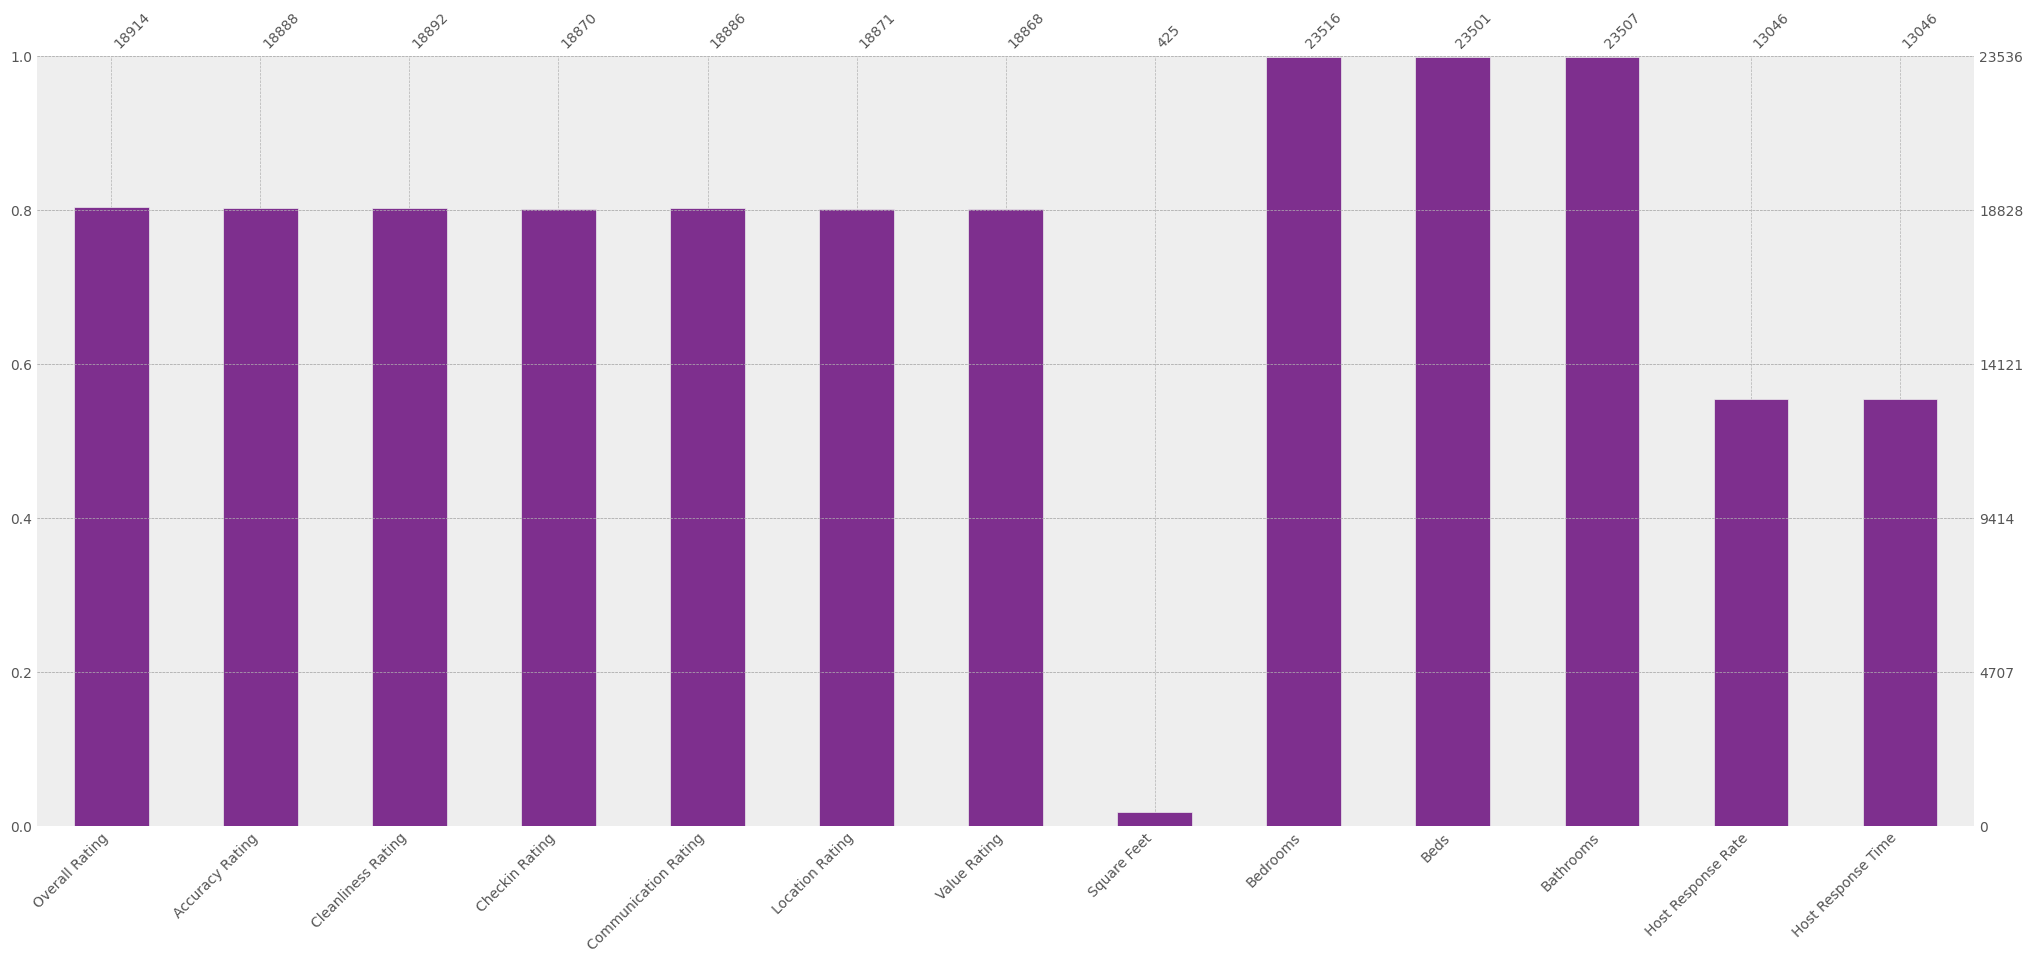

In [161]:
msno.bar(df_nulls,color=(0.4940,0.1840,0.5560),fontsize=10);

Updated missing values count and frequency after outliers removal:

In [162]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Square Feet                    23111               98.2
Host Response Rate             10490               44.6
Host Response Time             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
Beds                              35                0.1
Bathrooms                         29                0.1
Bedrooms                          20                0.1

In [163]:
mis_val_table_ren_columns.sum()

Missing Values       76738.0
% of Total Values      325.9
dtype: float64

Creating a dataframe with missing values as 1 and existing values as 0:



In [164]:
df_missing_data = manipulated_data.isin([np.nan])
df_missing_data = df_missing_data.astype('int')
df_missing_data

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0                   0                0                   0               0   
1                   0                0                   0               0   
2                   0                0                   0               0   
3                   0                0                   0               0   
4                   0                0                   0               0   
...               ...              ...                 ...             ...   
23531               1                1                   1               1   
23532               1                1                   1               1   
23533               1                1                   1               1   
23534               1                1                   1               1   
23535               1                1                   1               1   

       Communication Rating  Location Rating  Value Rating  Price  \
0                         0                0             0      0   
1                         0                0             0      0   
2                         0                0             0      0   
3                         0                0             0      0   
4                         0                0             0      0   
...                     ...              ...           ...    ...   
23531                     1                1             1      0   
23532                     1                1             1      0   
23533                     1                1             1      0   
23534                     1                1             1      0   
23535                     1                1             1      0   

       Square Feet  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0                1        0         0     0          0                   0   
1                0        0         0     0          0                   0   
2                1        0         0     0          0                   0   
3                1        0         0     0          0                   0   
4                1        0         0     0          0                   0   
...            ...      ...       ...   ...        ...                 ...   
23531            1        0         0     0          0                   0   
23532            1        0         0     0          0                   1   
23533            1        0         0     0          0                   1   
23534            1        0         0     0          0                   1   
23535            1        0         0     0          0                   1   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0                 0         0          0            0                0   
1                 0         0          0            0                0   
2                 0         0          0            0                0   
3                 0         0          0            0                0   
4                 0         0          0            0                0   
...             ...       ...        ...          ...              ...   
23531             0         0          0            0                0   
23532             0         0          0            0                0   
23533             0         0          0            0                0   
23534             0         0          0            0                0   
23535             0         0          0            0                0   

       Min Nights  Instant Bookable  Is Exact Location  Postal Code  \
0               0                 0                  0            0   
1               0                 0                  0            0   
2               0                 0                  0            0   
3               0                 0                  0            0   
4               0                 0                  0      

Creating df including numeric features of the later data - manipulated_data

In [165]:
#Selecting numeric data
numeric_manipulated_data = manipulated_data.select_dtypes(include=[np.number])
numeric_manipulated_data.columns

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Square Feet', 'Reviews', 'Bedrooms', 'Beds',
       'Bathrooms', 'Host Response Rate', 'Latitude', 'Longitude',
       'Accomodates', 'Guests Included', 'Min Nights'],
      dtype='object')

Difference in the distribution of a variable when another variable is with or without MV:

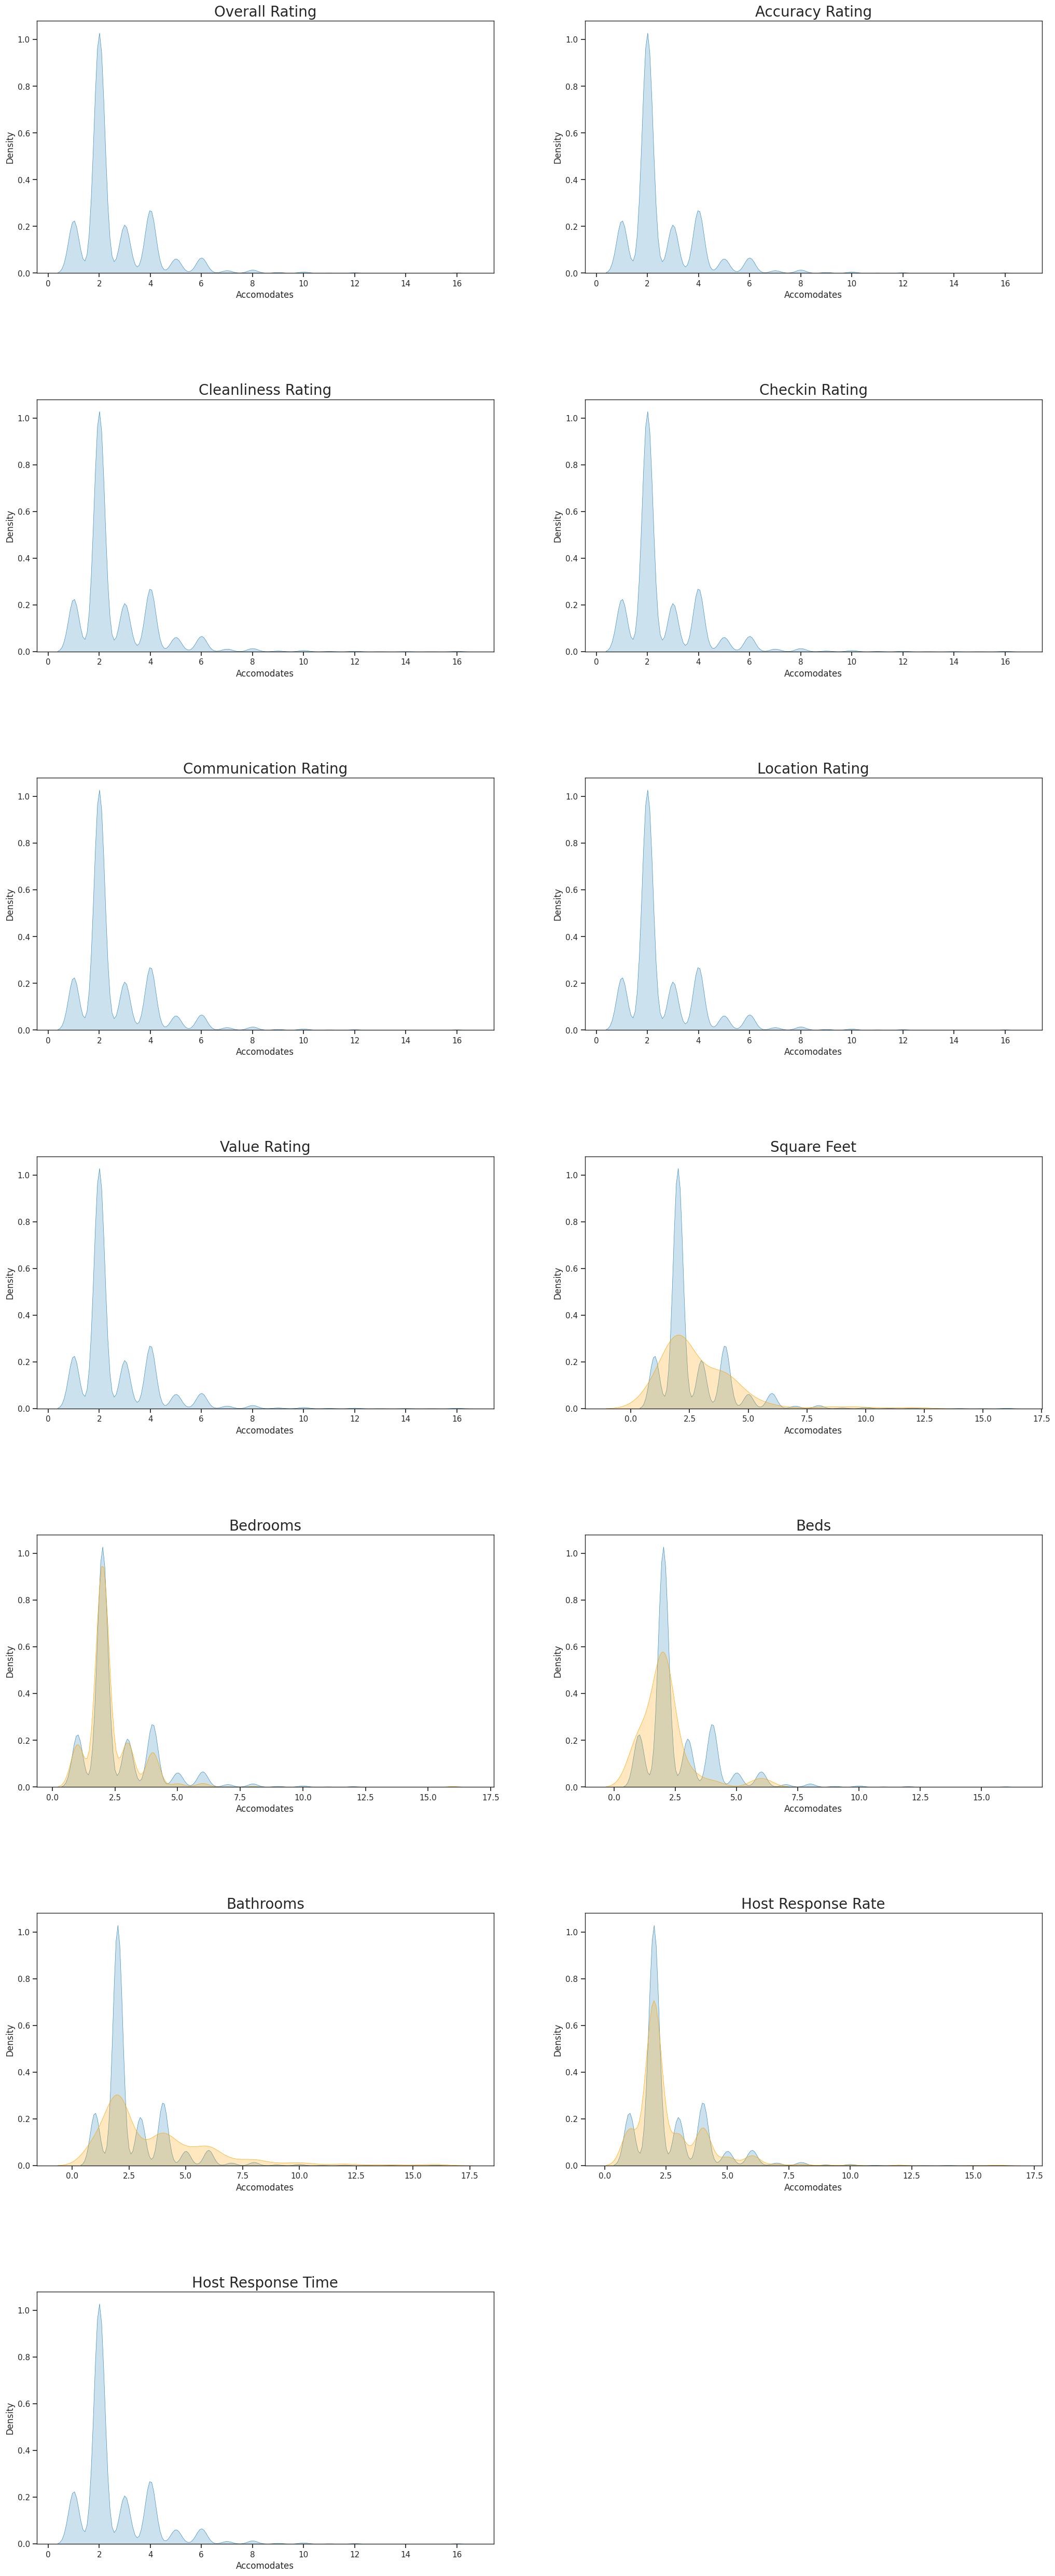

In [166]:
#c = numeric_manipulated_data.columns
colist = df_nulls.columns
#names = missing_names
#sns.set(font_scale = 0.8)
#sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set
a=len(colist)
b=2
c=1
fig = plt.figure(figsize=(25,120))
plt.subplots_adjust(hspace=0.5)
for j in df_nulls:
        if j!=i :
            plt.subplot(a,b,c)
            plt.title('{}'.format(j),fontsize=20)
            plt.xlabel(i)
            sns.kdeplot(df[i],fill=True)
            sns.kdeplot(df[i].loc[df_nulls[j]==0],fill=True,color='orange')
        c=c+1

plt.show()

Exploring data the segnificunce of distribution change:



In [167]:
#le = preprocessing.LabelEncoder()
MV_df_final = pd.DataFrame(columns= ['Var', 'MV_pct', 'distribution_changed'])
#df[m] = le.fit_transform(df[m].astype(str))
m=numeric_manipulated_data.copy()
#m = manipulated_data._get_numeric_data().columns.dropna().unique()
np.seterr(divide='ignore', invalid='ignore')
for i in m:
    # and i in mis_val_table_ren_columns.index.tolist():
    # column with NULLS
        null = m[i]
    # column without NULLS
        non = m[i].loc[df_missing_data[i]==0]
    # target value with NULLS
        price_null = m['Price']
    # target value without NULLS
        superhost_non = price_null.loc[df_missing_data[i]==0]
        mv = df_missing_data[i].sum()
    # perform Kolmogorov-Smirnov test
        pval = ks_2samp(null, non)[1]
        dis_change = np.where(pval<0.5,'+','-')
        # Instead of append, use concat to add a new row
        MV_df_final = pd.concat([MV_df_final, pd.DataFrame([{'Var': i, 'MV_pct': mv, 'distribution_changed': dis_change}])], ignore_index=True)
MV_df_final

Var MV_pct distribution_changed
0         Overall Rating   4622                    -
1        Accuracy Rating   4648                    -
2     Cleanliness Rating   4644                    -
3         Checkin Rating   4666                    -
4   Communication Rating   4650                    -
5        Location Rating   4665                    -
6           Value Rating   4668                    -
7                  Price      0                    -
8            Square Feet  23111                    -
9                Reviews      0                    -
10              Bedrooms     20                    -
11                  Beds     35                    -
12             Bathrooms     29                    -
13    Host Response Rate  10490                    -
14              Latitude      0                    -
15             Longitude      0                    -
16           Accomodates      0                    -
17       Guests Included      0                    -
18            Min Nights      0                    -

<Axes: >

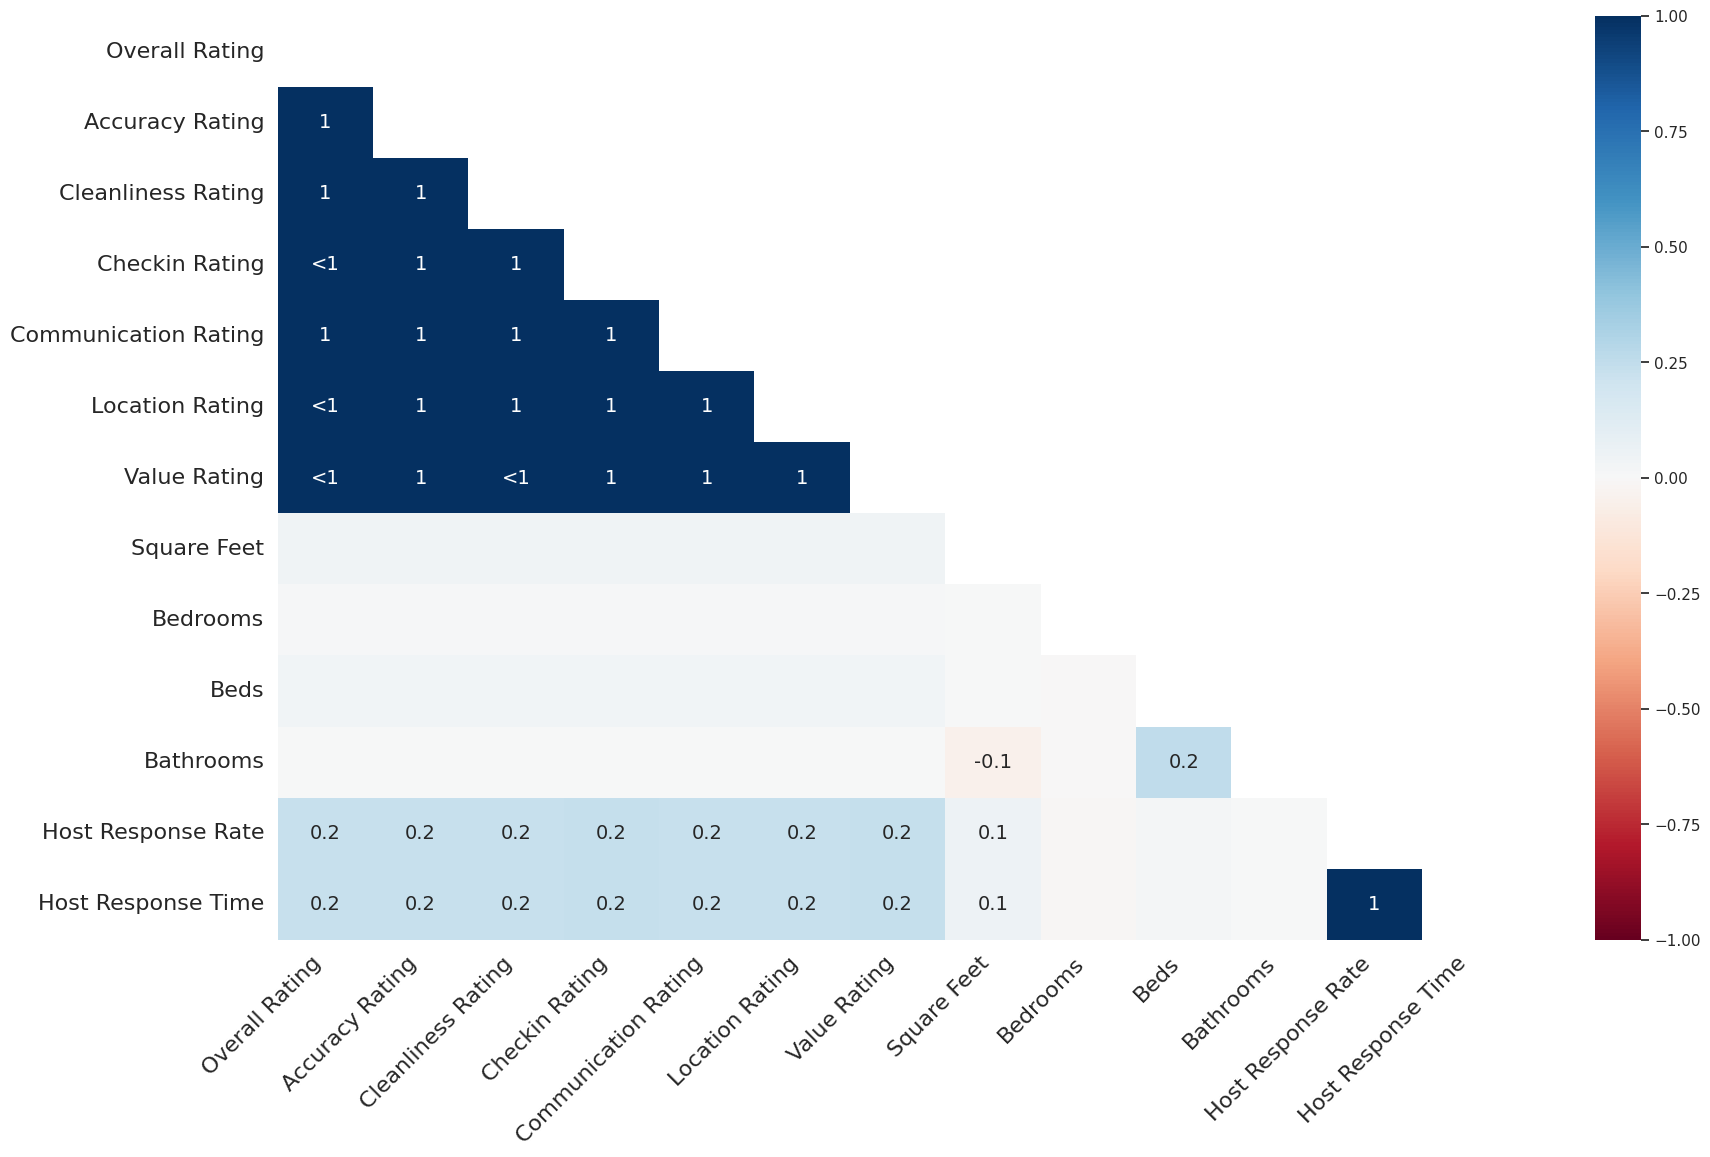

In [168]:
msno.heatmap(manipulated_data)

In [169]:
MV_df_final['drop']= 'Yes'
MV_df_final['MV_type']= 'MCAR/MAR'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'drop']='No'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'MV_type']='MNAR'
MV_df_final = MV_df_final[MV_df_final['MV_pct']>0].sort_values(by='MV_pct', ascending=False)
MV_df_final

Var MV_pct distribution_changed drop   MV_type
8            Square Feet  23111                    -  Yes  MCAR/MAR
13    Host Response Rate  10490                    -  Yes  MCAR/MAR
6           Value Rating   4668                    -  Yes  MCAR/MAR
3         Checkin Rating   4666                    -  Yes  MCAR/MAR
5        Location Rating   4665                    -  Yes  MCAR/MAR
4   Communication Rating   4650                    -  Yes  MCAR/MAR
1        Accuracy Rating   4648                    -  Yes  MCAR/MAR
2     Cleanliness Rating   4644                    -  Yes  MCAR/MAR
0         Overall Rating   4622                    -  Yes  MCAR/MAR
11                  Beds     35                    -  Yes  MCAR/MAR
12             Bathrooms     29                    -  Yes  MCAR/MAR
10              Bedrooms     20                    -  Yes  MCAR/MAR

In [170]:
MV_df_final['drop']= 'Yes'
MV_df_final['MV_type']= 'MCAR/MAR'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'drop']='No'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'MV_type']='MNAR'
MV_df_final = MV_df_final[MV_df_final['MV_pct']>0].sort_values(by='MV_pct', ascending=False)
MV_df_final

Var MV_pct distribution_changed drop   MV_type
8            Square Feet  23111                    -  Yes  MCAR/MAR
13    Host Response Rate  10490                    -  Yes  MCAR/MAR
6           Value Rating   4668                    -  Yes  MCAR/MAR
3         Checkin Rating   4666                    -  Yes  MCAR/MAR
5        Location Rating   4665                    -  Yes  MCAR/MAR
4   Communication Rating   4650                    -  Yes  MCAR/MAR
1        Accuracy Rating   4648                    -  Yes  MCAR/MAR
2     Cleanliness Rating   4644                    -  Yes  MCAR/MAR
0         Overall Rating   4622                    -  Yes  MCAR/MAR
11                  Beds     35                    -  Yes  MCAR/MAR
12             Bathrooms     29                    -  Yes  MCAR/MAR
10              Bedrooms     20                    -  Yes  MCAR/MAR

###Data Imputation TBD
we can  see that according to previous table , it recoment to drop all the columns.
let's gover the coulms  and analyze them .


In [171]:
df_final=manipulated_data
df_nulls.columns

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Square Feet', 'Bedrooms', 'Beds', 'Bathrooms',
       'Host Response Rate', 'Host Response Time'],
      dtype='object')

In [172]:
mis_val_table_ren_columns

Missing Values  % of Total Values
Square Feet                    23111               98.2
Host Response Rate             10490               44.6
Host Response Time             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
Beds                              35                0.1
Bathrooms                         29                0.1
Bedrooms                          20                0.1

In [173]:
manipulated_data.index[-1]
manipulated_data.reset_index(drop=True, inplace=True)

In [174]:
df_nulls.columns

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Square Feet', 'Bedrooms', 'Beds', 'Bathrooms',
       'Host Response Rate', 'Host Response Time'],
      dtype='object')

1.   we will delete 'Square Feet' beccause its almost 100% empty column

In [175]:
df_final.drop(columns=['Square Feet'], inplace=True)

2. we will delete 'Host Response Rate' because its almost 50% empty

In [176]:
df_final.drop(columns=['Host Response Rate'], inplace=True)

We will categorize the missing values of dummies and categorial values:

In [177]:
#host_response_time
df_final['Host Response Time'] = df_final['Host Response Time'].apply(lambda x: x if type(x) == str else 'missing')
df_final['Host Response Time'].isnull().sum()

0

The rest of the data is below 40% missing. hense we can imput. we will use KNN

In [178]:
final_df = df_final.copy()
imp_cols = final_df.select_dtypes(include = ['float64', 'int64']).columns
imp_cols = [col for col in imp_cols if col not in ['Longitude', 'Latitude']]
imp_cols

['Overall Rating',
 'Accuracy Rating',
 'Cleanliness Rating',
 'Checkin Rating',
 'Communication Rating',
 'Location Rating',
 'Value Rating',
 'Price',
 'Reviews',
 'Bedrooms',
 'Beds',
 'Bathrooms',
 'Accomodates',
 'Guests Included',
 'Min Nights']

In [179]:
from sklearn.impute import KNNImputer
final_df = df_final.copy()
imp_cols = final_df.select_dtypes(include = ['float64', 'int64']).columns
knn_imputer = KNNImputer(n_neighbors=2)
imputed_data = pd.DataFrame(knn_imputer.fit_transform(final_df[imp_cols]),columns = imp_cols)

In [180]:
final_df[imp_cols] = imputed_data

<Axes: >

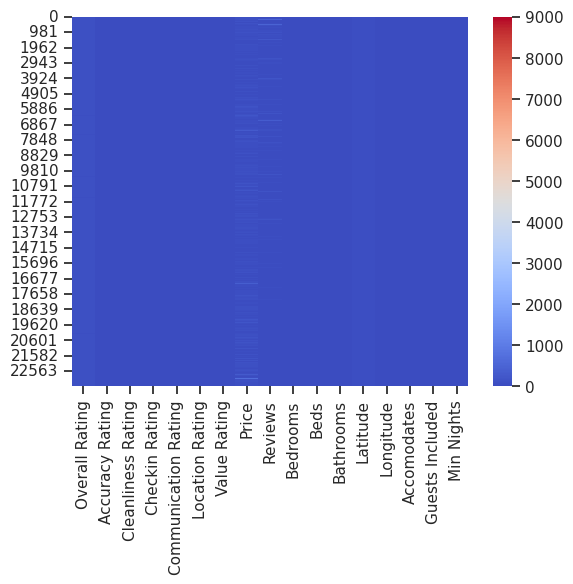

In [181]:
sns.heatmap(imputed_data, cmap="coolwarm")

In [182]:
imputed_data['Overall Rating'].notna().sum()

23536

In [183]:
print(f"df_final: {df_final.shape}, last_index: {df_final.index[-1]}")
print(f"final_df: {final_df.shape}, last_index: {final_df.index[-1]}")
print(f"imputed_data: {imputed_data.shape}, last_index: {imputed_data.index[-1]}")

df_final: (23536, 26), last_index: 23535
final_df: (23536, 26), last_index: 23535
imputed_data: (23536, 17), last_index: 23535


In [184]:
imputed_data

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531           100.0             10.0                10.0            10.0   
23532            60.0              6.0                 6.0             8.0   
23533           100.0             10.0                10.0            10.0   
23534            80.0              8.0                 8.0            10.0   
23535           100.0             10.0                 9.0            10.0   

       Communication Rating  Location Rating  Value Rating  Price  Reviews  \
0                      10.0              9.0          10.0   17.0      7.0   
1                       9.0             10.0           9.0   90.0    144.0   
2                      10.0             10.0          10.0   33.0    229.0   
3                      10.0             10.0          10.0  180.0      6.0   
4                      10.0              9.0           9.0   70.0     23.0   
...                     ...              ...           ...    ...      ...   
23531                   9.0              9.0          10.0   48.0      0.0   
23532                   8.0              6.0           6.0   30.0      0.0   
23533                  10.0              8.0           8.0   17.0      0.0   
23534                  10.0              7.0           7.0   52.0      0.0   
23535                  10.0              9.0           9.0   65.0      0.0   

       Bedrooms  Beds  Bathrooms  Latitude  Longitude  Accomodates  \
0           1.0   1.0        1.0  52.54851   13.40455          2.0   
1           1.0   2.0        1.0  52.53500   13.41758          4.0   
2           1.0   2.0        1.0  52.54316   13.41509          2.0   
3           4.0   7.0        0.0  52.53303   13.41605          0.0   
4           0.0   1.0        1.0  52.54785   13.40556          1.0   
...         ...   ...        ...       ...        ...          ...   
23531       1.0   2.0        1.0  52.42278   13.16120          3.0   
23532       2.0   2.0        1.0  52.63020   13.49340          2.0   
23533       1.0   1.0        0.0  52.45402   13.43864          1.0   
23534       3.0   4.0        1.0  52.47342   13.58483          0.0   
23535       2.0   2.0        1.0  52.54929   13.46067          3.0   

       Guests Included  Min Nights  
0                  1.0         2.0  
1                  2.0         0.0  
2                  1.0         2.0  
3                  5.0         6.0  
4                  1.0         0.0  
...                ...         ...  
23531              1.0         0.0  
23532              2.0         5.0  
23533              1.0         2.0  
23534              1.0         2.0  
23535              1.0         2.0  

[23536 rows x 17 columns]

<Axes: >

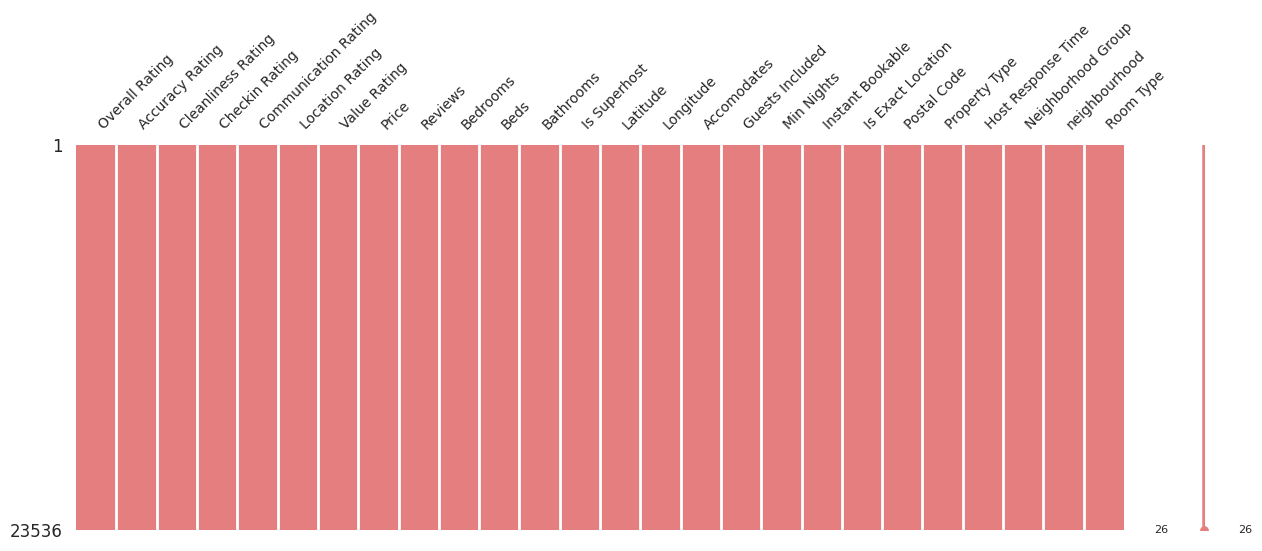

In [187]:
msno.matrix(final_df, figsize=(15, 5), fontsize=10, color=(0.9, 0.5, 0.5))

In [188]:
final_df.to_pickle("/content/drive/MyDrive/kaggle/berline/ready_for_feature_engineering.pkl")

###Next to Aggregation and Feature Engineering

In [ ]:
# import pandas as pd

# # Creating a DataFrame
# data = {'Name': ['Alice', 'Bob', 'Charlie'],
#         'Age': [25, 30, 35],
#         'City': ['New York', 'Los Angeles', 'Chicago']}


# for j in range(len(df)):
#   print(j)

# # df123 = pd.DataFrame(data)
# # df123

# # # Accessing the value at row index 1 and column 'Age'
# # value = df123.loc[1, 'Age']
# # print(value)  # Output: 30

# # # Modifying the value at row index 2 and column 'City'
# # df123.loc[2, 'City'] = 'San Francisco'
# # print(df123)


In [ ]:
# from autoviz.AutoViz_Class import AutoViz_Class
# import missingno as msno
# import matplotlib.pyplot as plt
# %matplotlib inline
# AV = AutoViz_Class()
# AV.AutoViz(filename="", sep=",", depVar="Price", dfte=df_aggregated, max_cols_analyzed=10)


In [ ]:
# from geopy.distance import great_circle
# def distance_to_mid(lat, lon):
#     berlin_centre = (52.5027778, 13.404166666666667)
#     accommodation = (lat, lon)
#     return great_circle(berlin_centre, accommodation).km

# df_aggregated['Distance From Center Cleansed'] = df_aggregated.apply(lambda row: round(distance_to_mid(row['Latitude'], row['Longitude']), 1), axis=1)
# bins = [0, 0.5, 1, 2, 4, 8, 16]
# labels = ["Center", "Cercile1 ", "Cercile2", "Cercile4", "Cercile8", "Cercile16"]

# # Apply pd.cut() to create a new binned column
# df_aggregated["Distance From Center Grouped Cleansed"] = pd.cut(df_aggregated["Distance From Center Cleansed"], bins=bins, labels=labels, include_lowest=True)
# # df_aggregated.drop(columns=["Distance From Center Cleansed"], inplace=True)
# # df_aggregated.drop(columns=["Latitude","Longitude"], inplace=True)
